In [3]:
## Further  recommendation, test multiple frameworks, see what works better on average.
## Open source RL: https://docs.google.com/spreadsheets/d/1EeFPd-XIQ3mq_9snTlAZSsFY7Hbnmd7P5bbT8LPuMn0/edit#gid=0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:

import mysql.connector
query = "SELECT td, close, codenum FROM market"
mydb = mysql.connector.connect(
      host="172.31.50.91",
      user="guest",
      password="MH#123456",
       database="astocks"
    )
df1 = pd.read_sql(query, mydb)
df1 = df1.sort_values(by=['td'])

DatabaseError: 2003 (HY000): Can't connect to MySQL server on '172.31.50.91:3306' (10060)

In [4]:
class Deep_Evolution_Strategy:
    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
#             if (i+1) == epoch:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')

In [5]:
def get_state(data, t, n):
#     print(len(data),t)
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[: t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [6]:
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [7]:
import time


class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(
        self, model, money, max_buy, max_sell, close, window_size, skip
    ):
        self.window_size = window_size
        self.skip = skip
        self.close = close
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        try:
            return np.argmax(decision[0]), int(buy[0])
        except:
            return np.argmax(decision[0]), int(100)

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        len_close = len(self.close) - 1

        self.model.weights = weights
        
        inventory = []
        quantity = 0
        for t in range(0, len_close+1, self.skip):
            state = get_state(self.close, t , self.window_size + 1)
            action, buy = self.act(state)
            if action == 1 and initial_money >= self.close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell

            
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        len_close = len(self.close) - 1
        state = get_state(self.close, 0, self.window_size + 1)
        
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        whole_money = []
        
        for t in range(0, len_close, self.skip):
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= self.close[t]:
                if buy < 0:
                    buy = 0
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                
                buy_units = buy_units//100 * 100
                total_buy = buy_units * self.close[t]
                

                ####
                if initial_money <= total_buy:
                    buy_units = initial_money // self.close[t]
                    buy_units = buy_units//100 * 100
                    total_buy= buy_units * self.close[t]
                    
                initial_money -= total_buy   
                
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    '日期 %d: 购买 %d 单位， 消耗 %f, 账户现金 %f, 总资产 %f, 基准收益率 %f,'
                    % (t, buy_units, total_buy, initial_money, initial_money + quantity * self.close[t],self.close[t]/self.close[0])
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    whole_money += [(initial_money + quantity * self.close[t])/starting_money* self.close[0]]
                    continue
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    '日期 %d: 抛售 %d 单位， 获得 %f, 交易收益率 %f %%, 账户现金 %f, 总资产 %f，基准收益率 %f'
                    % (t, sell_units, total_sell, invest, initial_money,  initial_money + quantity * self.close[t],self.close[t]/self.close[0])
                )
            state = next_state
            whole_money += [(initial_money + quantity * self.close[t])/starting_money* self.close[0]]
        
        print('Quantity:', quantity)
        print('Last price', self.close[-1])
        invest = ((initial_money - starting_money + self.close[-1] * quantity) / starting_money) * 100
        print(
            '\n总收益数额 %f, 总收益率 %f %%'
            % (initial_money - starting_money + self.close[-1] * quantity, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(self.close, label = 'true close', c = 'g')
        plt.plot(
            self.close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            self.close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        
        plt.plot(
            whole_money, label = 'actual wealth rate', c = 'y'
        )
        
        plt.legend()
#         plt.savefig('output/'+name+'.png')
        plt.show()

In [8]:
def whole_test(code,df1):    
    gstock_data = df1[df1['codenum'] == code].dropna().iloc[-300:-100]
    gstock_data = gstock_data.reset_index(drop = True)    
    window_size = 30
    close = gstock_data.close.values.tolist()
    model = Model(input_size = window_size, layer_size = 5, output_size = 3)
    agent = Agent(
        model = model,
        money = 100000,
        max_buy = 1000,
        max_sell = 1000,
        close = close,
        window_size = window_size,
        skip = 1,
    )    
    agent.fit(iterations = 500, checkpoint = 10)
    gstock_data = df1[df1['codenum'] == code].dropna().iloc[-100:]
    gstock_data = gstock_data.reset_index(drop = True)
    close = gstock_data.close.values.tolist()
    agent.close = close   
    agent.buy()
    print('Benchmark rate is ',float(close[-1]-close[0])/close[0])
    print(agent.model.weights)

iter 10. reward: 0.640400
iter 20. reward: 5.294270
iter 30. reward: 15.545860
iter 40. reward: 28.334060
iter 50. reward: 41.864620
iter 60. reward: 58.338630
iter 70. reward: 75.698620
iter 80. reward: 96.744910
iter 90. reward: 116.601460
iter 100. reward: 120.425180
iter 110. reward: 140.939170
iter 120. reward: 143.489600
iter 130. reward: 135.183980
iter 140. reward: 158.170860
iter 150. reward: 159.463610
iter 160. reward: 128.147120
iter 170. reward: 169.865100
iter 180. reward: 170.369260
iter 190. reward: 171.505700
iter 200. reward: 177.908430
iter 210. reward: 176.108060
iter 220. reward: 166.128620
iter 230. reward: 170.741380
iter 240. reward: 178.628300
iter 250. reward: 174.282690
iter 260. reward: 185.238180
iter 270. reward: 183.885000
iter 280. reward: 182.874220
iter 290. reward: 179.341060
iter 300. reward: 142.328750
iter 310. reward: 183.341590
iter 320. reward: 184.276670
iter 330. reward: 179.563740
iter 340. reward: 181.273750
iter 350. reward: 183.595690
iter

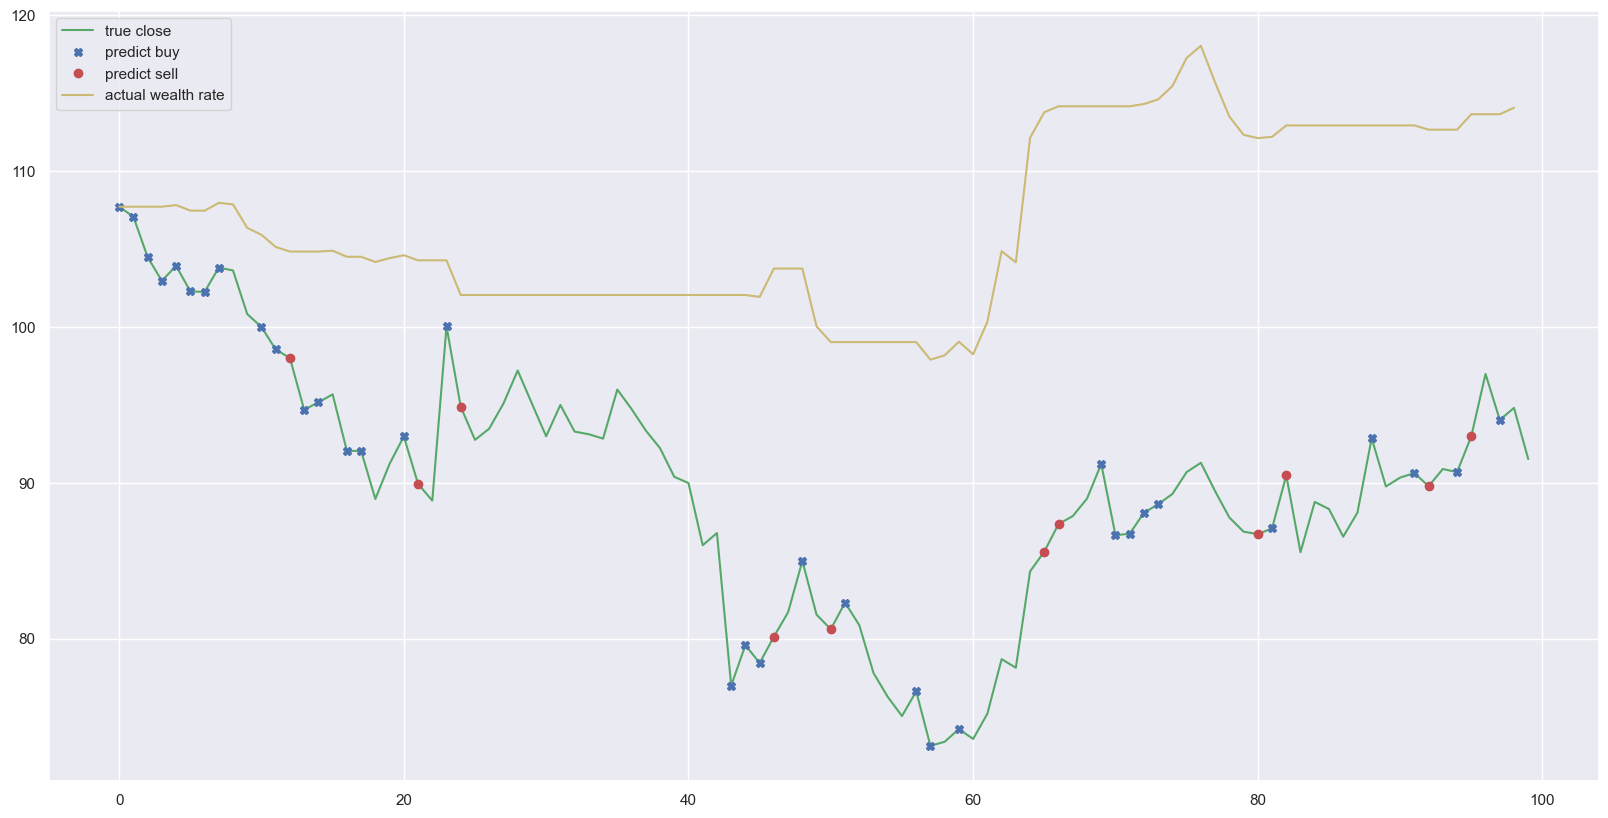

Benchmark rate is  -0.15028311519539586


In [49]:
whole_test('688114.SH',df1) 

iter 10. reward: 0.707620
iter 20. reward: 2.115800
iter 30. reward: 3.680190
iter 40. reward: 6.213210
iter 50. reward: 9.098910
iter 60. reward: 15.669300
iter 70. reward: 22.220170
iter 80. reward: 31.738110
iter 90. reward: 44.746580
iter 100. reward: 54.989430
iter 110. reward: 64.233340
iter 120. reward: 74.393290
iter 130. reward: 93.748990
iter 140. reward: 112.962830
iter 150. reward: 113.550410
iter 160. reward: 118.689930
iter 170. reward: 124.641030
iter 180. reward: 126.672350
iter 190. reward: 139.914630
iter 200. reward: 138.450060
iter 210. reward: 141.245470
iter 220. reward: 133.831080
iter 230. reward: 146.816640
iter 240. reward: 152.562210
iter 250. reward: 158.835850
iter 260. reward: 159.651930
iter 270. reward: 156.333140
iter 280. reward: 162.376990
iter 290. reward: 162.872580
iter 300. reward: 157.402200
iter 310. reward: 165.564540
iter 320. reward: 170.164810
iter 330. reward: 166.670170
iter 340. reward: 172.800840
iter 350. reward: 180.782740
iter 360. re

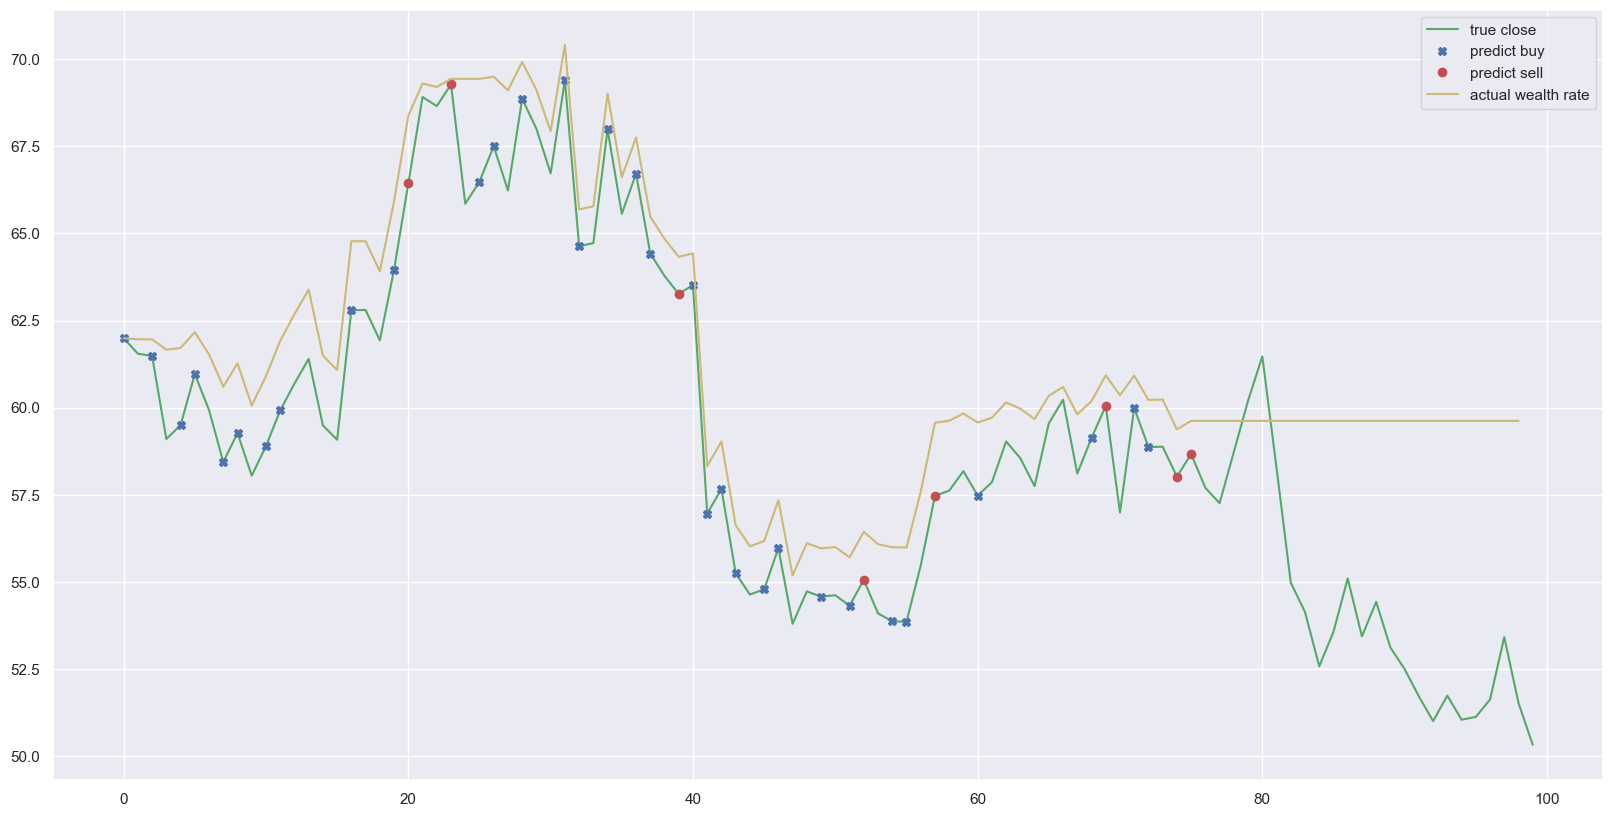

Benchmark rate is  -0.18809485400871115


In [51]:
whole_test('688060.SH',df1)

iter 10. reward: 0.670040
iter 20. reward: 2.409530
iter 30. reward: 3.905260
iter 40. reward: 5.311660
iter 50. reward: 8.060710
iter 60. reward: 12.873990
iter 70. reward: 16.225010
iter 80. reward: 22.226130
iter 90. reward: 27.972700
iter 100. reward: 33.481450
iter 110. reward: 51.249820
iter 120. reward: 57.392160
iter 130. reward: 67.285350
iter 140. reward: 69.969100
iter 150. reward: 73.226690
iter 160. reward: 73.984990
iter 170. reward: 71.776890
iter 180. reward: 73.751150
iter 190. reward: 77.069960
iter 200. reward: 79.040470
iter 210. reward: 79.501440
iter 220. reward: 79.829630
iter 230. reward: 79.155490
iter 240. reward: 78.058350
iter 250. reward: 79.483620
iter 260. reward: 83.595180
iter 270. reward: 82.635410
iter 280. reward: 82.671340
iter 290. reward: 82.276280
iter 300. reward: 85.423270
iter 310. reward: 88.652950
iter 320. reward: 93.455980
iter 330. reward: 95.467400
iter 340. reward: 93.675320
iter 350. reward: 97.556070
iter 360. reward: 97.640350
iter 3

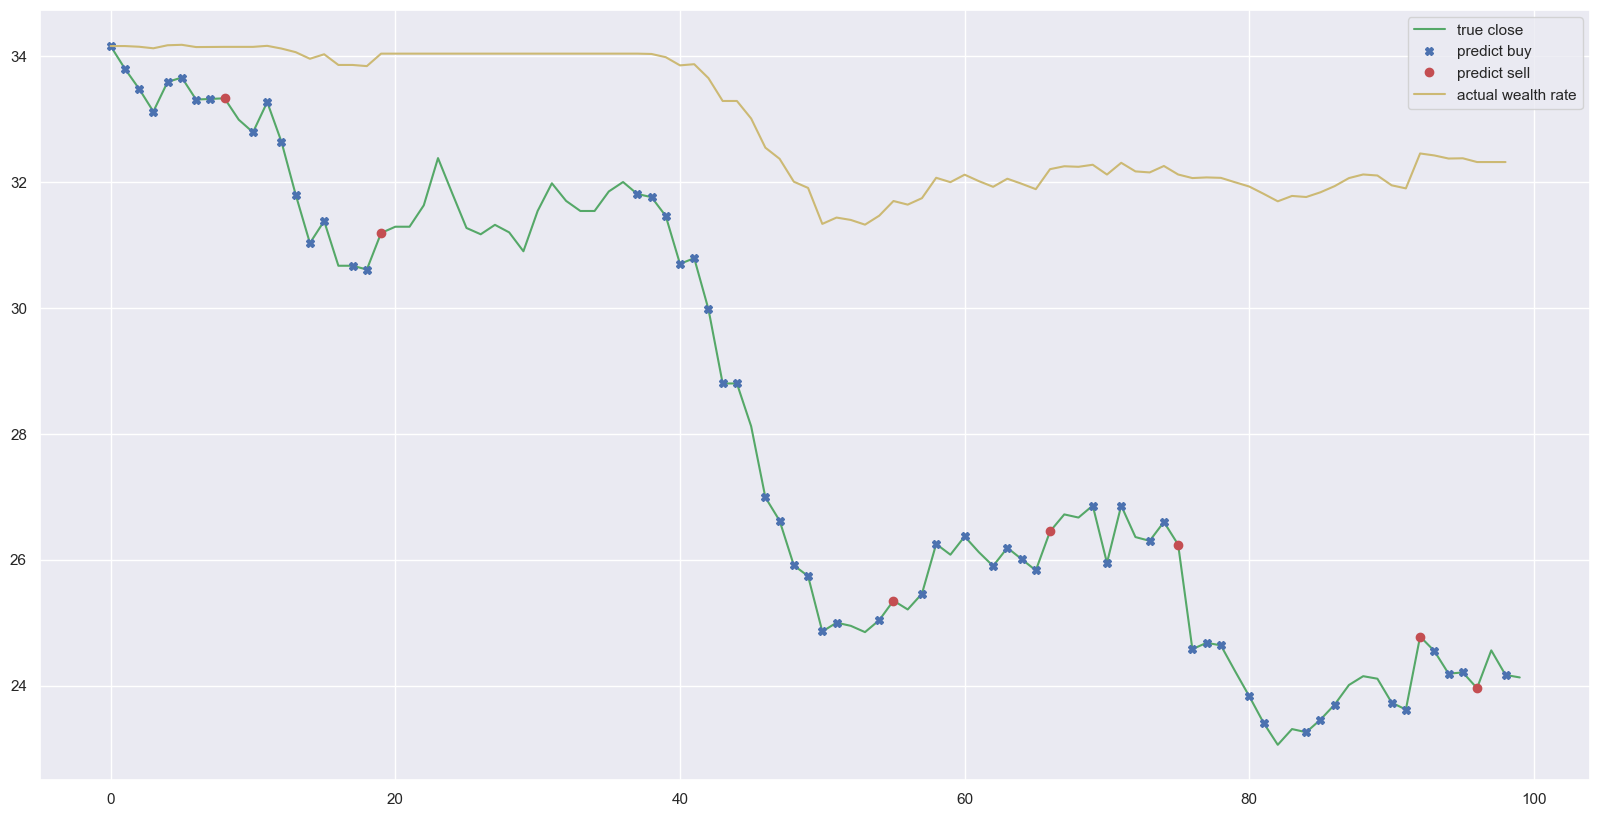

Benchmark rate is  -0.2936182669789227


In [52]:
whole_test('688317.SH',df1)

iter 10. reward: 0.312670
iter 20. reward: 0.399560
iter 30. reward: 0.264680
iter 40. reward: 0.429760
iter 50. reward: 1.904950
iter 60. reward: 2.812130
iter 70. reward: 3.352350
iter 80. reward: 5.668790
iter 90. reward: 6.592350
iter 100. reward: 8.608180
iter 110. reward: 10.817000
iter 120. reward: 13.111510
iter 130. reward: 14.614990
iter 140. reward: 16.252850
iter 150. reward: 15.147080
iter 160. reward: 18.797290
iter 170. reward: 21.257240
iter 180. reward: 24.870070
iter 190. reward: 27.631550
iter 200. reward: 27.219660
iter 210. reward: 29.917750
iter 220. reward: 29.120700
iter 230. reward: 31.956130
iter 240. reward: 34.347610
iter 250. reward: 34.076410
iter 260. reward: 26.568010
iter 270. reward: 34.191130
iter 280. reward: 37.743230
iter 290. reward: 44.891040
iter 300. reward: 51.724440
iter 310. reward: 54.682440
iter 320. reward: 58.268090
iter 330. reward: 60.094640
iter 340. reward: 61.619810
iter 350. reward: 64.114250
iter 360. reward: 64.301020
iter 370. r

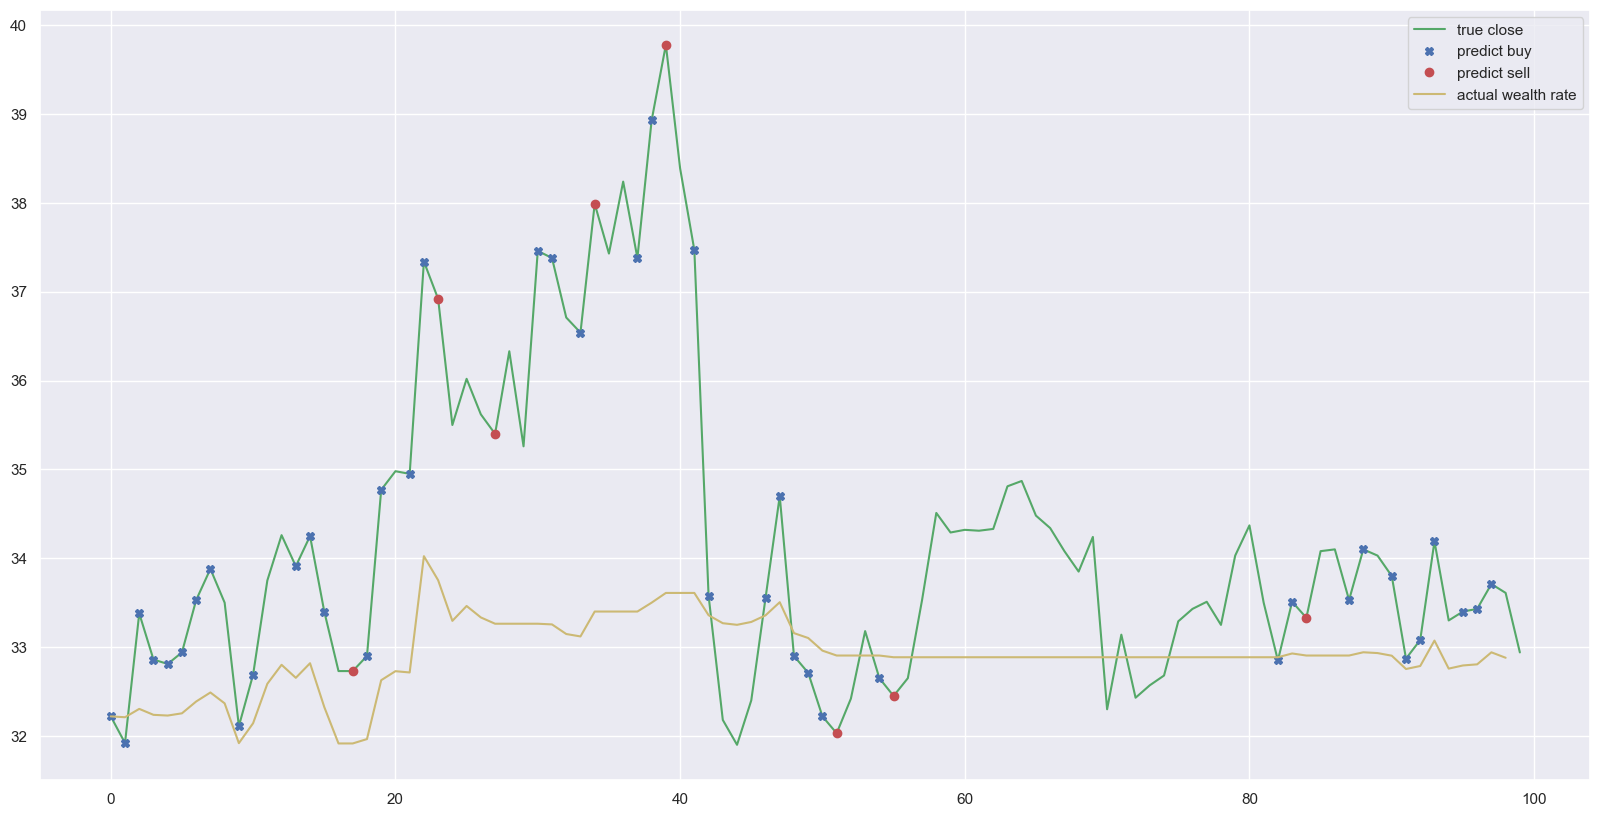

Benchmark rate is  0.022346368715083765


In [54]:
whole_test('688511.SH',df1)

iter 10. reward: 0.547830
iter 20. reward: 1.201360
iter 30. reward: 3.399440
iter 40. reward: 4.576920
iter 50. reward: 15.745140
iter 60. reward: 21.839800
iter 70. reward: 26.626190
iter 80. reward: 34.038820
iter 90. reward: 29.784870
iter 100. reward: 37.841630
iter 110. reward: 47.144200
iter 120. reward: 44.214840
iter 130. reward: 55.715690
iter 140. reward: 61.350150
iter 150. reward: 58.323670
iter 160. reward: 59.812610
iter 170. reward: 63.296900
iter 180. reward: 69.080610
iter 190. reward: 75.908620
iter 200. reward: 64.250090
iter 210. reward: 83.332280
iter 220. reward: 83.384580
iter 230. reward: 87.290800
iter 240. reward: 93.601530
iter 250. reward: 105.821710
iter 260. reward: 105.010520
iter 270. reward: 117.032730
iter 280. reward: 118.128420
iter 290. reward: 119.360120
iter 300. reward: 125.325230
iter 310. reward: 123.478020
iter 320. reward: 128.660970
iter 330. reward: 129.806300
iter 340. reward: 134.161310
iter 350. reward: 135.637740
iter 360. reward: 137.

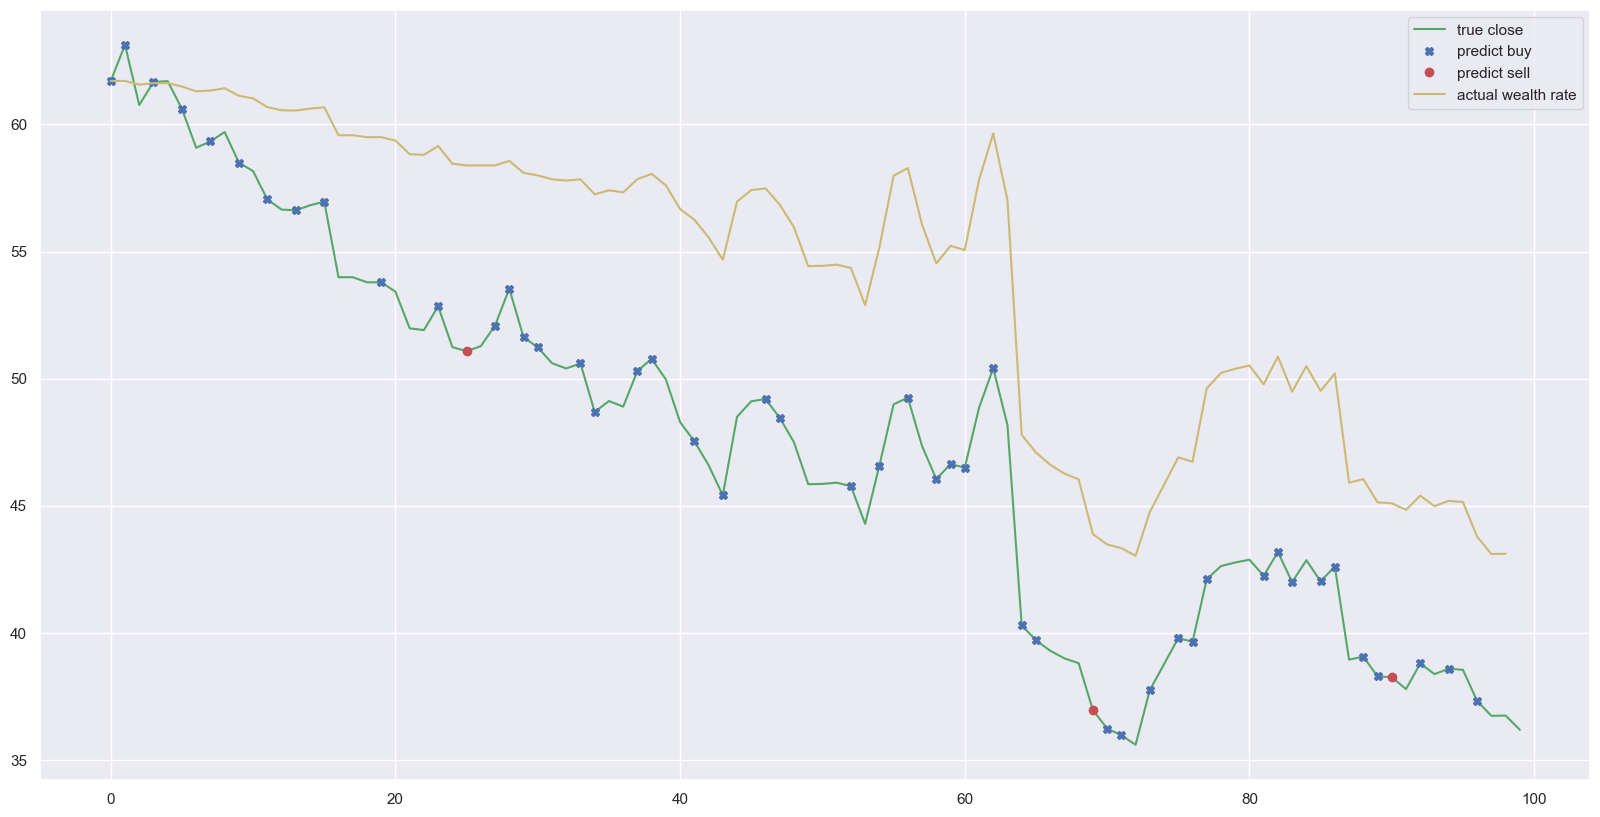

Benchmark rate is  -0.41354723707664887


In [55]:
whole_test('688599.SH',df1)

iter 10. reward: 0.015290
iter 20. reward: 0.072430
iter 30. reward: 0.333380
iter 40. reward: 0.483510
iter 50. reward: 0.836790
iter 60. reward: 1.385980
iter 70. reward: 2.081470
iter 80. reward: 1.418040
iter 90. reward: 2.534000
iter 100. reward: 1.959610
iter 110. reward: 2.426330
iter 120. reward: 2.435060
iter 130. reward: 2.409120
iter 140. reward: 2.545850
iter 150. reward: 2.724080
iter 160. reward: 2.630490
iter 170. reward: 2.395810
iter 180. reward: 2.699890
iter 190. reward: 2.047290
iter 200. reward: 2.794360
iter 210. reward: 1.923280
iter 220. reward: 2.688760
iter 230. reward: 2.665810
iter 240. reward: 3.472680
iter 250. reward: 3.552810
iter 260. reward: 3.505250
iter 270. reward: 3.305750
iter 280. reward: 3.012290
iter 290. reward: 3.407770
iter 300. reward: 3.379190
iter 310. reward: 3.143380
iter 320. reward: 3.978710
iter 330. reward: 3.912770
iter 340. reward: 4.052840
iter 350. reward: 4.724760
iter 360. reward: 5.439360
iter 370. reward: 4.959760
iter 380. 

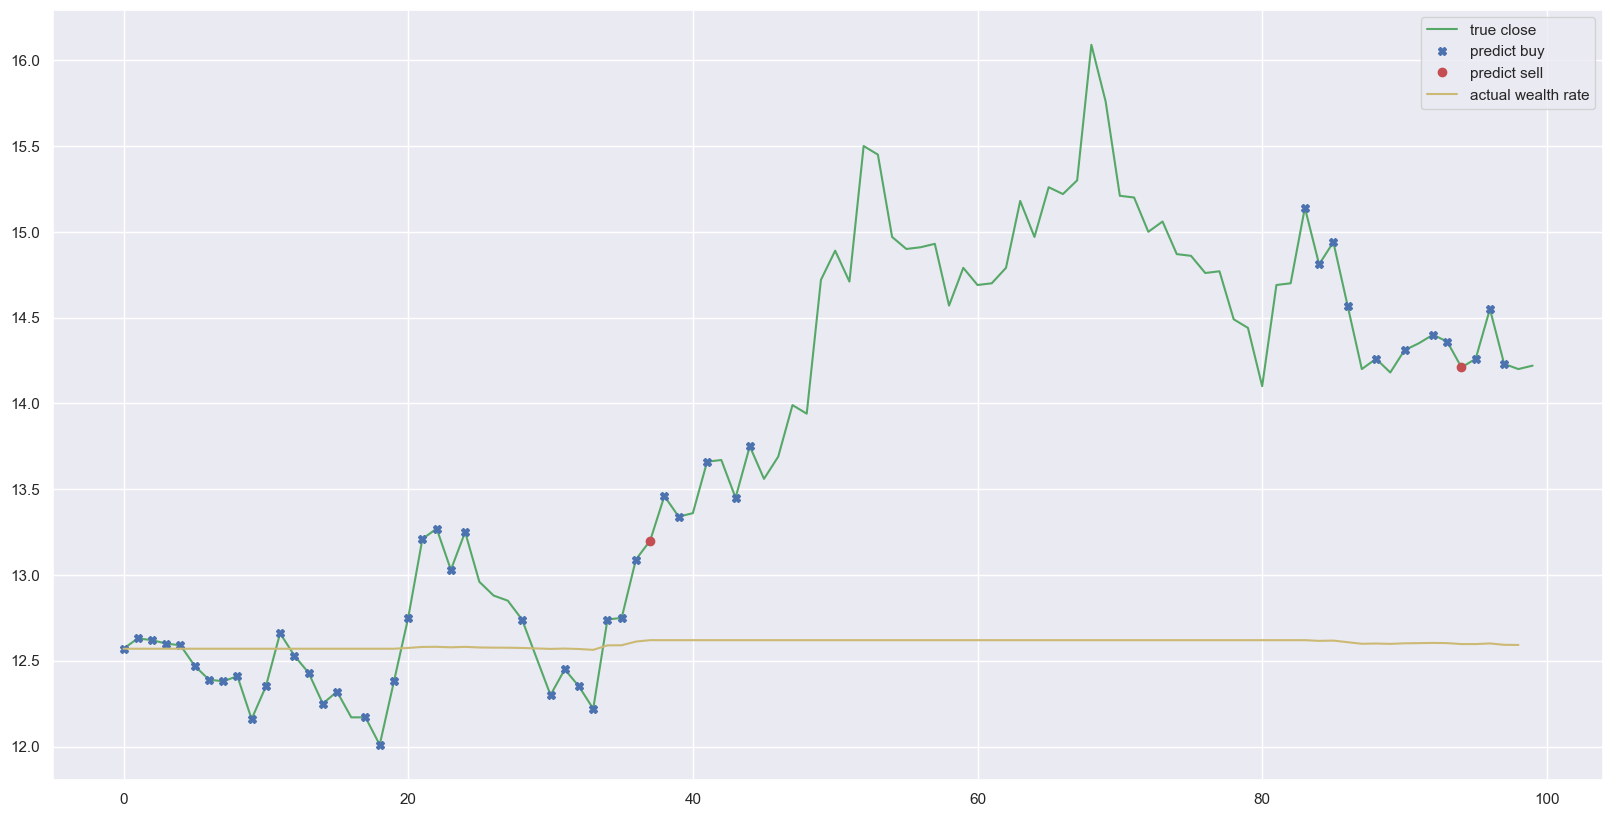

Benchmark rate is  0.13126491646778046


In [56]:
whole_test('688679.SH',df1)

iter 10. reward: 0.160060
iter 20. reward: 0.319960
iter 30. reward: 0.519870
iter 40. reward: 0.797120
iter 50. reward: 1.192090
iter 60. reward: 1.866830
iter 70. reward: 2.433630
iter 80. reward: 3.055270
iter 90. reward: 3.265270
iter 100. reward: 4.300250
iter 110. reward: 5.861290
iter 120. reward: 6.810580
iter 130. reward: 9.685320
iter 140. reward: 13.626660
iter 150. reward: 15.476630
iter 160. reward: 18.203370
iter 170. reward: 19.222760
iter 180. reward: 20.388680
iter 190. reward: 20.347300
iter 200. reward: 21.300970
iter 210. reward: 21.485250
iter 220. reward: 22.224480
iter 230. reward: 23.483540
iter 240. reward: 24.186340
iter 250. reward: 24.349530
iter 260. reward: 24.752950
iter 270. reward: 25.350130
iter 280. reward: 25.644580
iter 290. reward: 27.498830
iter 300. reward: 29.503380
iter 310. reward: 29.942140
iter 320. reward: 30.293330
iter 330. reward: 34.673960
iter 340. reward: 35.939720
iter 350. reward: 35.888840
iter 360. reward: 36.031560
iter 370. rewa

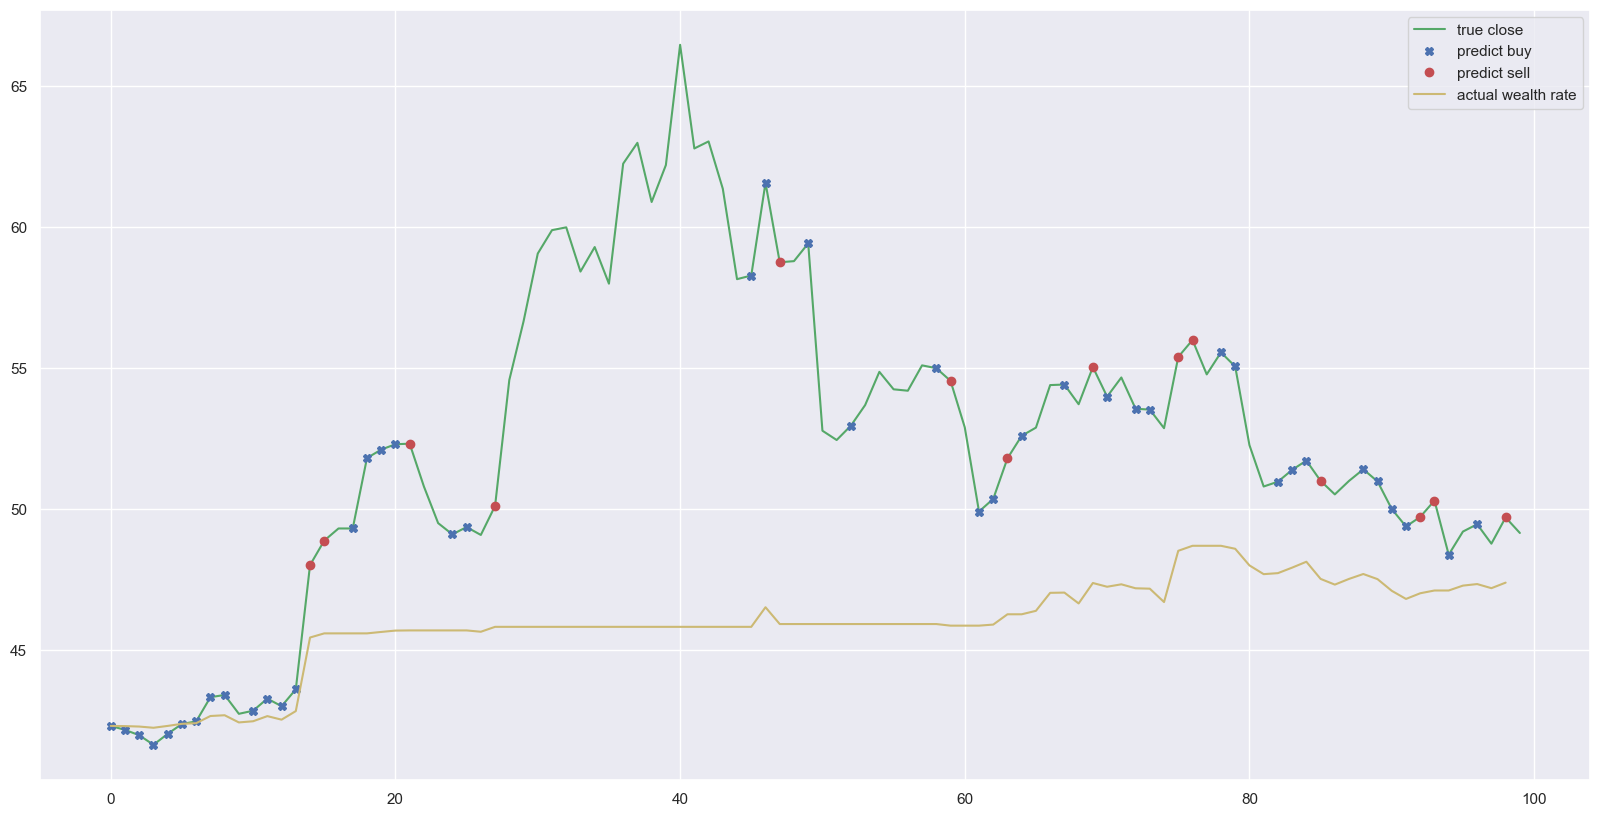

Benchmark rate is  0.16193853427895985


In [57]:
whole_test('688981.SH',df1)

iter 10. reward: 0.192370
iter 20. reward: 0.689250
iter 30. reward: 1.129790
iter 40. reward: 1.327640
iter 50. reward: 2.264060
iter 60. reward: 3.349200
iter 70. reward: 3.302210
iter 80. reward: 4.620810
iter 90. reward: 4.828620
iter 100. reward: 5.432020
iter 110. reward: 5.697760
iter 120. reward: 6.017990
iter 130. reward: 7.829420
iter 140. reward: 8.999590
iter 150. reward: 10.291280
iter 160. reward: 12.963360
iter 170. reward: 10.495300
iter 180. reward: 15.263760
iter 190. reward: 15.531320
iter 200. reward: 16.105590
iter 210. reward: 18.276380
iter 220. reward: 17.932310
iter 230. reward: 20.213030
iter 240. reward: 20.493680
iter 250. reward: 20.352740
iter 260. reward: 20.649230
iter 270. reward: 20.452460
iter 280. reward: 19.744870
iter 290. reward: 19.927980
iter 300. reward: 20.594570
iter 310. reward: 19.817510
iter 320. reward: 14.490680
iter 330. reward: 20.063200
iter 340. reward: 20.310530
iter 350. reward: 19.500750
iter 360. reward: -0.480790
iter 370. rewar

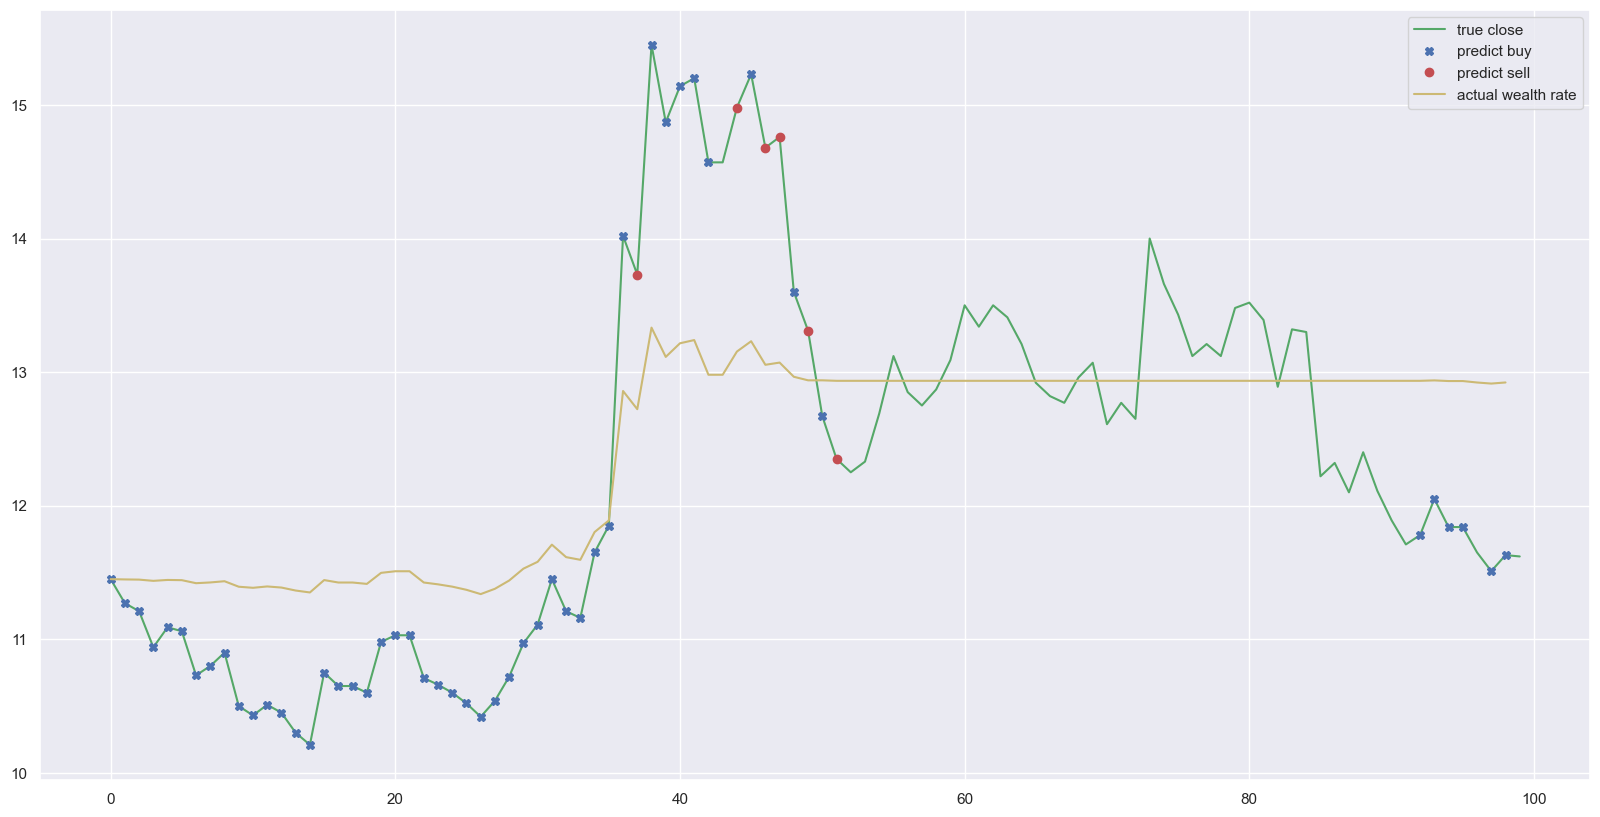

Benchmark rate is  0.014847161572052396


In [59]:
whole_test('688488.SH',df1)

iter 10. reward: 0.436750
iter 20. reward: 0.933130
iter 30. reward: 2.612280
iter 40. reward: 5.152030
iter 50. reward: 6.205840
iter 60. reward: 6.803380
iter 70. reward: 7.590710
iter 80. reward: 8.491950
iter 90. reward: 10.712490
iter 100. reward: 12.492010
iter 110. reward: 13.632740
iter 120. reward: 14.061320
iter 130. reward: 16.552810
iter 140. reward: 18.846880
iter 150. reward: 19.535090
iter 160. reward: 20.278740
iter 170. reward: 21.554440
iter 180. reward: 21.870980
iter 190. reward: 22.320570
iter 200. reward: 23.384390
iter 210. reward: 24.194000
iter 220. reward: 24.731530
iter 230. reward: 26.415200
iter 240. reward: 30.655900
iter 250. reward: 31.199090
iter 260. reward: 30.733560
iter 270. reward: 33.739430
iter 280. reward: 34.118200
iter 290. reward: 34.790790
iter 300. reward: 35.826120
iter 310. reward: 37.798820
iter 320. reward: 37.387870
iter 330. reward: 38.733040
iter 340. reward: 35.633390
iter 350. reward: 38.503690
iter 360. reward: 40.051760
iter 370.

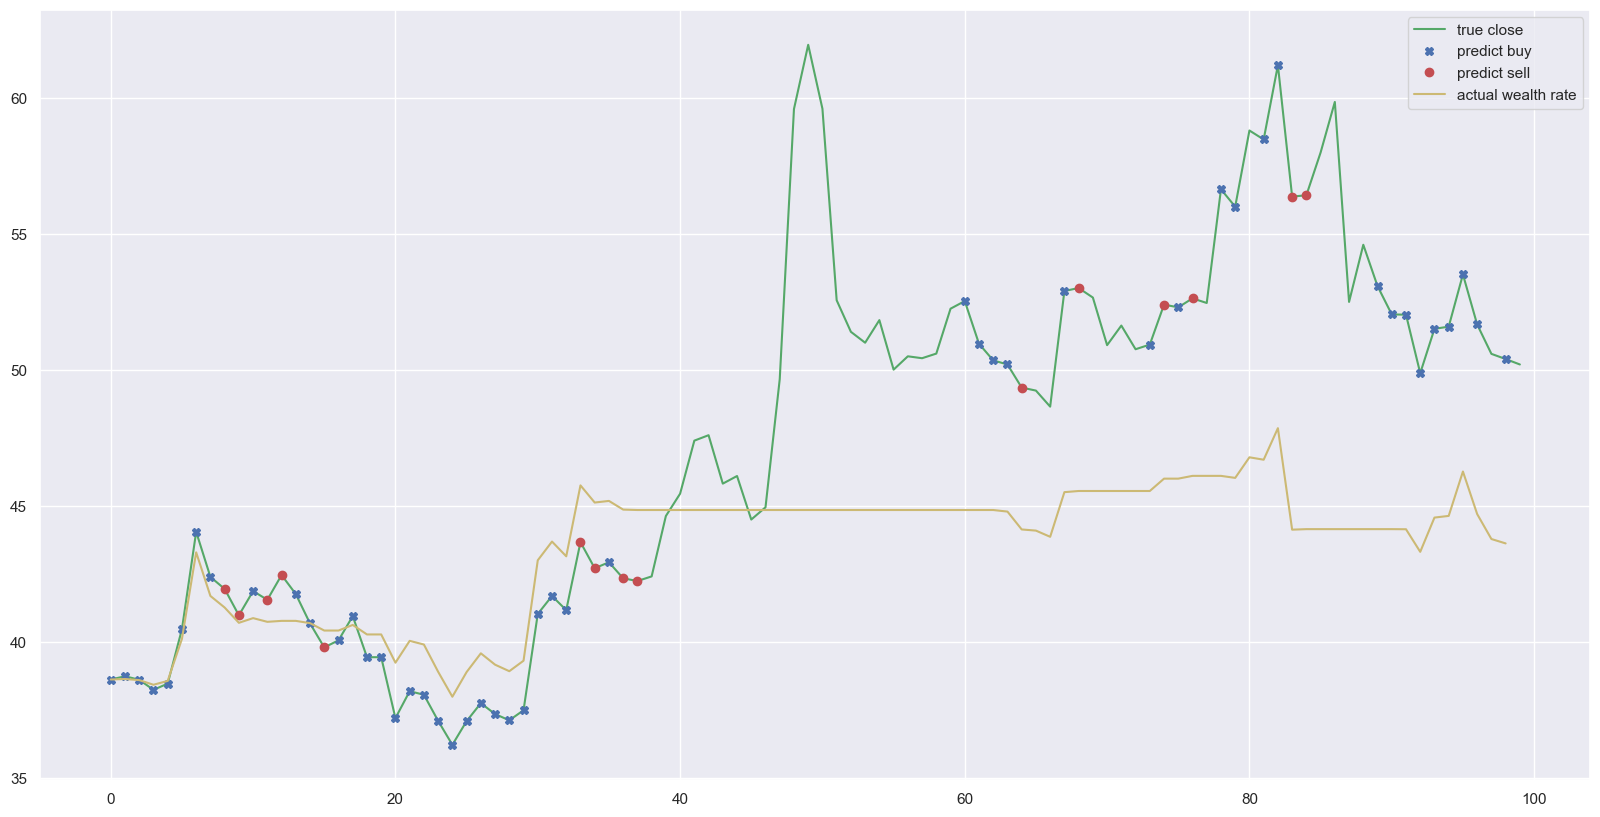

Benchmark rate is  0.29984464008285877


In [60]:
whole_test('688410.SH',df1)

iter 10. reward: -0.001510
iter 20. reward: 0.016850
iter 30. reward: 0.035840
iter 40. reward: 0.274920
iter 50. reward: 1.651790
iter 60. reward: 4.345110
iter 70. reward: 16.613160
iter 80. reward: 24.825950
iter 90. reward: 25.998530
iter 100. reward: 24.228820
iter 110. reward: 23.355390
iter 120. reward: 25.147430
iter 130. reward: 29.702380
iter 140. reward: 29.078080
iter 150. reward: 28.527850
iter 160. reward: 31.629840
iter 170. reward: 36.877120
iter 180. reward: 37.533670
iter 190. reward: 38.234270
iter 200. reward: 37.088660
iter 210. reward: 37.530930
iter 220. reward: 41.217470
iter 230. reward: 50.951340
iter 240. reward: 47.385740
iter 250. reward: 48.828230
iter 260. reward: 48.853450
iter 270. reward: 50.674080
iter 280. reward: 51.789780
iter 290. reward: 52.062490
iter 300. reward: 51.606510
iter 310. reward: 54.572000
iter 320. reward: 55.132080
iter 330. reward: 56.846580
iter 340. reward: 55.424960
iter 350. reward: 56.019610
iter 360. reward: 55.455740
iter 3

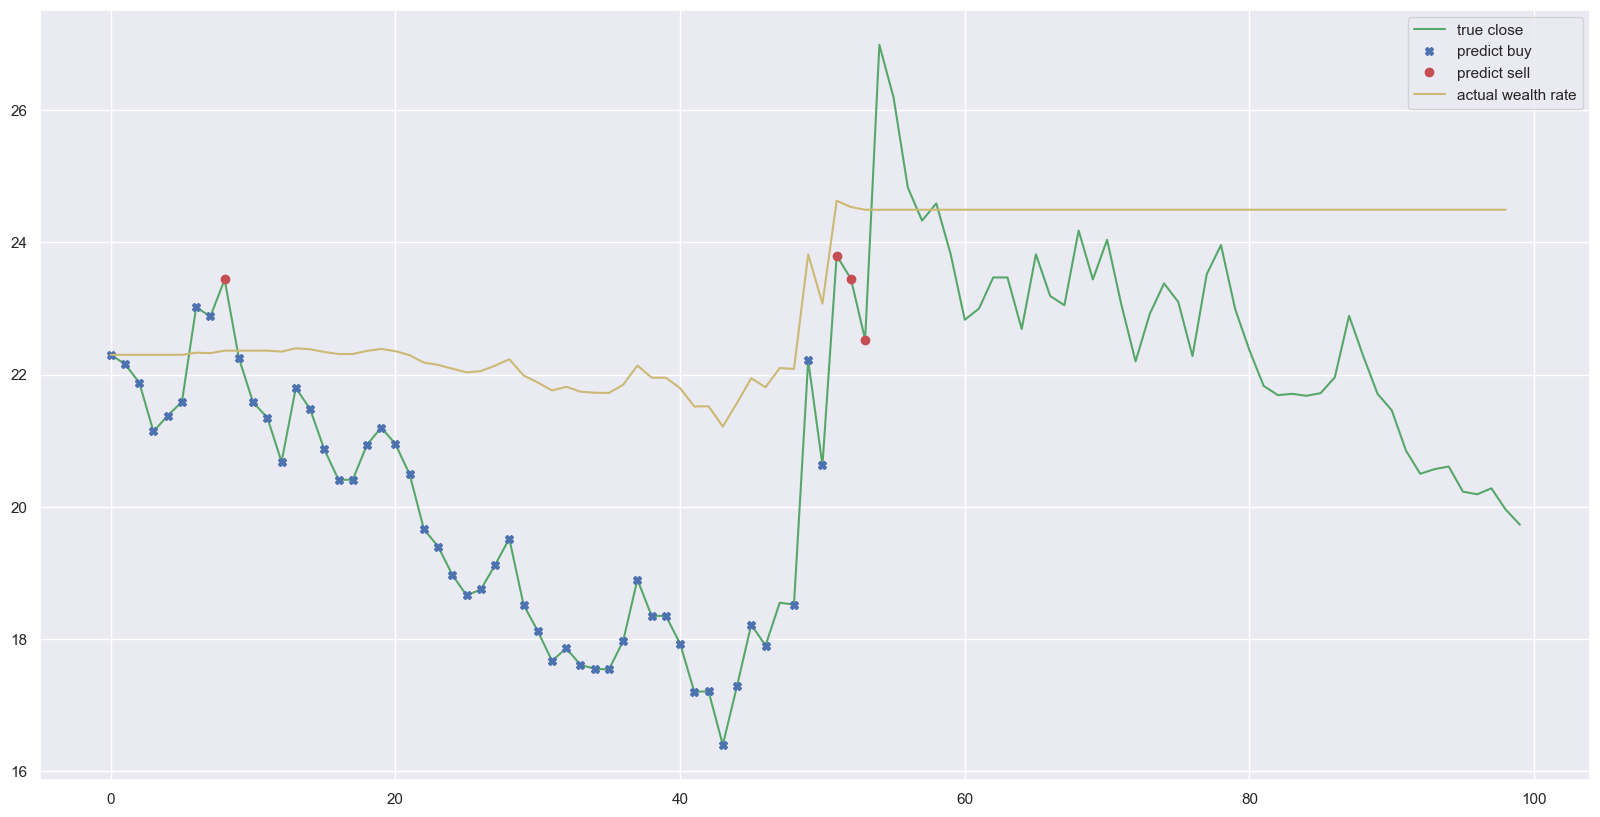

Benchmark rate is  -0.11524663677130045


In [62]:
whole_test('688517.SH',df1)

iter 10. reward: 0.162300
iter 20. reward: 0.485150
iter 30. reward: 1.221700
iter 40. reward: 1.976190
iter 50. reward: 2.327680
iter 60. reward: 3.587110
iter 70. reward: 4.763970
iter 80. reward: 5.756350
iter 90. reward: 7.699220
iter 100. reward: 10.280260
iter 110. reward: 10.728190
iter 120. reward: 12.961180
iter 130. reward: 14.629180
iter 140. reward: 16.004380
iter 150. reward: 20.804040
iter 160. reward: 24.328470
iter 170. reward: 30.214840
iter 180. reward: 32.617210
iter 190. reward: 35.525320
iter 200. reward: 38.868960
iter 210. reward: 41.339180
iter 220. reward: 49.646170
iter 230. reward: 52.796350
iter 240. reward: 58.833470
iter 250. reward: 62.757340
iter 260. reward: 63.584390
iter 270. reward: 71.459690
iter 280. reward: 80.631290
iter 290. reward: 85.252710
iter 300. reward: 82.072890
iter 310. reward: 88.783920
iter 320. reward: 86.654220
iter 330. reward: 88.062740
iter 340. reward: 87.453180
iter 350. reward: 90.867970
iter 360. reward: 89.533720
iter 370. 

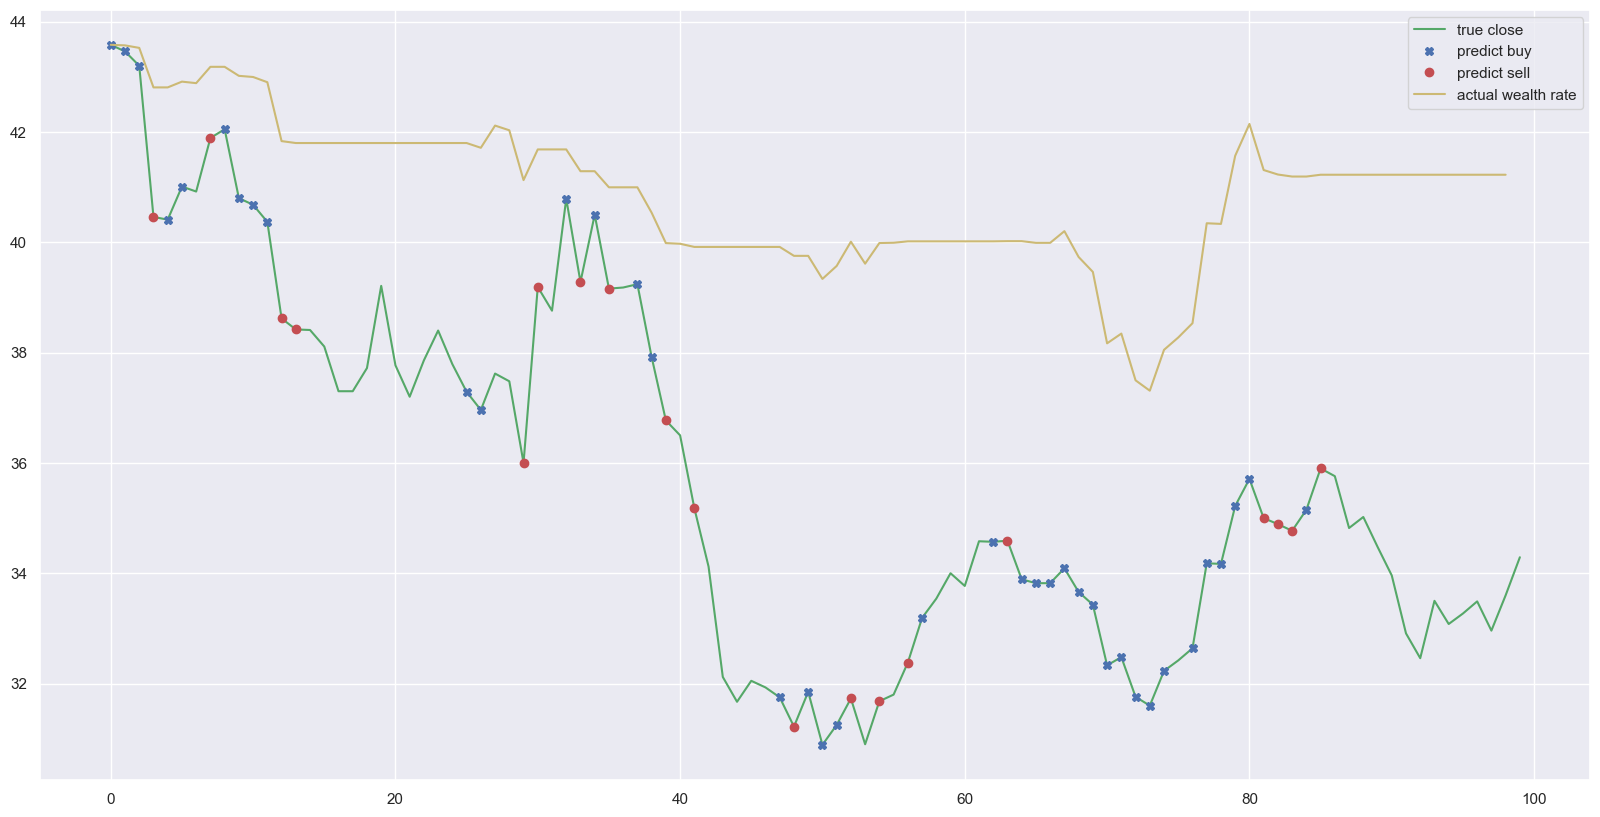

Benchmark rate is  -0.21317117944011013


In [63]:
whole_test('688558.SH',df1)

iter 10. reward: 1.754820
iter 20. reward: 3.519300
iter 30. reward: 5.730010
iter 40. reward: 9.094400
iter 50. reward: 15.697390
iter 60. reward: 26.616110
iter 70. reward: 28.417990
iter 80. reward: 31.049510
iter 90. reward: 38.021610
iter 100. reward: 41.824140
iter 110. reward: 35.859860
iter 120. reward: 45.328510
iter 130. reward: 48.525480
iter 140. reward: 37.442940
iter 150. reward: 51.621650
iter 160. reward: 25.471290
iter 170. reward: 24.910610
iter 180. reward: 51.751770
iter 190. reward: 52.441050
iter 200. reward: 52.384480
iter 210. reward: 51.601220
iter 220. reward: 31.993200
iter 230. reward: 55.661140
iter 240. reward: 55.250000
iter 250. reward: 53.019260
iter 260. reward: 53.084200
iter 270. reward: 54.897210
iter 280. reward: 53.706280
iter 290. reward: 53.510610
iter 300. reward: 53.695540
iter 310. reward: 55.060660
iter 320. reward: 54.306230
iter 330. reward: 55.095800
iter 340. reward: 55.776330
iter 350. reward: 56.363040
iter 360. reward: 56.633480
iter 

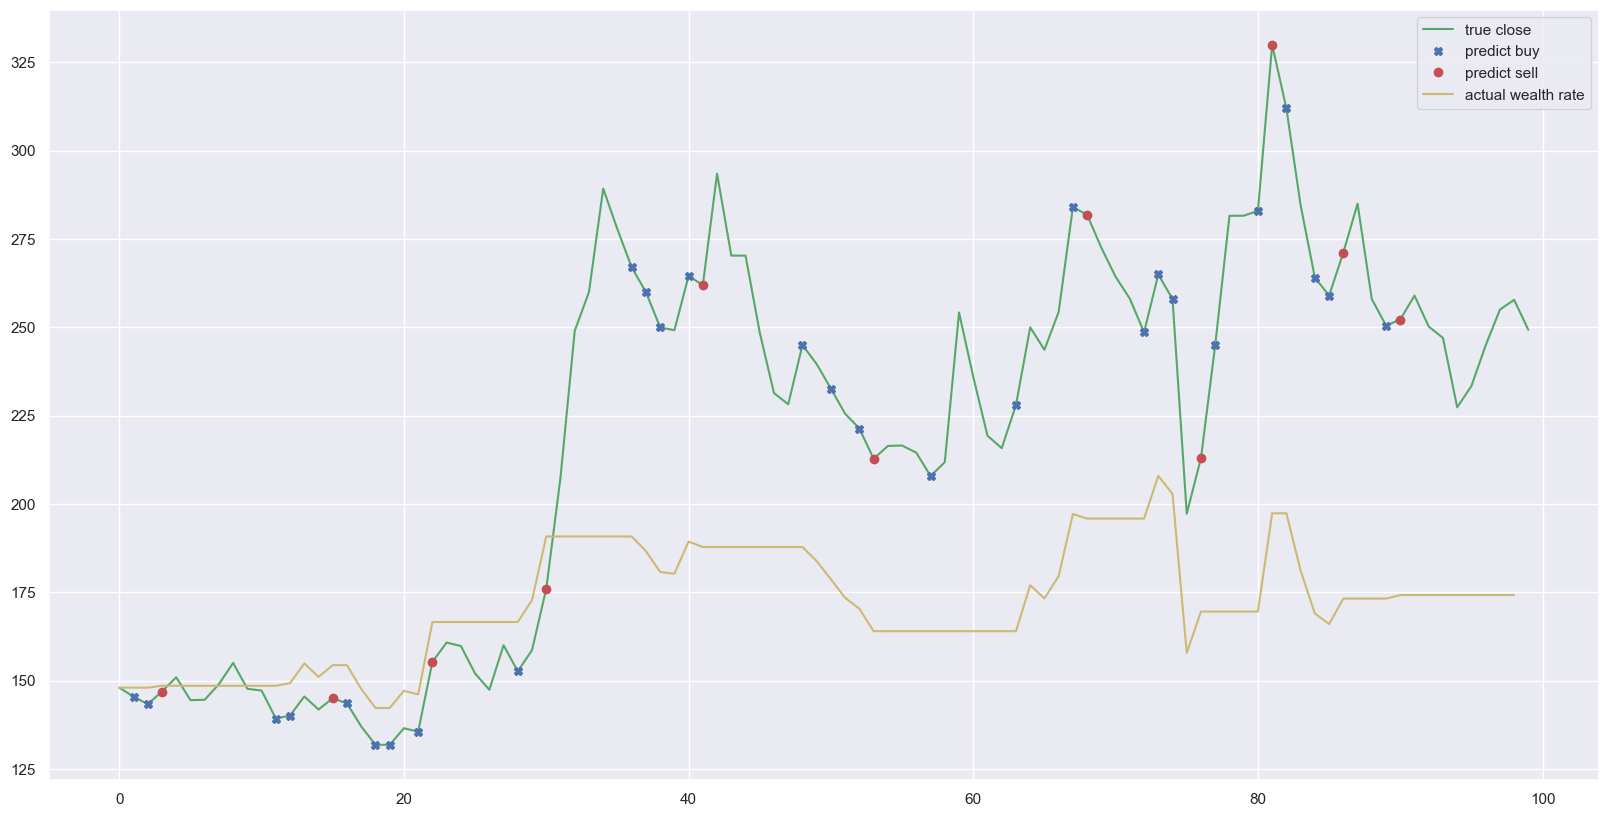

Benchmark rate is  0.6845519664819572


In [68]:
whole_test('688498.SH',df1)

iter 10. reward: 5.969500
iter 20. reward: 11.393290
iter 30. reward: 18.988210
iter 40. reward: 37.133250
iter 50. reward: 44.372380
iter 60. reward: 69.427550
iter 70. reward: 70.674480
iter 80. reward: 67.778950
iter 90. reward: 77.439920
iter 100. reward: 78.510510
iter 110. reward: 81.051090
iter 120. reward: 85.397610
iter 130. reward: 78.520220
iter 140. reward: 87.794120
iter 150. reward: 82.736150
iter 160. reward: 83.478000
iter 170. reward: 84.957720
iter 180. reward: 89.978500
iter 190. reward: 94.529570
iter 200. reward: 98.820410
iter 210. reward: 102.097080
iter 220. reward: 107.791010
iter 230. reward: 98.748760
iter 240. reward: 111.586900
iter 250. reward: 110.140490
iter 260. reward: 111.765800
iter 270. reward: 111.473780
iter 280. reward: 112.727790
iter 290. reward: 112.991120
iter 300. reward: 115.416360
iter 310. reward: 113.293950
iter 320. reward: 116.851360
iter 330. reward: 116.343490
iter 340. reward: 120.276120
iter 350. reward: 118.921200
iter 360. reward

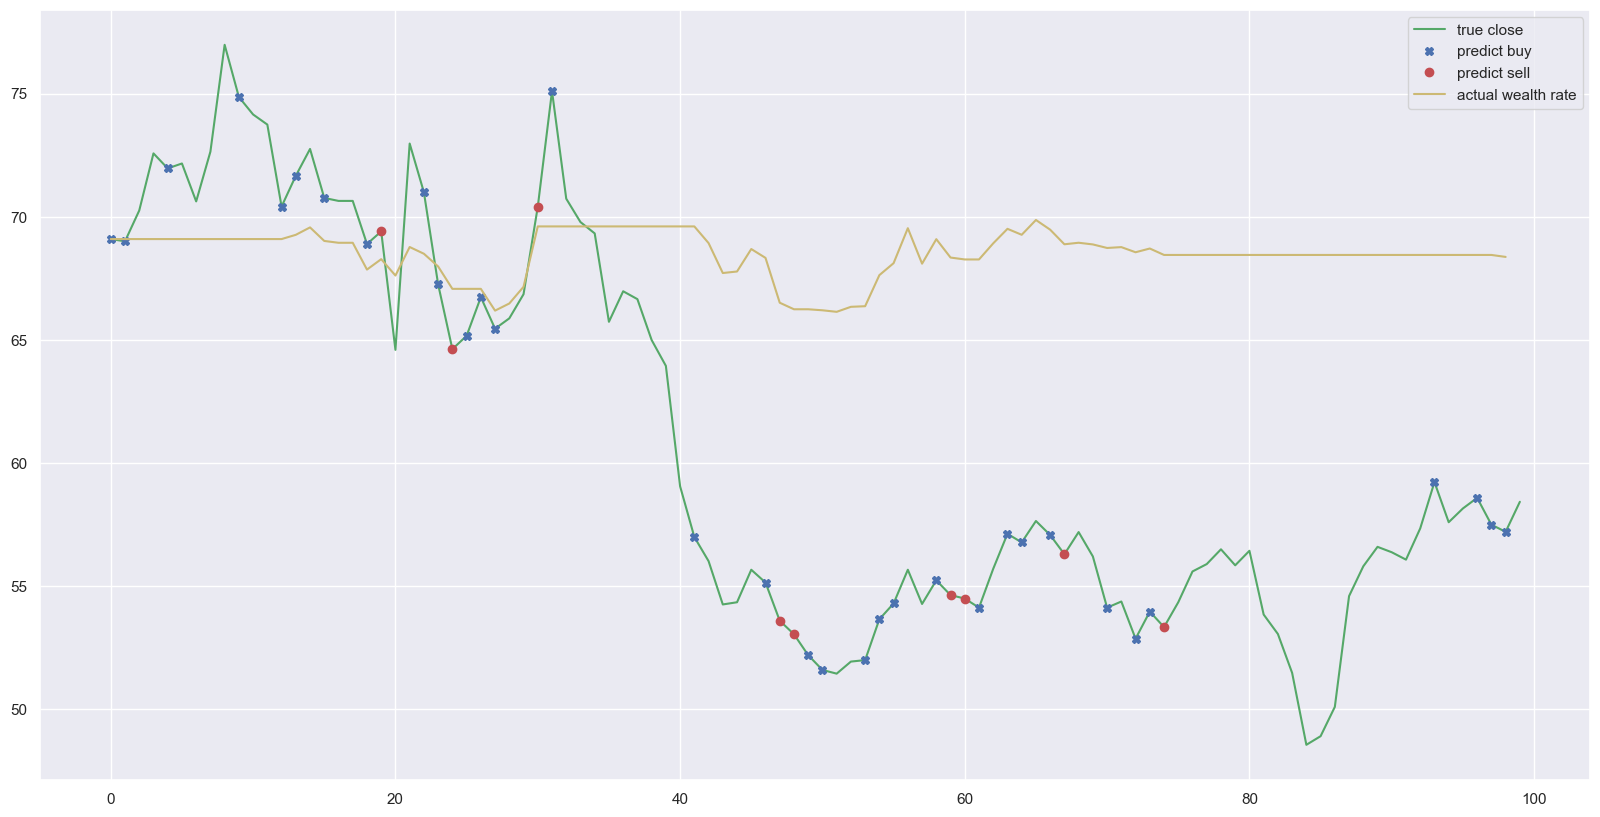

Benchmark rate is  -0.15441389290882773


In [69]:
whole_test('688385.SH',df1)

iter 10. reward: 0.624440
iter 20. reward: 2.594870
iter 30. reward: 7.976620
iter 40. reward: 13.233530
iter 50. reward: 19.959950
iter 60. reward: 25.268790
iter 70. reward: 36.345680
iter 80. reward: 40.937260
iter 90. reward: 43.986440
iter 100. reward: 47.596150
iter 110. reward: 44.477020
iter 120. reward: 49.118790
iter 130. reward: 47.956920
iter 140. reward: 47.934190
iter 150. reward: 49.175370
iter 160. reward: 50.006790
iter 170. reward: 43.611520
iter 180. reward: 46.889300
iter 190. reward: 50.305150
iter 200. reward: 53.798150
iter 210. reward: 55.896800
iter 220. reward: 55.467750
iter 230. reward: 56.434500
iter 240. reward: 58.148260
iter 250. reward: 59.259360
iter 260. reward: 59.054630
iter 270. reward: 59.511200
iter 280. reward: 59.300320
iter 290. reward: 59.579210
iter 300. reward: 60.086850
iter 310. reward: 59.962020
iter 320. reward: 61.381090
iter 330. reward: 61.291300
iter 340. reward: 36.024660
iter 350. reward: 60.677630
iter 360. reward: 60.873650
iter

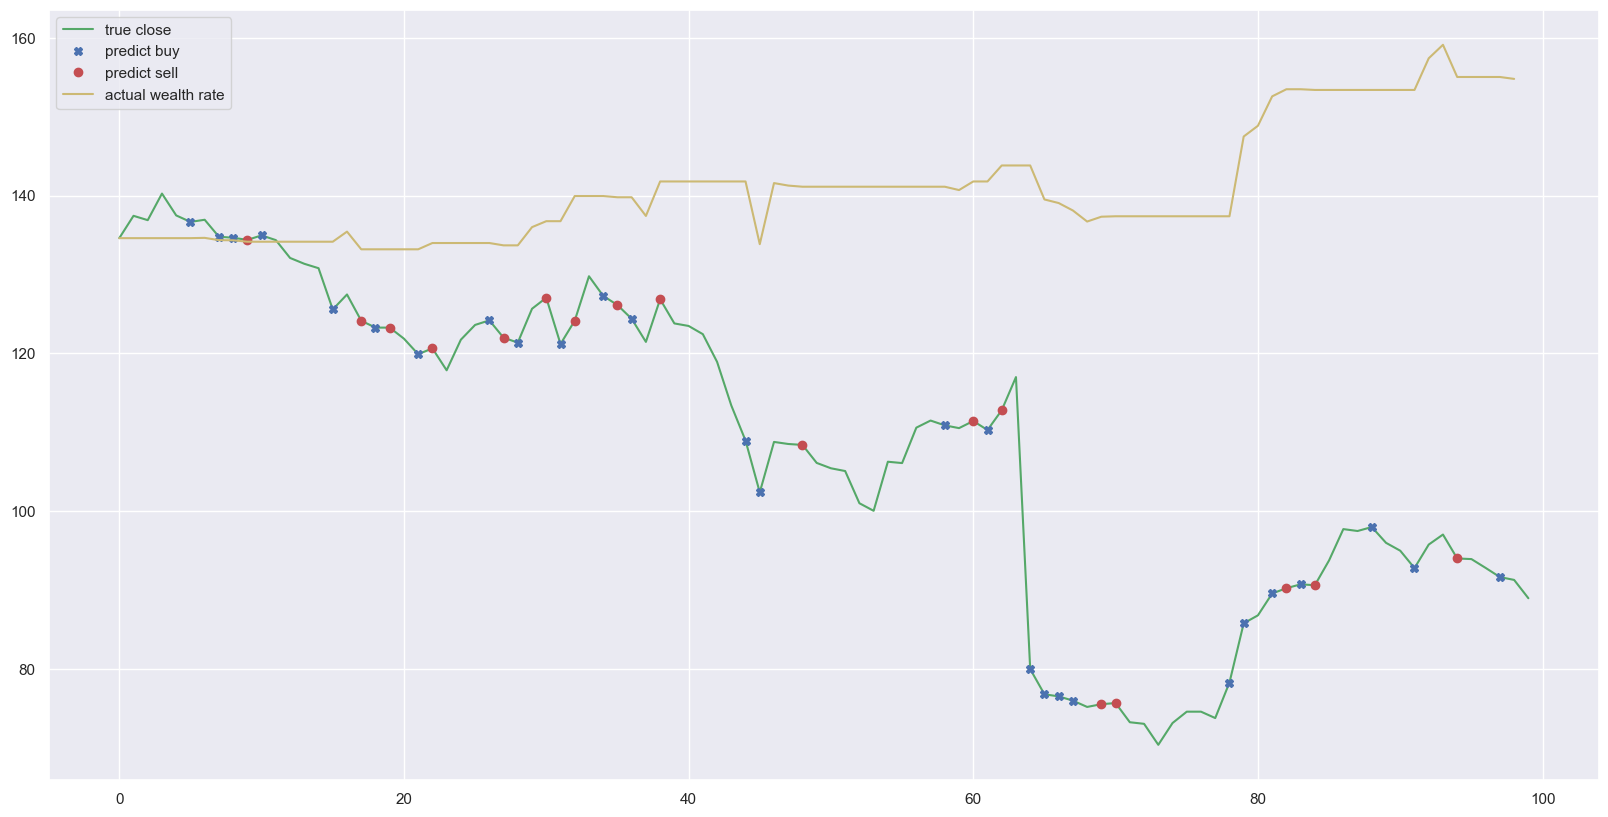

Benchmark rate is  -0.3390283761699599


In [70]:
whole_test('688503.SH',df1)

iter 10. reward: 0.497250
iter 20. reward: 1.153740
iter 30. reward: 2.071390
iter 40. reward: 3.258770
iter 50. reward: 4.657600
iter 60. reward: 6.556470
iter 70. reward: 8.412500
iter 80. reward: 10.761160
iter 90. reward: 15.414070
iter 100. reward: 23.708280
iter 110. reward: 28.708590
iter 120. reward: 33.599270
iter 130. reward: 38.532610
iter 140. reward: 40.674750
iter 150. reward: 40.490540
iter 160. reward: 41.884360
iter 170. reward: 42.890580
iter 180. reward: 43.480740
iter 190. reward: 44.709360
iter 200. reward: 45.813660
iter 210. reward: 46.388190
iter 220. reward: 46.524570
iter 230. reward: 46.395050
iter 240. reward: 46.951460
iter 250. reward: 46.867900
iter 260. reward: 46.579950
iter 270. reward: 46.691610
iter 280. reward: 48.451800
iter 290. reward: 48.528340
iter 300. reward: 48.805280
iter 310. reward: 45.365410
iter 320. reward: 46.532030
iter 330. reward: 48.143280
iter 340. reward: 48.182460
iter 350. reward: 47.488070
iter 360. reward: 49.235680
iter 370

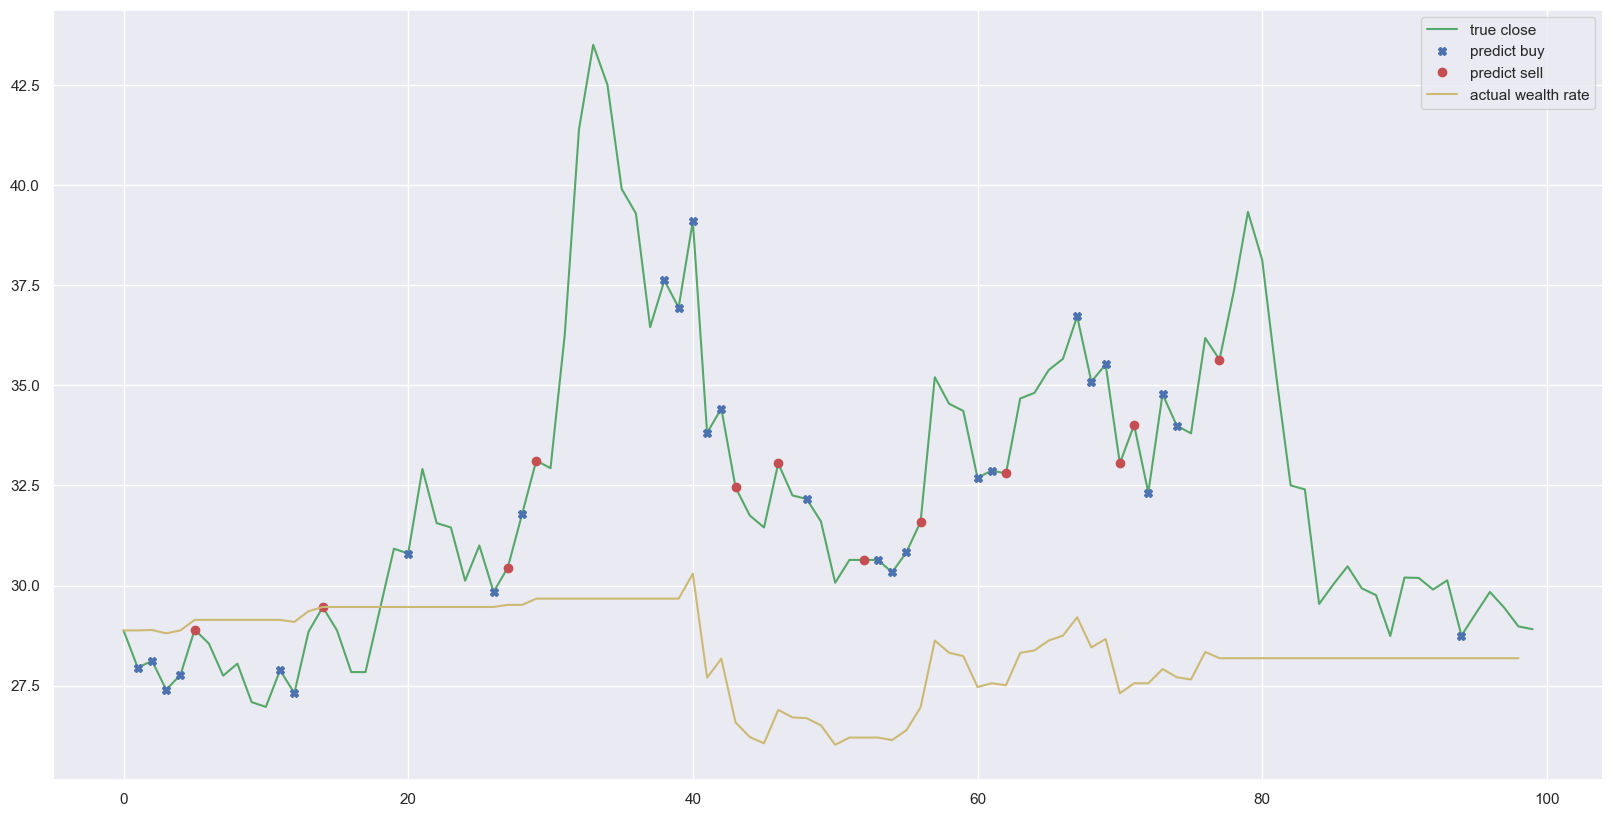

Benchmark rate is  0.0010387811634349424


In [71]:
whole_test('688400.SH',df1)

iter 10. reward: 9.746390
iter 20. reward: 17.454780
iter 30. reward: 35.509550
iter 40. reward: 48.654800
iter 50. reward: 58.700600
iter 60. reward: 77.153610
iter 70. reward: 97.852030
iter 80. reward: 112.832750
iter 90. reward: 125.068460
iter 100. reward: 146.659810
iter 110. reward: 165.113820
iter 120. reward: 164.058190
iter 130. reward: 158.770290
iter 140. reward: 171.586450
iter 150. reward: 179.128040
iter 160. reward: 188.311030
iter 170. reward: 190.395370
iter 180. reward: 192.922820
iter 190. reward: 194.593040
iter 200. reward: 198.962880
iter 210. reward: 178.136670
iter 220. reward: 207.089190
iter 230. reward: 216.577740
iter 240. reward: 217.469350
iter 250. reward: 223.502730
iter 260. reward: 233.731220
iter 270. reward: 238.410760
iter 280. reward: 210.379210
iter 290. reward: 237.644890
iter 300. reward: 240.397400
iter 310. reward: 249.861560
iter 320. reward: 254.608230
iter 330. reward: 254.810960
iter 340. reward: 267.374650
iter 350. reward: 255.592630
it

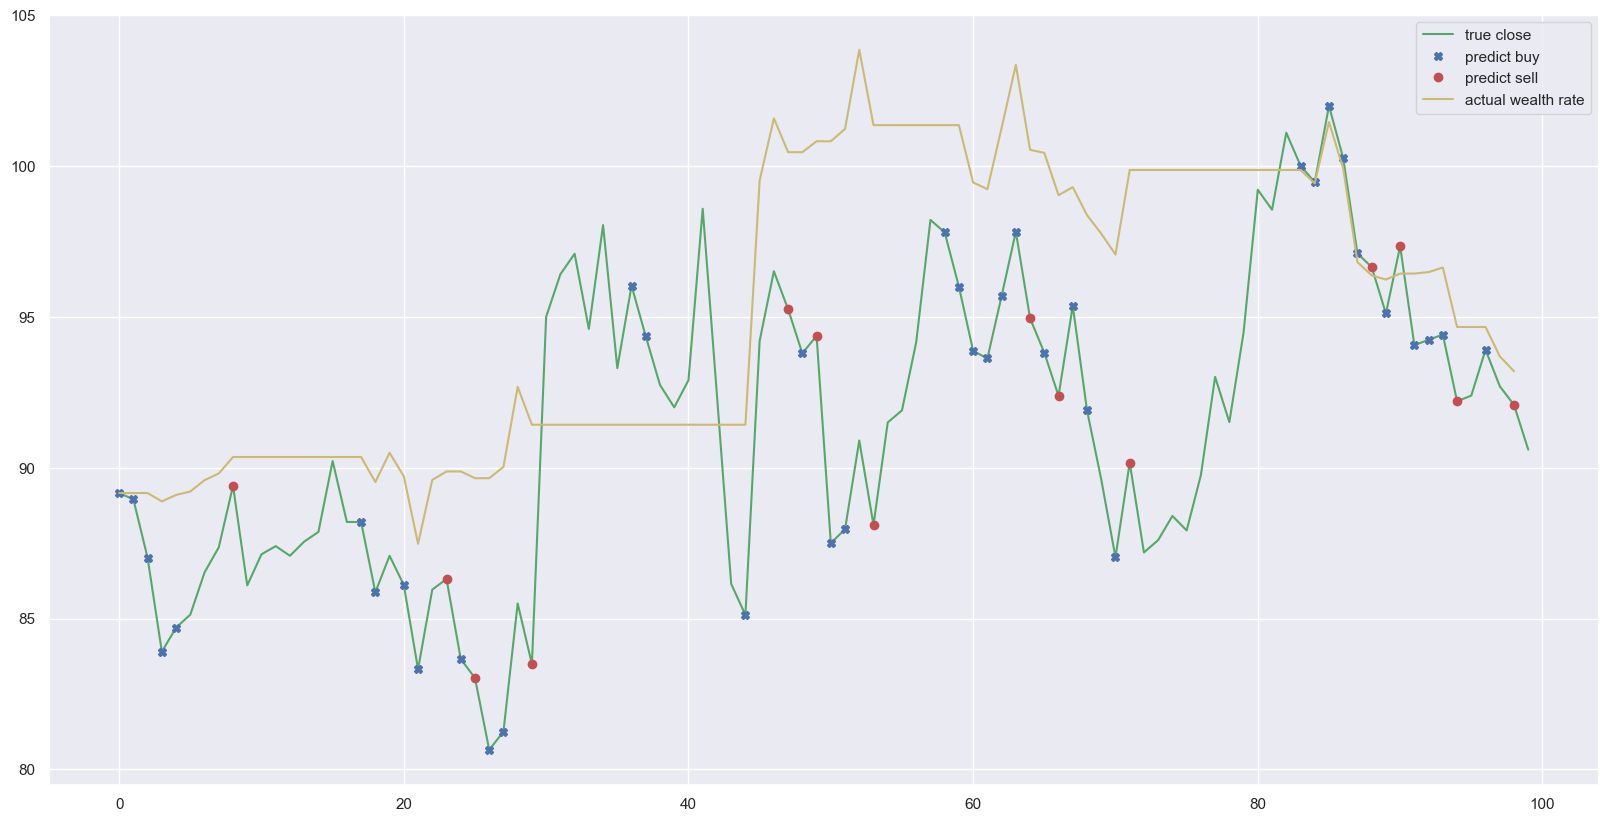

Benchmark rate is  0.01615074024226108


In [72]:
whole_test('688305.SH',df1)

iter 10. reward: 3.727290
iter 20. reward: 12.361610
iter 30. reward: 27.769940
iter 40. reward: 56.857670
iter 50. reward: 88.705370
iter 60. reward: 106.820730
iter 70. reward: 102.560090
iter 80. reward: 125.471620
iter 90. reward: 132.152690
iter 100. reward: 135.850580
iter 110. reward: 150.269520
iter 120. reward: 161.328030
iter 130. reward: 147.268300
iter 140. reward: 154.860260
iter 150. reward: 154.746960
iter 160. reward: 157.155540
iter 170. reward: 168.013180
iter 180. reward: 181.336010
iter 190. reward: 175.343430
iter 200. reward: 193.496560
iter 210. reward: 204.239780
iter 220. reward: 210.445310
iter 230. reward: 226.653120
iter 240. reward: 237.512210
iter 250. reward: 247.218230
iter 260. reward: 259.416300
iter 270. reward: 263.874440
iter 280. reward: 256.817580
iter 290. reward: 250.924540
iter 300. reward: 260.589980
iter 310. reward: 277.686950
iter 320. reward: 284.382200
iter 330. reward: 287.493080
iter 340. reward: 290.809960
iter 350. reward: 297.414000


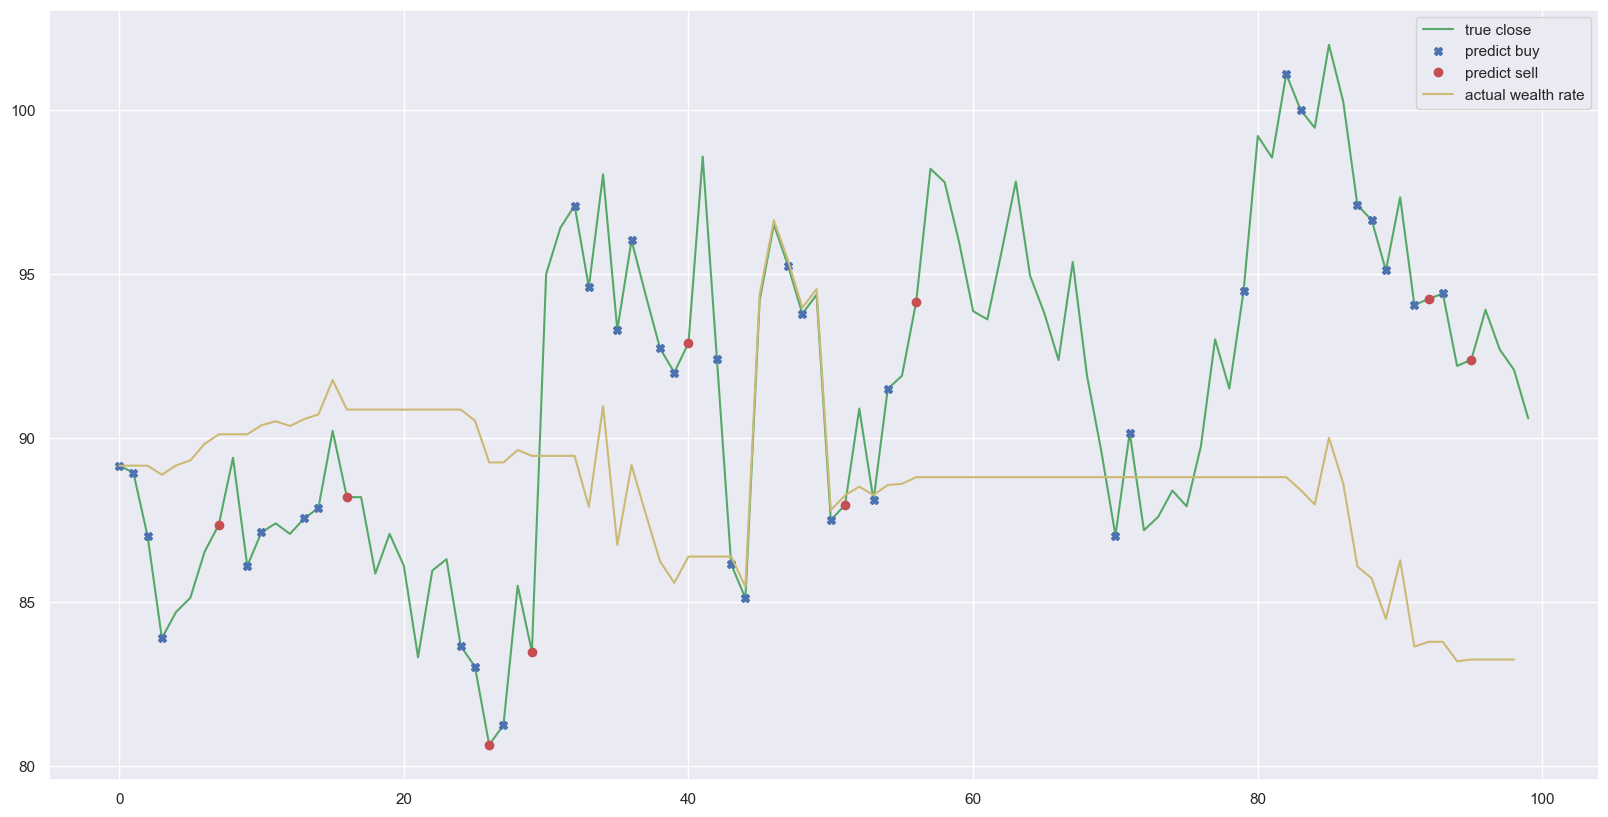

Benchmark rate is  0.01615074024226108
[array([[ 0.80944063, -0.95459453,  1.23292526,  1.61237064, -1.10309058],
       [-0.87178015,  1.0247955 , -1.74008149,  3.66635901,  0.15719684],
       [ 2.2022763 , -1.21025468,  4.09111966, -0.14595459, -1.81044891],
       [-3.55177154,  0.69121537, -1.4440075 , -0.39821962, -2.76974918],
       [-1.26045693,  0.93035812,  1.71847388,  1.03715114,  0.24162455],
       [-1.90321642, -2.65790515,  6.06832474, -5.700623  , -2.39506754],
       [-3.50514136,  1.55614764,  3.72243708,  0.19709463, -1.95375473],
       [-1.31414175,  2.3752246 ,  1.88870482, -0.48772567, -0.93200575],
       [-0.36850445, -0.44435584,  4.93920304,  1.50104992,  6.22254971],
       [-1.00261937, -0.32538693,  0.46933633,  0.40930997,  1.27414002],
       [-1.35656779, -0.6493852 ,  1.55955335,  0.05669109,  0.27517593],
       [ 0.75576715, -0.40707696,  3.36651251,  0.51787998,  0.39135172],
       [-1.18631402, -3.06836999,  2.85398537, -1.76620225,  0.2487538 ]

In [75]:
whole_test('688305.SH',df1)

iter 10. reward: 0.108320
iter 20. reward: 0.364050
iter 30. reward: 0.586180
iter 40. reward: 0.865750
iter 50. reward: 1.240030
iter 60. reward: 1.560940
iter 70. reward: 2.361390
iter 80. reward: 2.359410
iter 90. reward: 2.940260
iter 100. reward: 3.326890
iter 110. reward: 3.741470
iter 120. reward: 6.001340
iter 130. reward: 10.744030
iter 140. reward: 13.972080
iter 150. reward: 10.504630
iter 160. reward: 13.621640
iter 170. reward: 15.414640
iter 180. reward: 16.309230
iter 190. reward: 0.630950
iter 200. reward: 13.489790
iter 210. reward: 13.020800
iter 220. reward: 15.404120
iter 230. reward: 17.388400
iter 240. reward: 18.932330
iter 250. reward: 21.192260
iter 260. reward: 23.455990
iter 270. reward: 23.459490
iter 280. reward: 25.854290
iter 290. reward: 26.842960
iter 300. reward: 22.094750
iter 310. reward: 32.010530
iter 320. reward: 34.844820
iter 330. reward: 36.931120
iter 340. reward: 36.325640
iter 350. reward: 37.680840
iter 360. reward: 38.782090
iter 370. rewa

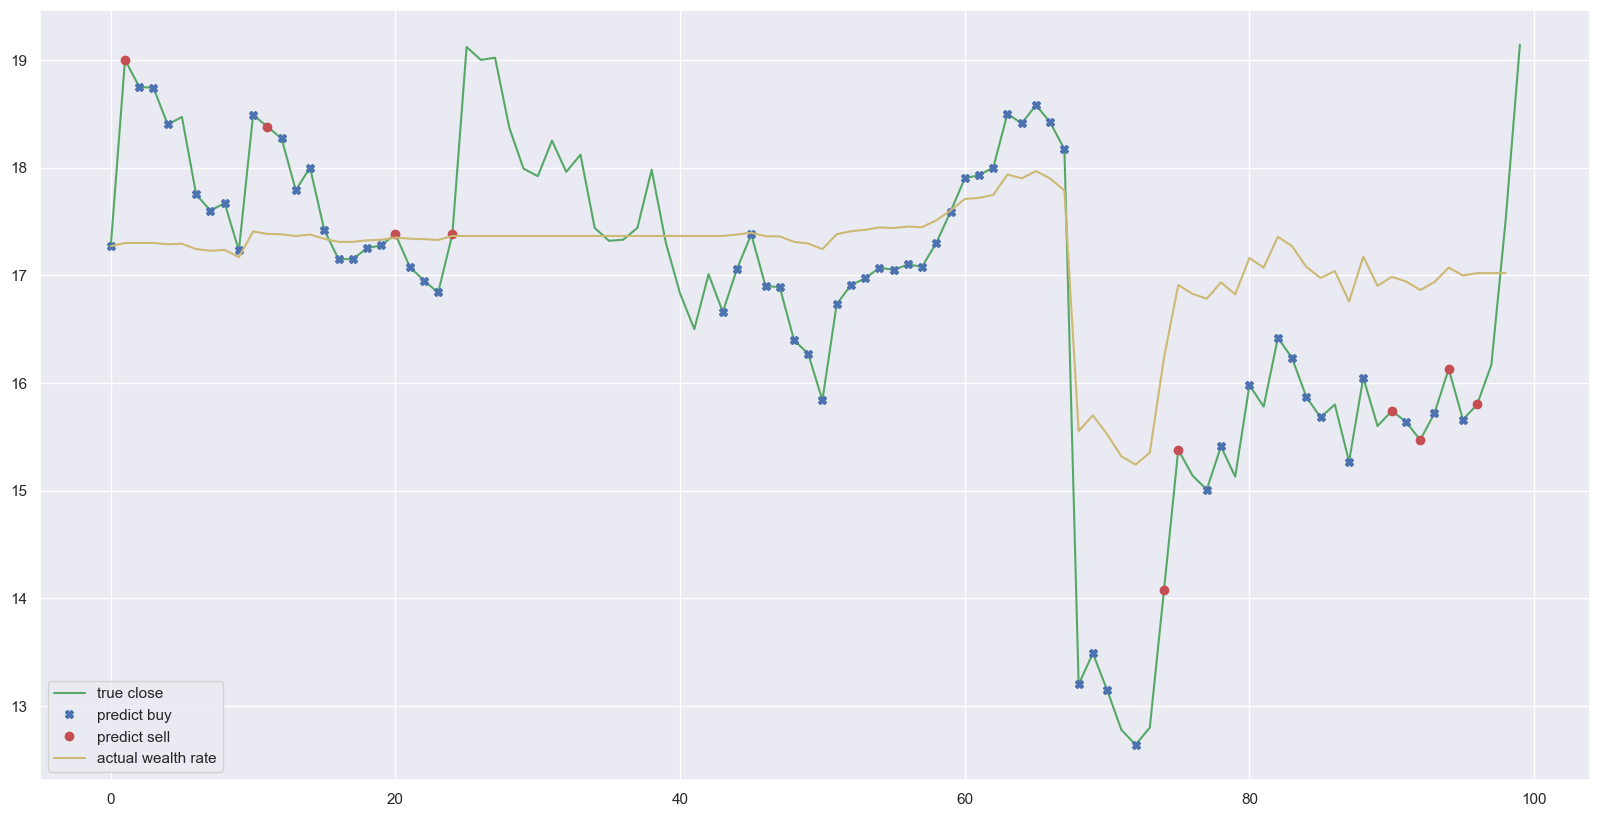

Benchmark rate is  0.10828025477707012
[array([[-0.24615559,  1.07651211,  0.3034096 , -0.71991792,  1.14116053],
       [-3.41924851, -0.64048494, -0.15943293, -1.46517401,  1.47995423],
       [ 1.45183217,  1.99099571, -0.10724164, -1.4493016 ,  0.10370458],
       [-0.9940443 , -0.65883216, -0.58392234,  4.17319557, -1.65176169],
       [ 3.91859622,  1.16623426,  0.08315688,  1.84300216,  4.02139916],
       [ 0.7831919 , -5.37545817,  0.96752741,  4.14255181,  0.56645632],
       [ 1.74535679,  0.58322222,  0.41546702, -2.99963182, -2.21021328],
       [ 5.77655258,  1.4405579 ,  3.33196465,  0.0930074 , -0.3531596 ],
       [-2.32302844,  4.17823457, -3.12714687, -2.67563534,  0.77102236],
       [ 3.01929034,  1.69239785,  1.53549029,  1.92007511, -2.05344458],
       [-1.45177951, -1.89594644, -1.24045623, -1.19832625, -0.75357385],
       [-3.16243173, -0.09113387, -3.27363071,  0.09566755,  0.46566743],
       [-2.00344188, -1.73332496, -1.54156009, -1.15054514,  0.92511747]

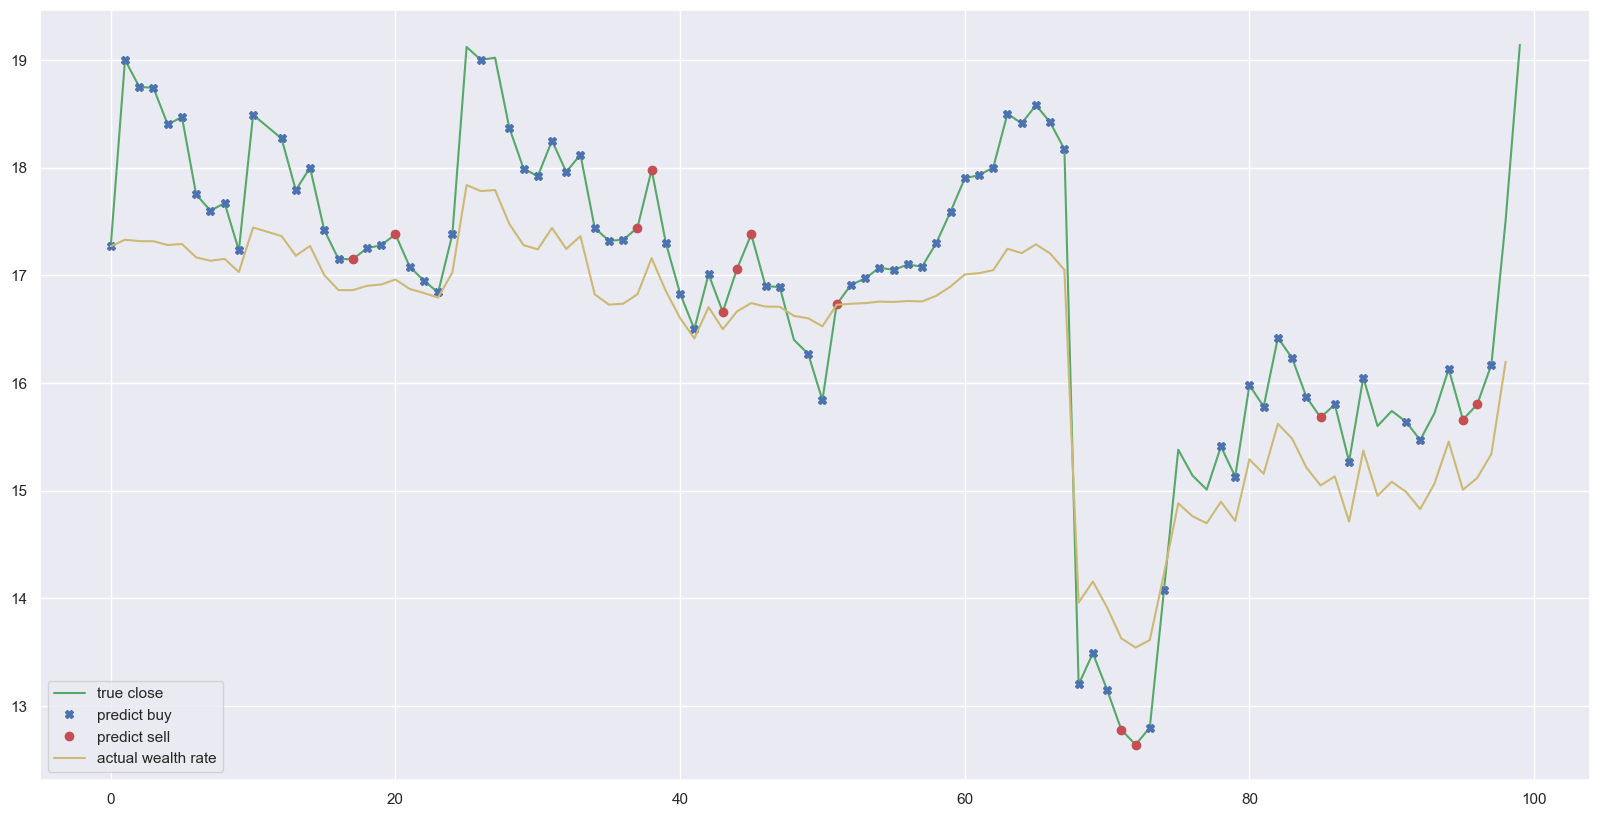

Benchmark rate is  0.10828025477707012
[array([[ 1.1135006 , -0.18064488,  2.23418457,  0.0909167 , -1.86595822],
       [ 1.12815282, -1.58886426, -1.35893527, -1.08287934, -0.90327105],
       [-0.76992954, -0.05638943,  0.95689788,  1.44897862, -1.94158149],
       [ 3.01730315,  3.48259051, -5.42831598,  2.1698993 ,  1.94999742],
       [-0.7169712 ,  0.77487287, -0.44061638,  0.64906802, -2.99230115],
       [-1.90438709,  5.03098575, -1.52949869,  0.48657942,  3.80606731],
       [ 4.93649704,  0.02354595, -2.64302656,  1.8329772 ,  4.22047738],
       [ 0.43074769, -0.77420087, -0.91009423,  2.42734491, -3.72598406],
       [-2.92895159, -4.1078639 , -0.37908865,  3.82619026, -1.61564668],
       [-1.78490881,  2.25787406, -0.18002426,  2.81686875,  3.31873026],
       [-2.44911957,  1.60704324,  1.78821685,  3.09009433, -1.85334378],
       [-2.35897173,  1.10923021, -3.00457425,  0.6969673 ,  2.5696371 ],
       [-1.75841402, -0.7976618 , -0.40428706, -1.21105769,  0.22375012]

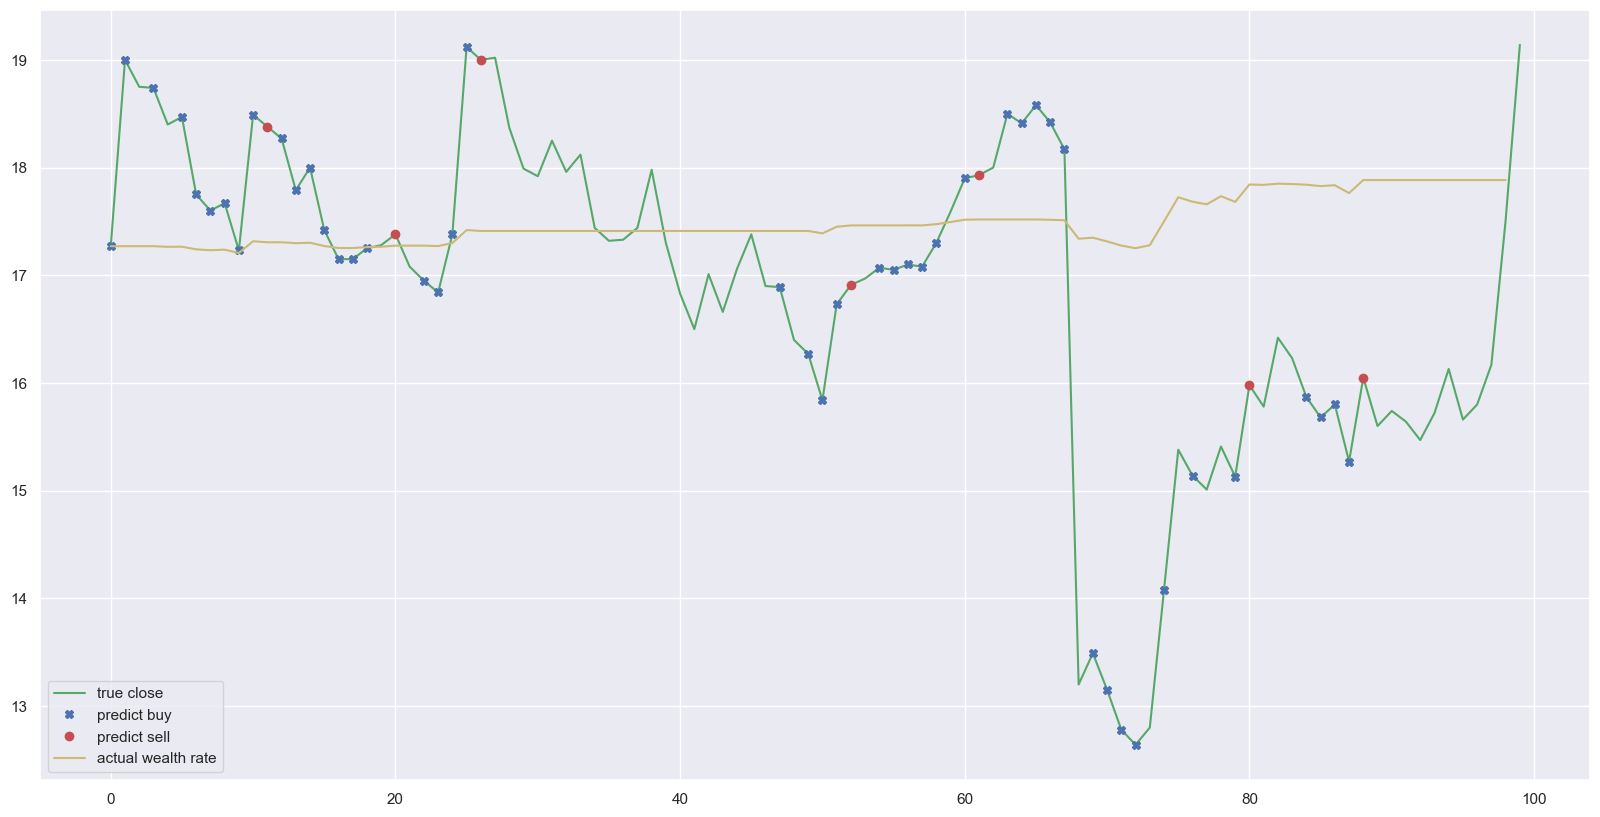

Benchmark rate is  0.10828025477707012
[array([[ 2.52381283, -0.50750079,  1.72705282, -2.67810732,  2.29174121],
       [-0.60806927, -1.92984778, -1.22152916, -0.01362209, -0.88121189],
       [ 1.83232101,  2.37564584, -0.74764141, -0.98563764, -0.76466949],
       [ 2.08432497, -3.30894095, -0.28588998,  3.23741612, -5.51435711],
       [ 1.93068137,  1.9232037 ,  3.69890238, -0.86970219, -0.29570277],
       [-2.35281884,  0.69572678,  1.86847079, -3.06043757,  1.19650553],
       [ 1.03283467,  1.73018415, -2.75035534, -3.60944063, -1.55844961],
       [ 3.29276965, -0.50675355,  0.39708021,  1.46033799, -0.74353648],
       [-1.91831418,  1.77704041, -0.60679129, -2.24969834,  0.48430139],
       [-3.15227431,  0.56344582, -0.71352765,  0.38220898, -0.3273674 ],
       [ 2.18673192, -0.6698935 ,  0.30848667, -2.89902709, -1.49266796],
       [ 0.94816183, -0.0835311 , -3.27835528,  3.49017162,  1.63017129],
       [ 1.42047151, -0.52558473,  0.10356716, -1.03472946,  0.13016782]

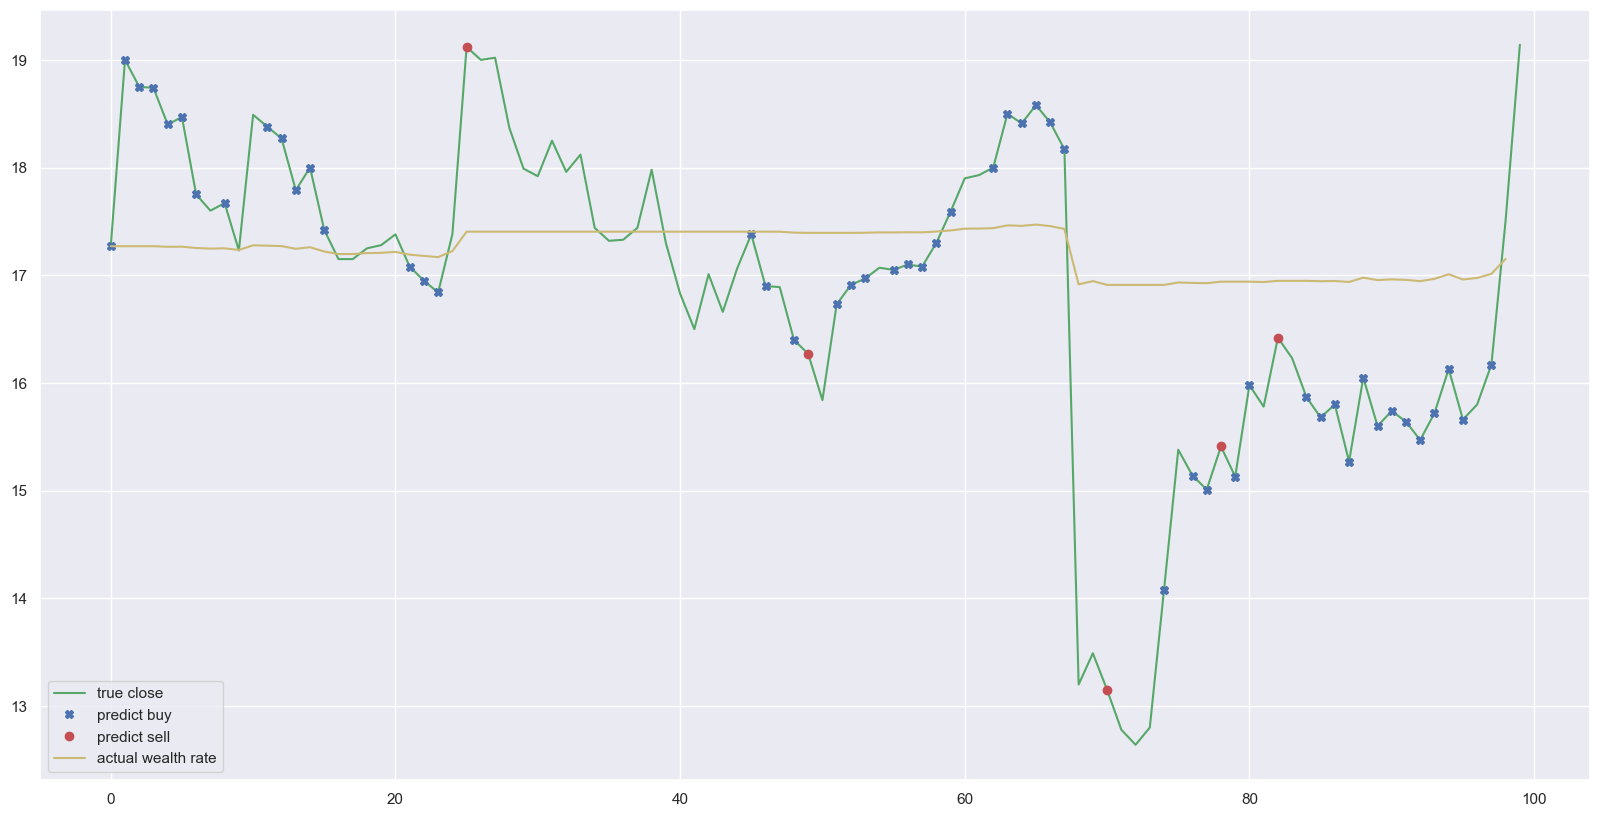

Benchmark rate is  0.10828025477707012
[array([[ 1.11616895, -0.41964568,  3.87919232, -0.77548682,  3.84822112],
       [-0.62169816, -2.74499016,  3.02435915, -3.0300726 ,  0.81754645],
       [ 1.12719048,  0.25167577, -0.16011667,  3.58455053, -0.14769244],
       [ 1.29651847, -0.20136931,  0.63081411, -0.29578339,  2.31891727],
       [-0.54472271,  1.26695463, -3.0028834 , -0.78053884,  1.56379693],
       [ 0.53491227,  1.98867397, -0.44823045, -2.29210292,  3.54273399],
       [ 0.26579409,  1.91638309, -1.00504636,  3.30388047,  0.37175459],
       [ 5.08376409, -1.00439566,  0.25099925,  0.54953658,  0.87771455],
       [ 3.29160307, -1.34708651, -1.31396573, -1.41292276,  1.25692105],
       [-0.18708058, -0.71173443, -0.04512178, -0.54985331,  1.37649119],
       [-1.17278375,  2.36263096, -1.37104367, -1.02093151,  4.00467697],
       [ 3.14248596,  1.61953613, -1.56919605, -1.00896495,  2.10393531],
       [-0.8762152 , -1.34590136, -0.2990011 ,  4.11170642,  5.81042034]

KeyboardInterrupt: 

In [11]:
whole_comparision_test('603730.SH',df1)

iter 10. reward: 0.072080
iter 20. reward: 0.099260
iter 30. reward: 0.112620
iter 40. reward: 0.133160
iter 50. reward: 0.165280
iter 60. reward: 0.213600
iter 70. reward: 0.481080
iter 80. reward: 1.077350
iter 90. reward: 2.251620
iter 100. reward: 3.386320
iter 110. reward: 4.230050
iter 120. reward: 6.083020
iter 130. reward: 6.794620
iter 140. reward: 7.069550
iter 150. reward: 9.945020
iter 160. reward: 11.390530
iter 170. reward: 12.452180
iter 180. reward: 14.379060
iter 190. reward: 16.687960
iter 200. reward: 17.912890
iter 210. reward: 19.367560
iter 220. reward: 21.659070
iter 230. reward: 23.223950
iter 240. reward: 24.050120
iter 250. reward: 25.186790
iter 260. reward: 26.893960
iter 270. reward: 25.779020
iter 280. reward: 26.952940
iter 290. reward: 27.706530
iter 300. reward: 28.139470
iter 310. reward: 17.640860
iter 320. reward: 29.821880
iter 330. reward: 30.267500
iter 340. reward: 30.454300
iter 350. reward: 28.761120
iter 360. reward: 31.230730
iter 370. reward

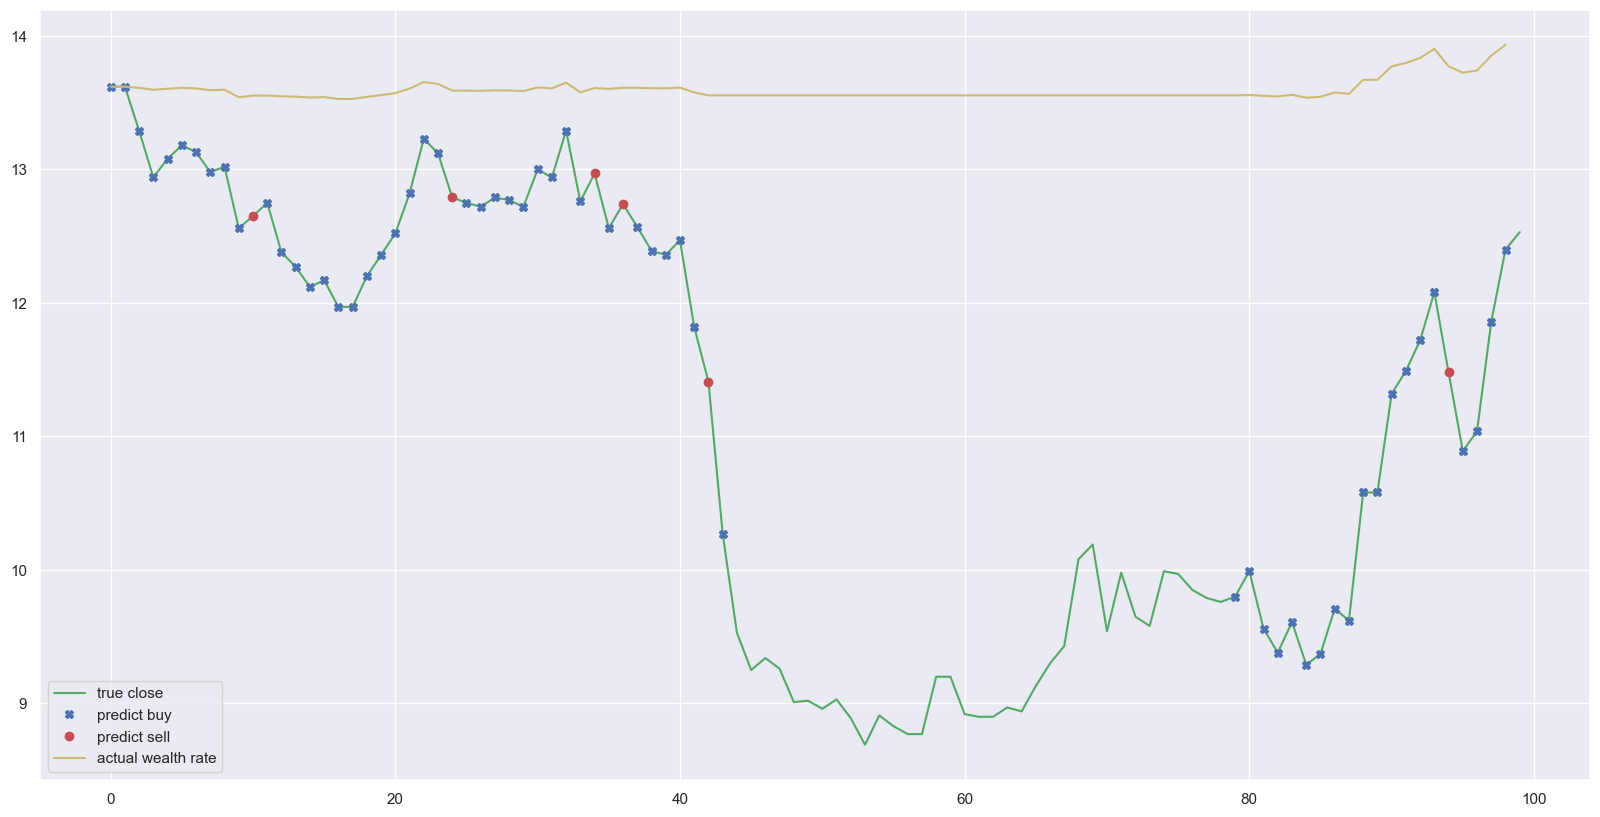

Benchmark rate is  -0.08002936857562408
[array([[-0.78193373, -2.94313375, -0.15922187,  2.36768421,  0.6356679 ],
       [-1.78473117,  2.00162795, -3.74347151,  2.71656525,  1.63157319],
       [-2.38241031,  0.40627818, -2.02158739, -2.88345817,  0.11851158],
       [ 0.98341513,  0.62789081,  6.56512315, -1.24533073,  0.9678075 ],
       [-0.11734161,  1.9019162 ,  1.41397615, -0.97545032, -5.16036204],
       [ 1.86183834,  1.44624039, -0.83270029, -2.80457224,  1.88342371],
       [ 1.06477474, -1.68419434,  1.48154949, -0.36162513,  4.77496071],
       [ 2.97247799, -2.28391606,  0.8632763 , -4.76477805,  0.6052643 ],
       [-0.77169757, -2.59866924, -1.63402193, -0.52680598,  0.49803654],
       [-2.84236958,  1.5277978 ,  3.30040988, -0.0069004 ,  0.63184292],
       [-1.96259455, -0.26608404, -0.24651162, -0.70915885, -2.18227022],
       [-0.80419935, -0.58250163,  1.35798684, -2.42111648, -0.97810304],
       [ 0.24448496,  1.45566132, -2.63121664, -3.59646001,  2.20304921

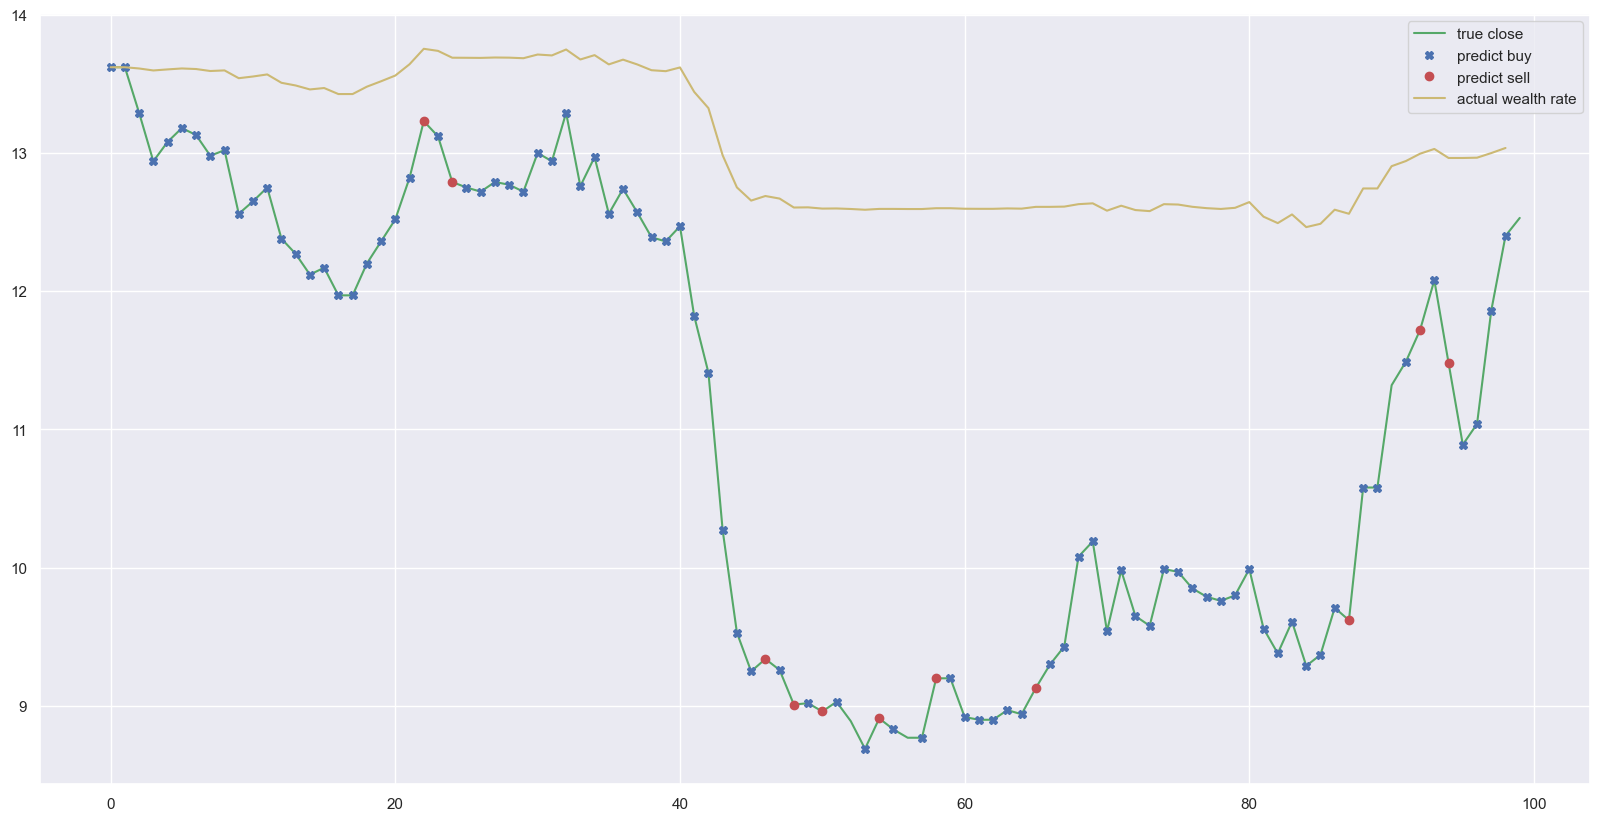

Benchmark rate is  -0.08002936857562408
[array([[-0.07757195,  2.11261086, -2.0890022 , -0.47375905,  4.43317773],
       [ 4.06201868, -0.18332533, -1.4686895 ,  0.69512554, -2.1367977 ],
       [ 1.70324764, -3.49732569, -2.11081345,  2.32254884, -2.93923311],
       [-0.8198563 , -1.64334614, -0.06987902, -4.78182101,  3.41860815],
       [ 3.27430979, -3.97699342,  0.65067126,  0.41473678,  0.81180639],
       [-0.3158834 , -0.76958849,  1.3699539 ,  0.01045136, -0.14596482],
       [-3.42896907,  0.61854606,  1.8093593 ,  0.4145634 ,  2.13902096],
       [-1.58933026, -0.02187519, -2.82102908,  1.54358301,  2.13535811],
       [ 0.401576  ,  1.51251708,  1.75427767,  3.45866618, -1.03799237],
       [ 0.89699304, -3.17625275,  0.84906301, -2.72745471, -2.01965411],
       [ 3.52996636,  0.74854173, -2.18256249,  1.06213807,  0.46319237],
       [ 2.08111271,  1.52756549, -1.59204877,  2.18652979, -0.19927397],
       [-1.20613105, -1.81733312, -2.53530431,  5.51830437,  0.24213769

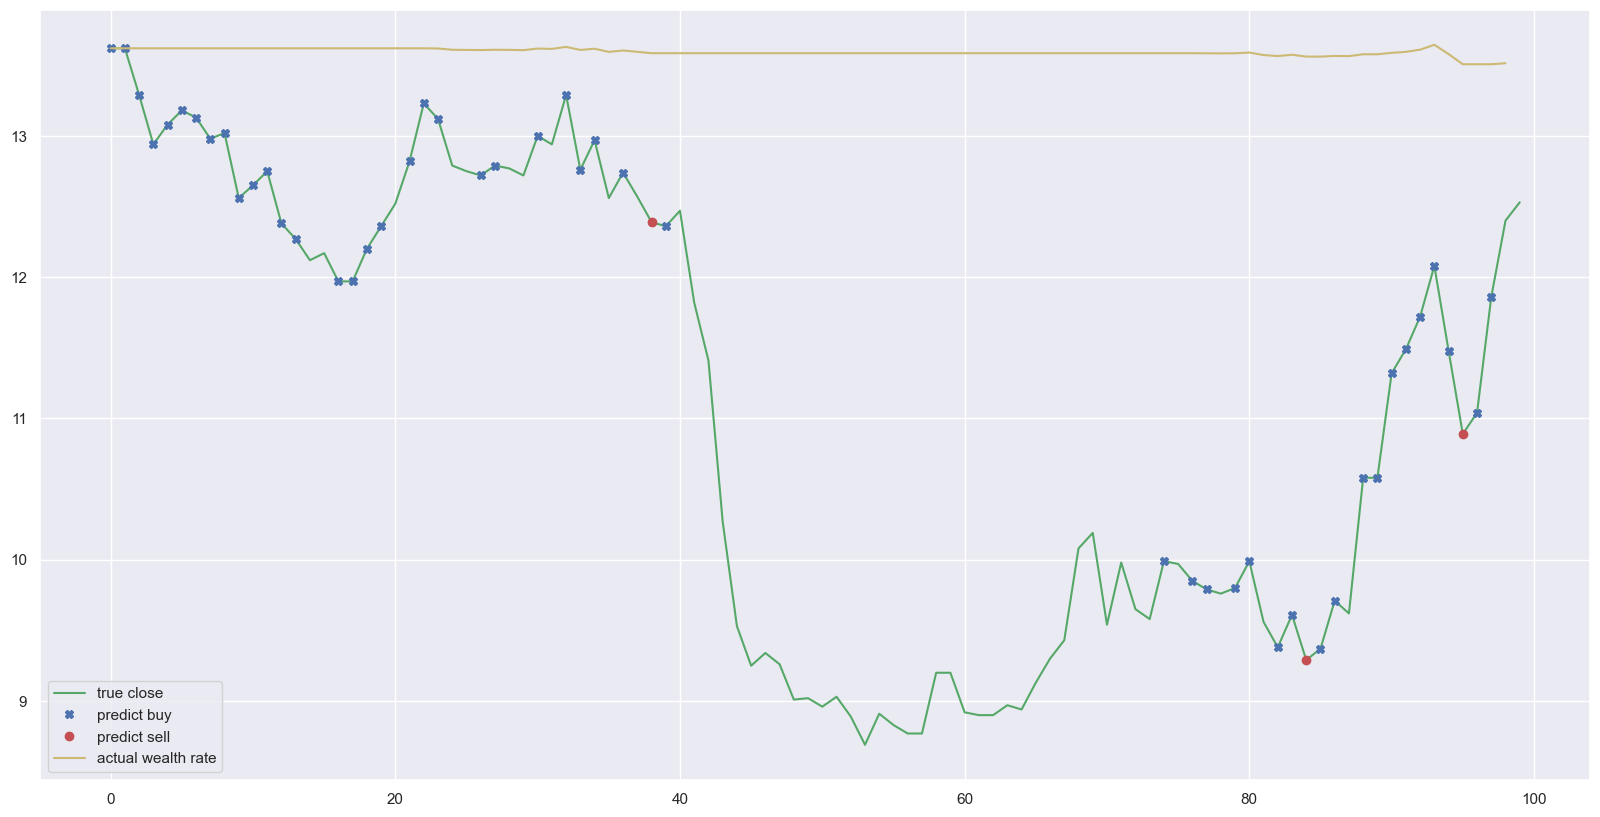

Benchmark rate is  -0.08002936857562408
[array([[-1.75307349, -0.78018792,  0.51004913, -1.91755288, -4.14949449],
       [-3.29419055,  0.67530868,  2.33200768, -1.72646746, -5.53382172],
       [-1.08395201, -5.69596103,  1.20604327, -0.05689004, -1.93051788],
       [-5.59499115,  0.40765174, -0.22863036,  0.08419878, -1.69097559],
       [ 1.13034465,  1.24036281,  4.83453272, -1.02631986, -0.90526651],
       [-2.2334749 , -2.33075712, -3.79795515, -0.89912895, -0.3725575 ],
       [-2.43808498, -5.45871346,  1.64326589, -2.35931514, -2.73758201],
       [-1.84649263,  1.93453185, -1.2844026 ,  0.58982149, -1.41612604],
       [ 0.96339278, -2.54439596,  3.68616394,  0.48665575, -1.21476163],
       [-1.21172598, -0.08735672,  1.61242998, -1.73312469,  3.49030928],
       [ 0.97883252, -0.84998008,  1.3595464 , -0.22960301,  0.44349919],
       [-2.08077254, -2.61621619,  1.36592811, -1.59093546, -3.47194519],
       [-2.10280851,  1.17226431,  4.19780945, -0.1224194 , -1.94477697

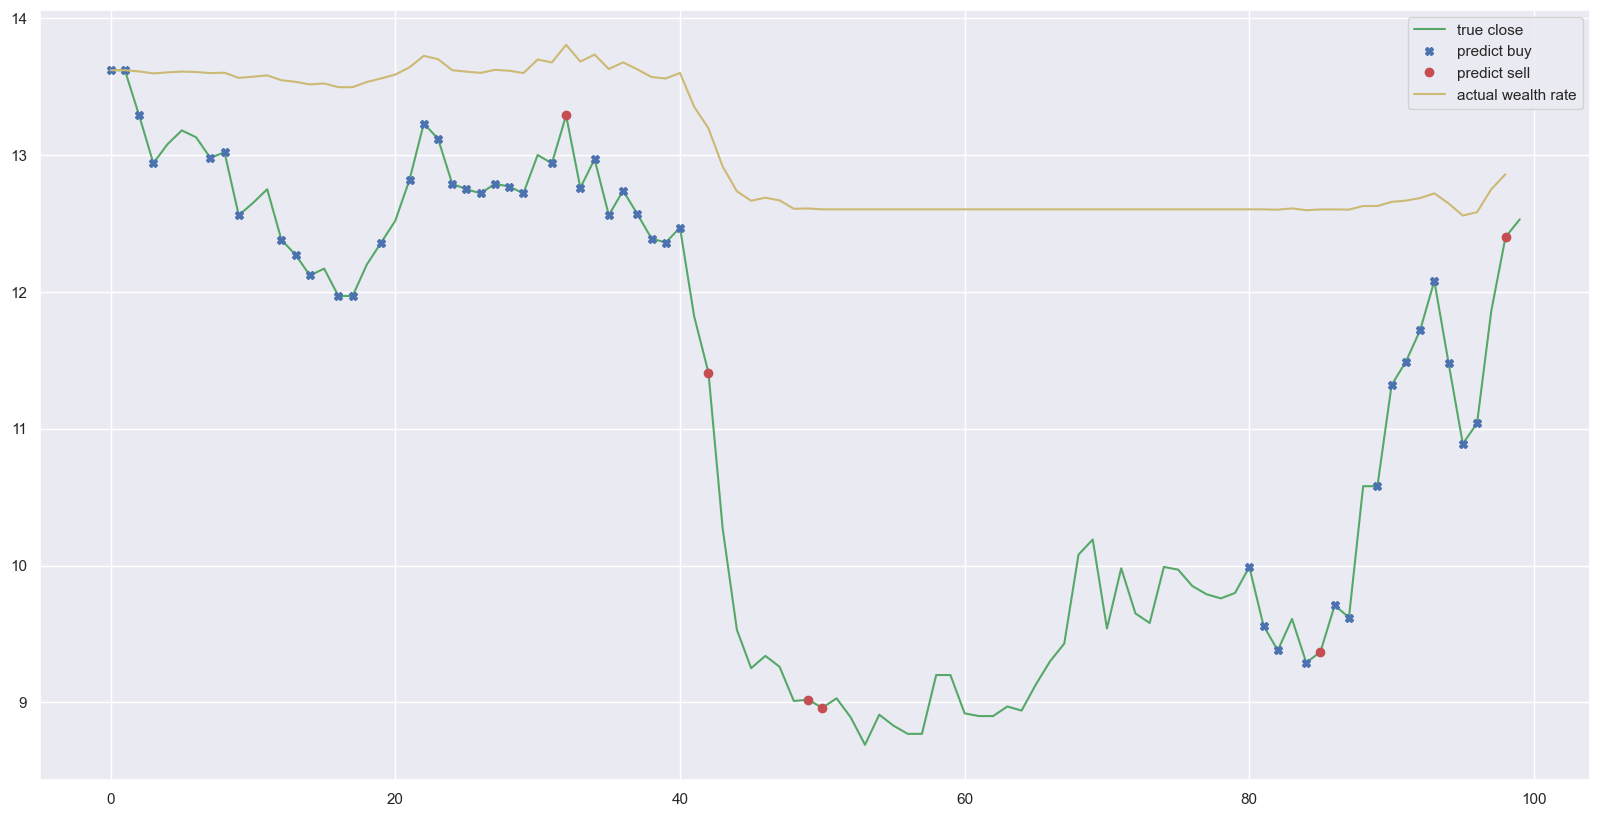

Benchmark rate is  -0.08002936857562408
[array([[-0.07675047, -1.84490679,  0.49694049, -0.59690211,  0.43714371],
       [ 1.24723552,  2.15504443,  0.07121395, -2.19739101,  0.72589329],
       [ 1.72840126,  3.40813624,  0.95067544,  1.9584828 ,  3.17648352],
       [-3.78266496, -0.75497428,  2.78208038, -0.2715719 ,  4.22460116],
       [-2.60574453, -0.7336353 ,  0.24550118, -0.49586769,  2.11274754],
       [ 3.37237251, -2.02410335,  0.72419573,  2.06096492,  3.53730072],
       [ 1.69654469, -2.00061601, -1.27254116,  2.62466752,  0.4456787 ],
       [ 0.2078292 ,  2.18383619,  3.78564261, -3.41836081,  0.78772066],
       [-1.5612267 ,  0.20462334,  3.27010905,  2.18935941, -5.30849743],
       [ 1.87200602,  2.25310038, -0.80784105,  0.1421095 ,  0.12497015],
       [ 0.94171975,  1.00526466, -0.95074092, -0.16462579, -0.87958152],
       [ 2.77718262,  1.09434126, -0.82579723, -0.82621643, -2.67429721],
       [-0.8810075 ,  2.10312591, -1.31003182, -4.01508993, -1.22025892

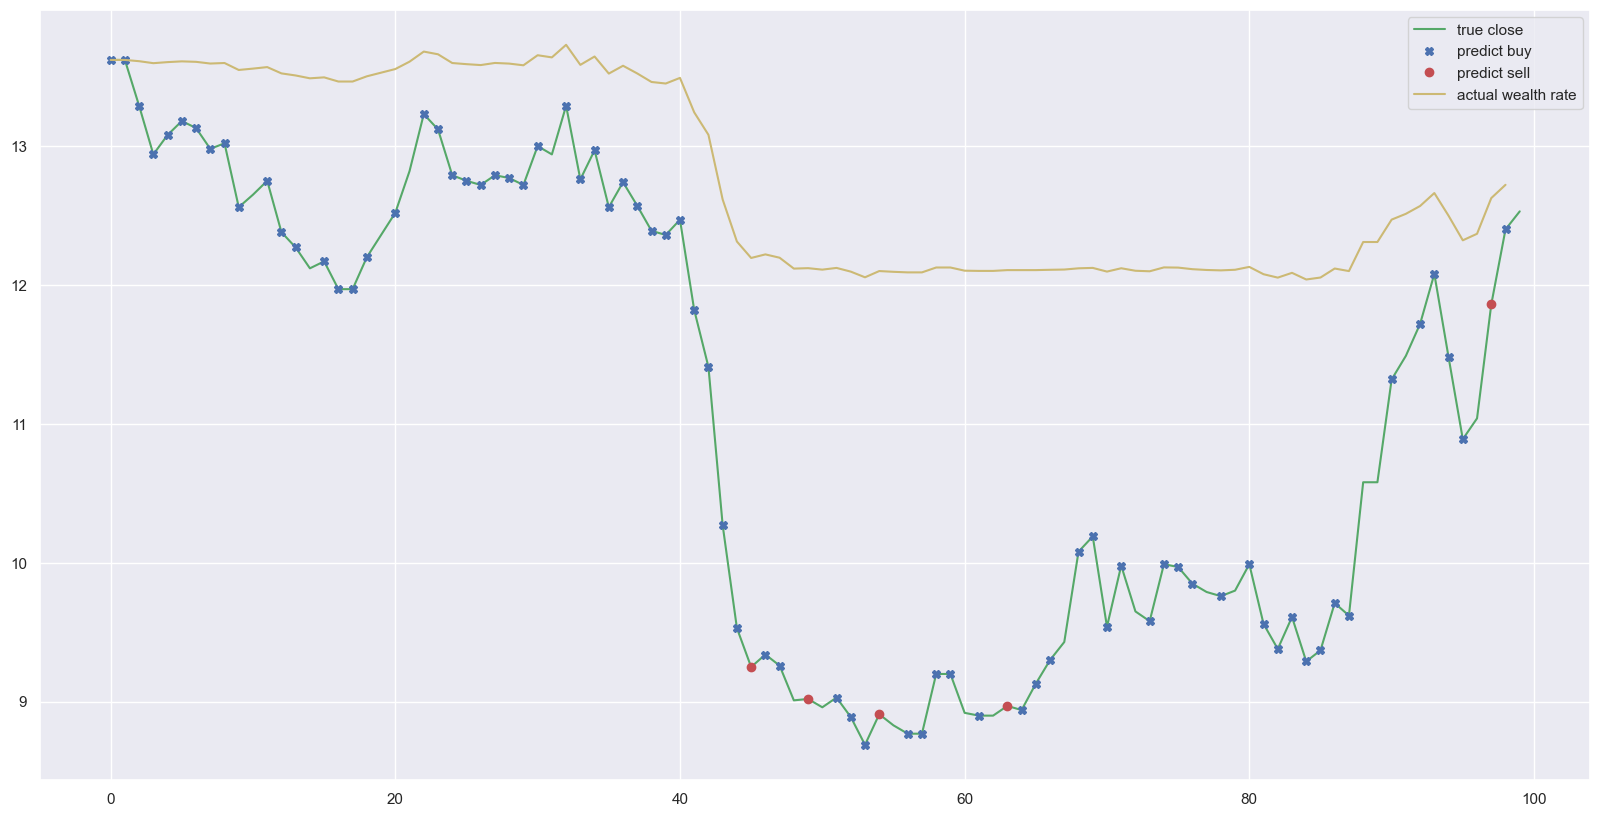

Benchmark rate is  -0.08002936857562408
[array([[-1.17821154, -1.1263419 ,  2.02058503, -5.55671867,  6.40744001],
       [ 1.08298546,  0.25629895, -0.47703073, -1.19187453, -2.11367601],
       [ 0.34485079, -0.08932007,  0.03499263,  0.12888962, -0.99918873],
       [-0.26285837,  0.79209526, -1.59900906,  0.53631129, -1.18062879],
       [-1.30375968,  0.25517471,  0.90564316,  0.50564707, -4.62416443],
       [ 0.24041995,  1.76384057,  1.22401654, -0.83858825, -2.43882386],
       [ 1.70039256,  1.02846767,  0.53204884,  0.05221415,  2.34704569],
       [ 0.48936594, -1.78713551,  3.70090958, -0.44689187,  0.23520879],
       [ 0.41601479,  0.07831755,  1.2261945 , -0.54566843, -1.67592804],
       [-0.43619713, -2.3038533 ,  2.45350801, -0.51572499, -1.71358026],
       [-3.82237322,  1.22509706,  1.81361591, -2.60908005,  2.84714967],
       [ 0.71935285, -0.21860492,  1.23915342,  0.51997495, -0.17132237],
       [-1.30137729, -1.82687678,  1.50014262, -4.84825309, -0.99393855

In [12]:
whole_comparision_test('002036.SZ',df1)

iter 10. reward: 0.026110
iter 20. reward: 0.104880
iter 30. reward: 0.301170
iter 40. reward: 0.347500
iter 50. reward: 0.432040
iter 60. reward: 0.698190
iter 70. reward: 1.287450
iter 80. reward: 4.111690
iter 90. reward: 6.689570
iter 100. reward: 8.023180
iter 110. reward: 11.112950
iter 120. reward: 10.852710
iter 130. reward: 11.030550
iter 140. reward: 10.845870
iter 150. reward: 9.973140
iter 160. reward: 10.935990
iter 170. reward: 11.263060
iter 180. reward: 15.274800
iter 190. reward: 17.996570
iter 200. reward: 18.354640
iter 210. reward: 22.942330
iter 220. reward: 23.583040
iter 230. reward: 24.326120
iter 240. reward: 24.961390
iter 250. reward: 24.184290
iter 260. reward: 24.218820
iter 270. reward: 24.735550
iter 280. reward: 22.501500
iter 290. reward: 24.303800
iter 300. reward: 25.349300
iter 310. reward: 24.688700
iter 320. reward: 25.267000
iter 330. reward: 25.218620
iter 340. reward: 25.271040
iter 350. reward: 24.245850
iter 360. reward: 25.879830
iter 370. re

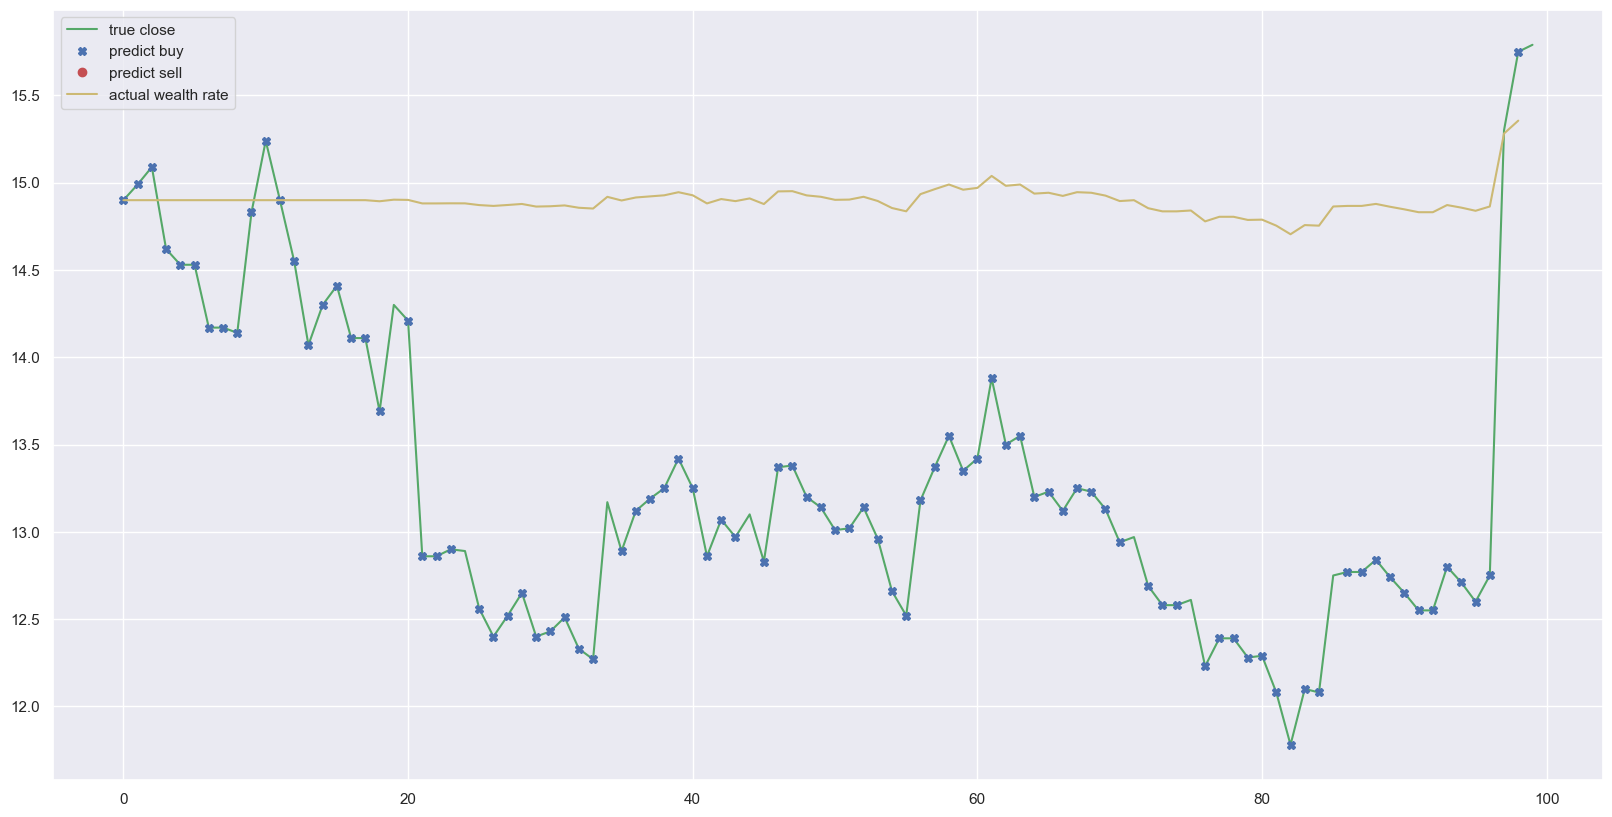

Benchmark rate is  0.05973154362416099
[array([[ 3.17121707e+00, -4.67466022e+00, -2.60017731e+00,
         2.06282480e+00,  5.57221182e-01],
       [-3.33726869e+00, -1.66804632e+00,  1.80259373e+00,
        -1.50767054e+00, -6.04996801e-01],
       [-2.78695439e+00, -2.16542161e+00, -1.58019857e+00,
        -8.09989857e-01,  2.91461400e-01],
       [-2.63120663e+00, -2.61361701e+00, -1.60040887e-01,
        -2.56745619e-01, -2.32794879e+00],
       [-1.12562222e-01, -2.31878599e+00,  1.95596549e+00,
         3.75746395e+00,  2.57417621e-01],
       [ 1.99593475e+00, -3.50941049e+00,  3.00390577e+00,
         1.57270127e-01, -3.82720099e+00],
       [-3.46784098e+00,  6.93823724e-01,  2.09343993e+00,
         3.29974920e-01,  3.93928972e+00],
       [-2.16647209e+00,  1.81474880e+00,  1.09690428e+00,
        -1.61687863e+00,  5.00950724e-01],
       [-5.46903501e+00,  2.02400833e+00, -5.78243631e-01,
         2.58871787e+00,  7.08608573e-01],
       [ 4.23359630e+00, -5.00208027e-01, 

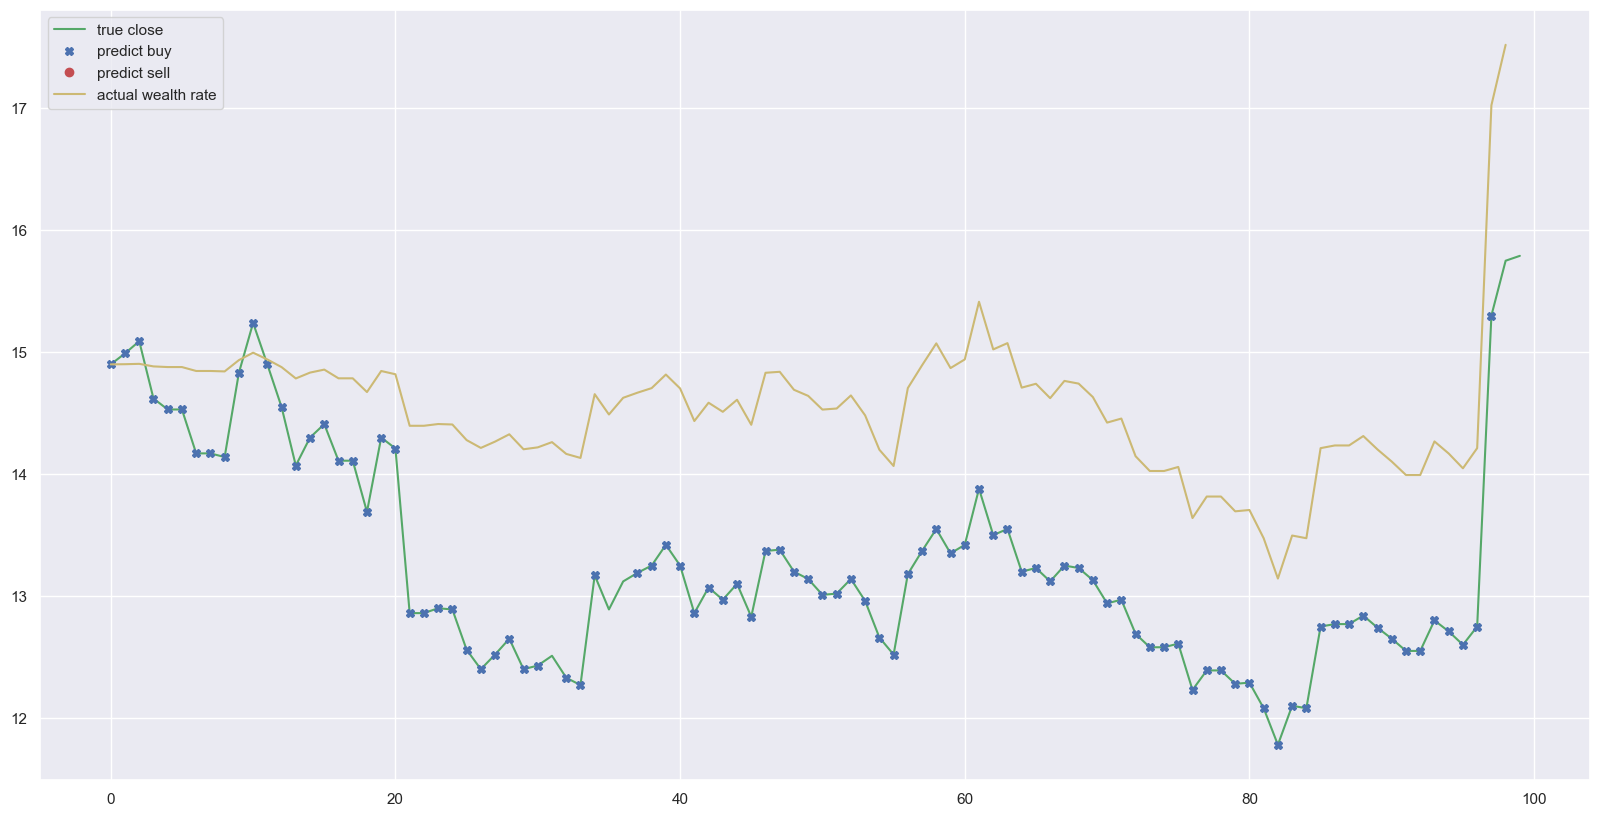

Benchmark rate is  0.05973154362416099
[array([[ 1.86732196,  3.71736915,  6.62526797,  2.09491421,  0.08524504],
       [-0.60784643, -3.61329797,  0.64103002,  0.14926834,  1.09015426],
       [-1.45136205, -1.33303294, -1.12711935,  3.39272313, -2.42375111],
       [-0.76730394, -3.94655286, -2.37349892, -1.04637244,  0.05501395],
       [-1.43937811,  1.44210616,  2.50088648,  2.73382429,  1.28844161],
       [-0.5641207 , -1.53592006, -1.05544195,  1.76631316, -0.92050469],
       [-0.57373979, -1.43825828, -0.9070689 ,  0.46910272, -1.0811051 ],
       [-2.34639101,  3.04981864,  3.86122481, -0.26783673,  2.01539217],
       [-0.16815964, -2.78125101,  4.52758331, -0.56064091,  1.57596571],
       [ 1.13332378, -2.98122354, -2.27992435,  4.84536963, -0.78670996],
       [ 1.47000469, -0.18670007, -1.75759977, -0.58442396,  1.23427732],
       [ 0.07126739,  0.95606521, -1.15930106,  1.5394075 ,  2.190226  ],
       [-0.3217361 ,  3.40978435,  4.42027247,  3.66109654,  2.35763813]

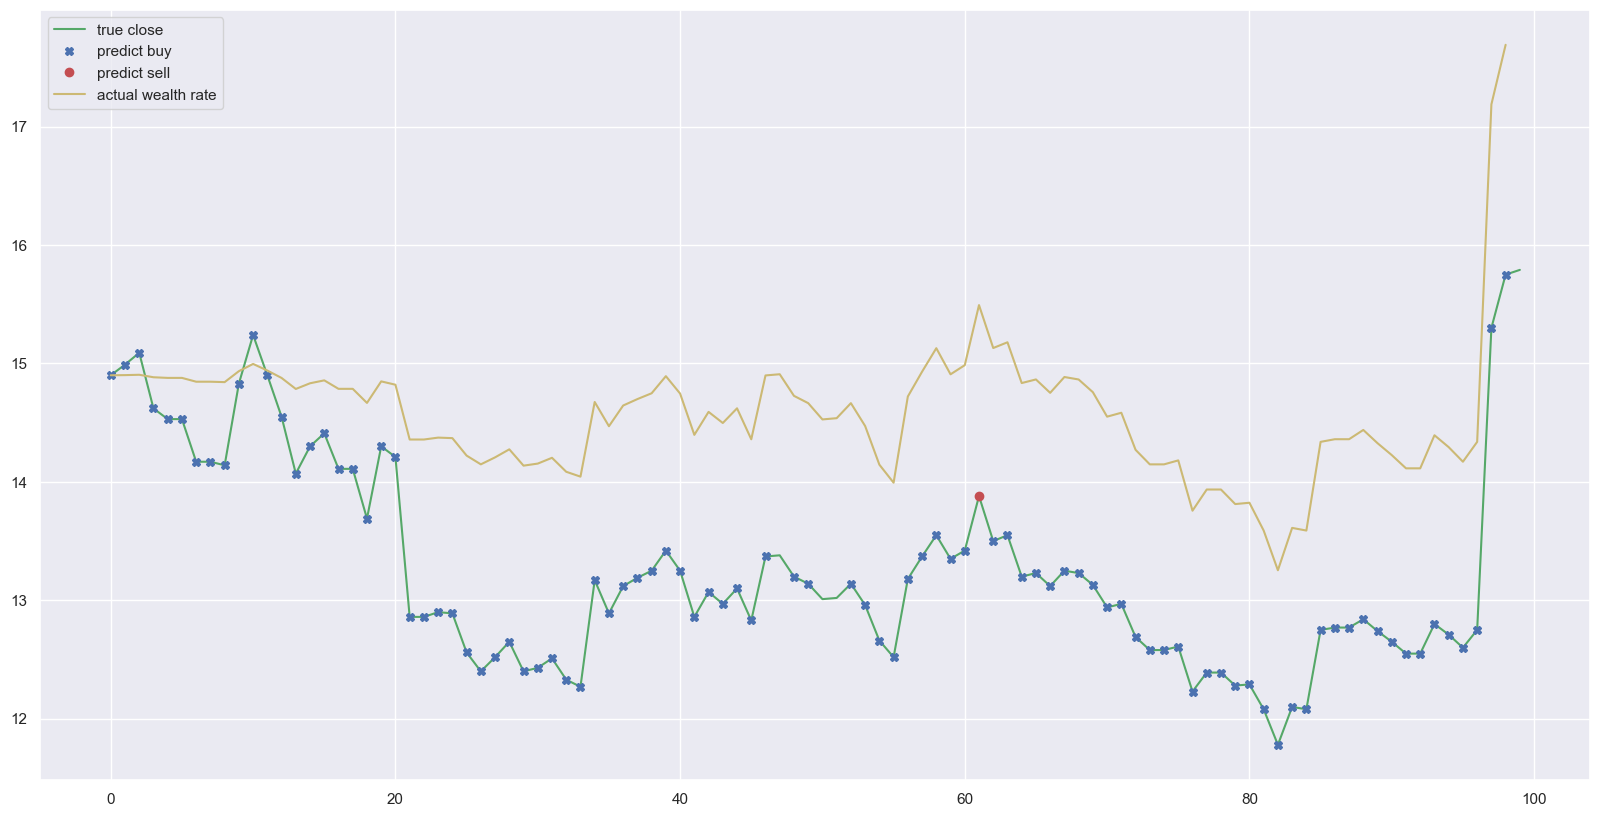

Benchmark rate is  0.05973154362416099
[array([[-0.33576657,  3.26064356, -1.84000904,  2.56244091,  1.54295976],
       [ 0.15550112, -4.63597394,  2.1189193 , -0.95654848, -1.58557541],
       [ 0.24391752, -2.09132114,  1.14737361, -1.12437328,  4.05723474],
       [ 2.10120324, -0.32069739,  0.1697752 ,  0.43657074,  0.02030474],
       [ 0.09503953, -0.57558955, -0.16178239,  1.4720974 ,  2.239734  ],
       [-1.81965547, -1.3340592 , -0.2542178 , -3.17708181, -1.10490588],
       [ 2.04666629, -5.19891567, -0.05926233, -1.78850593,  1.45892919],
       [-0.05298849,  0.3054944 ,  0.71267616, -2.80624227,  3.14671897],
       [-1.84314518, -2.5089867 , -1.72386539,  0.60184019,  0.758131  ],
       [ 0.3999703 , -3.9198333 , -1.07495749, -3.69358895,  1.06968511],
       [-0.62287574, -3.52581741,  1.27094172, -2.05495207, -0.18477453],
       [ 1.09949364,  2.27085521, -3.86066207, -1.57955701,  1.56181217],
       [ 1.17020157, -6.62612175, -1.86386762, -2.95736704,  0.13438904]

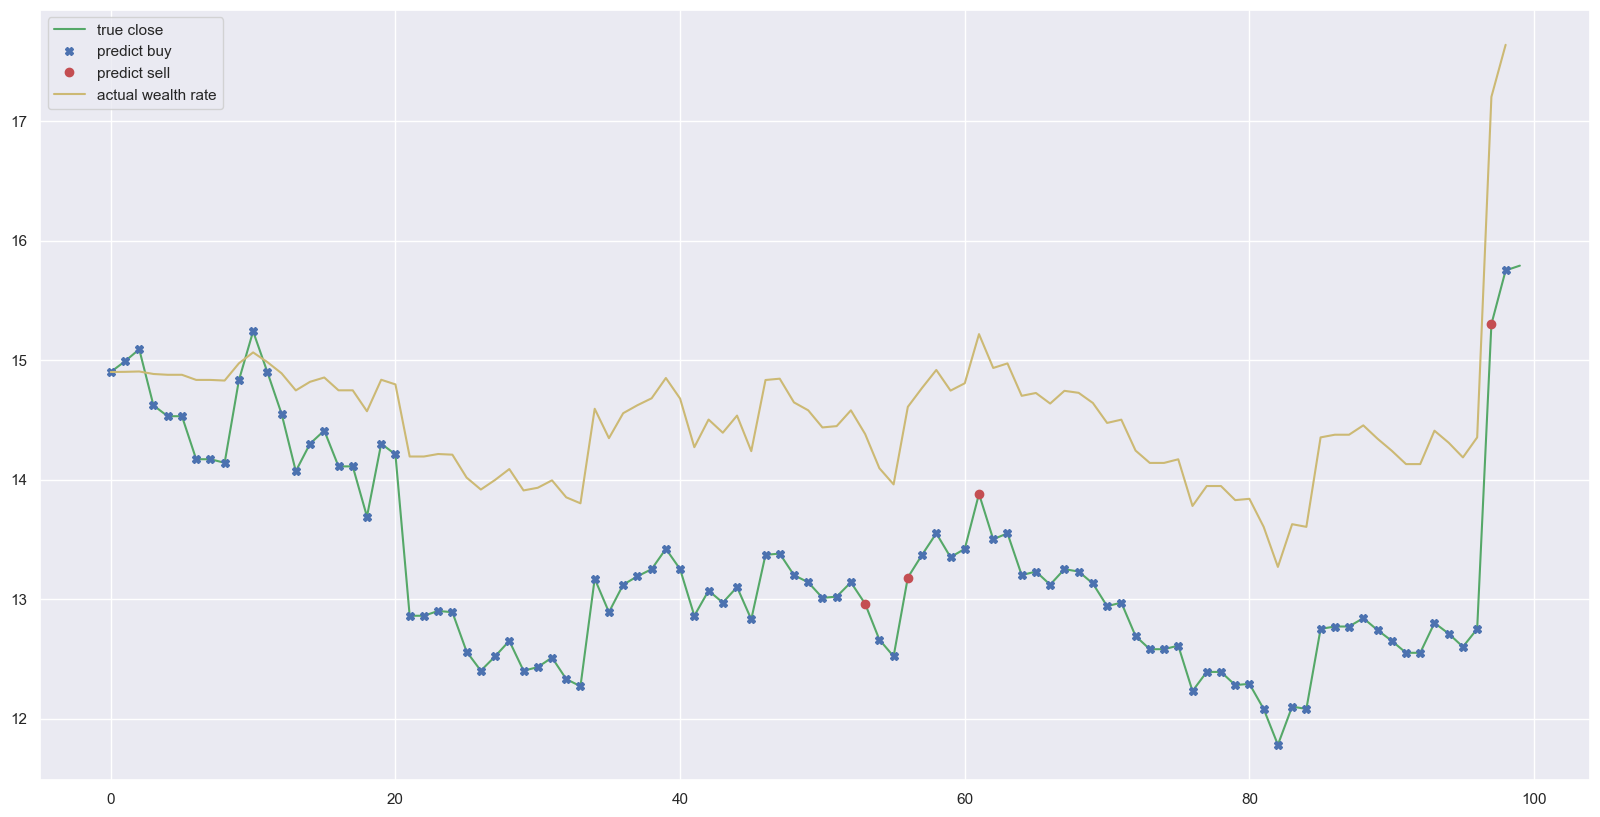

Benchmark rate is  0.05973154362416099
[array([[-2.92403410e+00, -7.53845590e-01,  1.59926921e+00,
         1.91467258e+00, -8.83478510e-01],
       [ 7.21395394e-01,  3.98600375e-02,  2.89121675e+00,
         1.53544219e+00,  5.76055414e-01],
       [-2.11729858e+00, -1.28767166e+00, -1.58108676e+00,
        -8.70629481e-01, -1.56013344e+00],
       [-7.66430152e-01,  3.47700090e+00,  4.41338376e-01,
         1.03753885e+00, -1.49832229e+00],
       [-1.00979354e+00, -2.10132666e+00,  3.43583838e+00,
        -3.63422015e+00, -2.90945538e+00],
       [ 7.23911626e-01,  2.02117558e+00,  8.09720286e-01,
        -6.82824299e-01, -1.04693583e+00],
       [-2.30117793e+00,  6.75937915e-01,  3.31173615e+00,
        -1.43230793e+00, -2.62875187e+00],
       [-1.79195813e+00, -5.29972503e-02,  9.41089716e-01,
        -1.27787802e+00, -1.96351184e+00],
       [ 4.35781518e-01,  1.96978634e+00,  3.69197351e+00,
         6.17124602e-01, -7.84876216e-01],
       [-2.86648562e+00,  2.72996918e+00, 

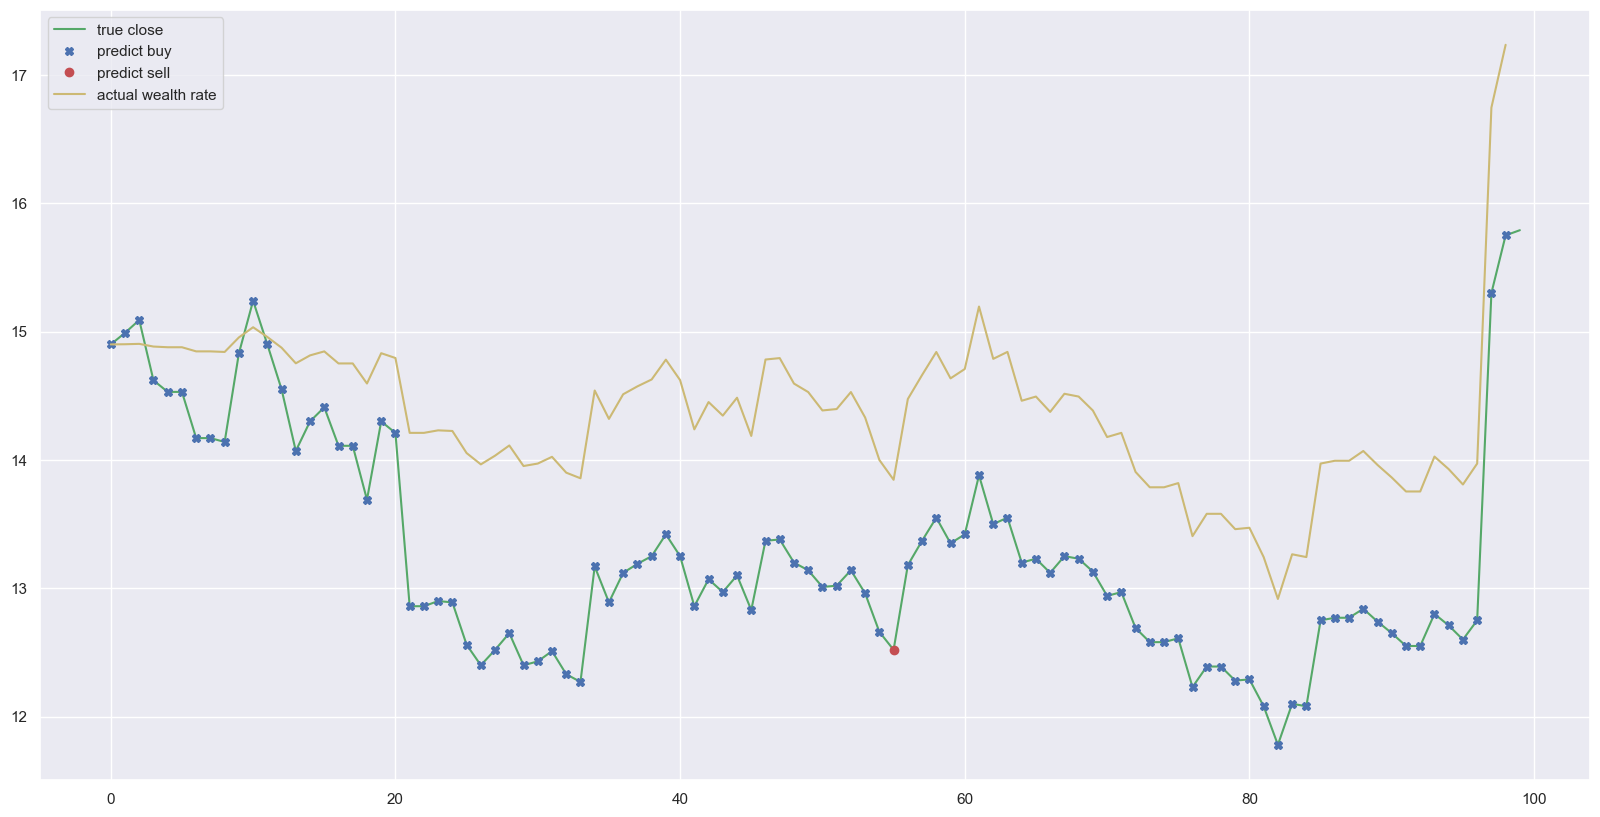

Benchmark rate is  0.05973154362416099
[array([[-0.67405581, -0.19062206,  2.79081731,  0.5922874 ,  1.61300135],
       [-5.76564319, -3.4092962 , -1.05187235,  0.56401093, -0.36125399],
       [-1.44860599,  2.38962396,  2.35909152, -2.48669633,  3.03287185],
       [ 3.18864123, -1.82928724, -0.9936603 ,  0.78451954, -2.1618236 ],
       [ 0.19547519, -1.72030279,  0.97758667, -0.52760804, -2.00733799],
       [-0.66177513,  2.76347414,  3.88897586,  4.87056427,  1.31024865],
       [-1.63727698, -4.2243271 ,  1.25110785, -1.61156716, -1.50502268],
       [-3.87663905, -1.65443015,  0.21219397,  2.37949763,  0.48410227],
       [ 0.29122957,  0.58002606,  5.23240992,  2.80994636,  5.28460203],
       [-1.76014628,  3.15359229,  1.54786636,  2.18500439,  2.81311077],
       [-1.30755565,  0.47549189,  4.22920648, -1.78823618,  2.29408702],
       [ 0.6844221 , -0.23355177,  2.2347885 ,  3.48061793,  0.36793112],
       [-0.86566156, -0.19035779,  2.05872798,  2.22740219, -0.22676477]

In [13]:
whole_comparision_test('300521.SZ',df1)

iter 10. reward: 0.452910
iter 20. reward: 1.494410
iter 30. reward: 3.953540
iter 40. reward: 6.329770
iter 50. reward: 9.848810
iter 60. reward: 14.699470
iter 70. reward: 18.865390
iter 80. reward: 16.399440
iter 90. reward: 20.502190
iter 100. reward: 23.718270
iter 110. reward: 29.015270
iter 120. reward: 33.445630
iter 130. reward: 36.886200
iter 140. reward: 41.089490
iter 150. reward: 48.219050
iter 160. reward: 60.670540
iter 170. reward: 70.172670
iter 180. reward: 73.682080
iter 190. reward: 72.170340
iter 200. reward: 72.316440
iter 210. reward: 74.674340
iter 220. reward: 73.245400
iter 230. reward: 76.754260
iter 240. reward: 77.524070
iter 250. reward: 79.212060
iter 260. reward: 79.934730
iter 270. reward: 78.859260
iter 280. reward: 80.073980
iter 290. reward: 82.071100
iter 300. reward: 83.456020
iter 310. reward: 84.863840
iter 320. reward: 86.041420
iter 330. reward: 90.067710
iter 340. reward: 93.468480
iter 350. reward: 87.579430
iter 360. reward: 89.237730
iter 3

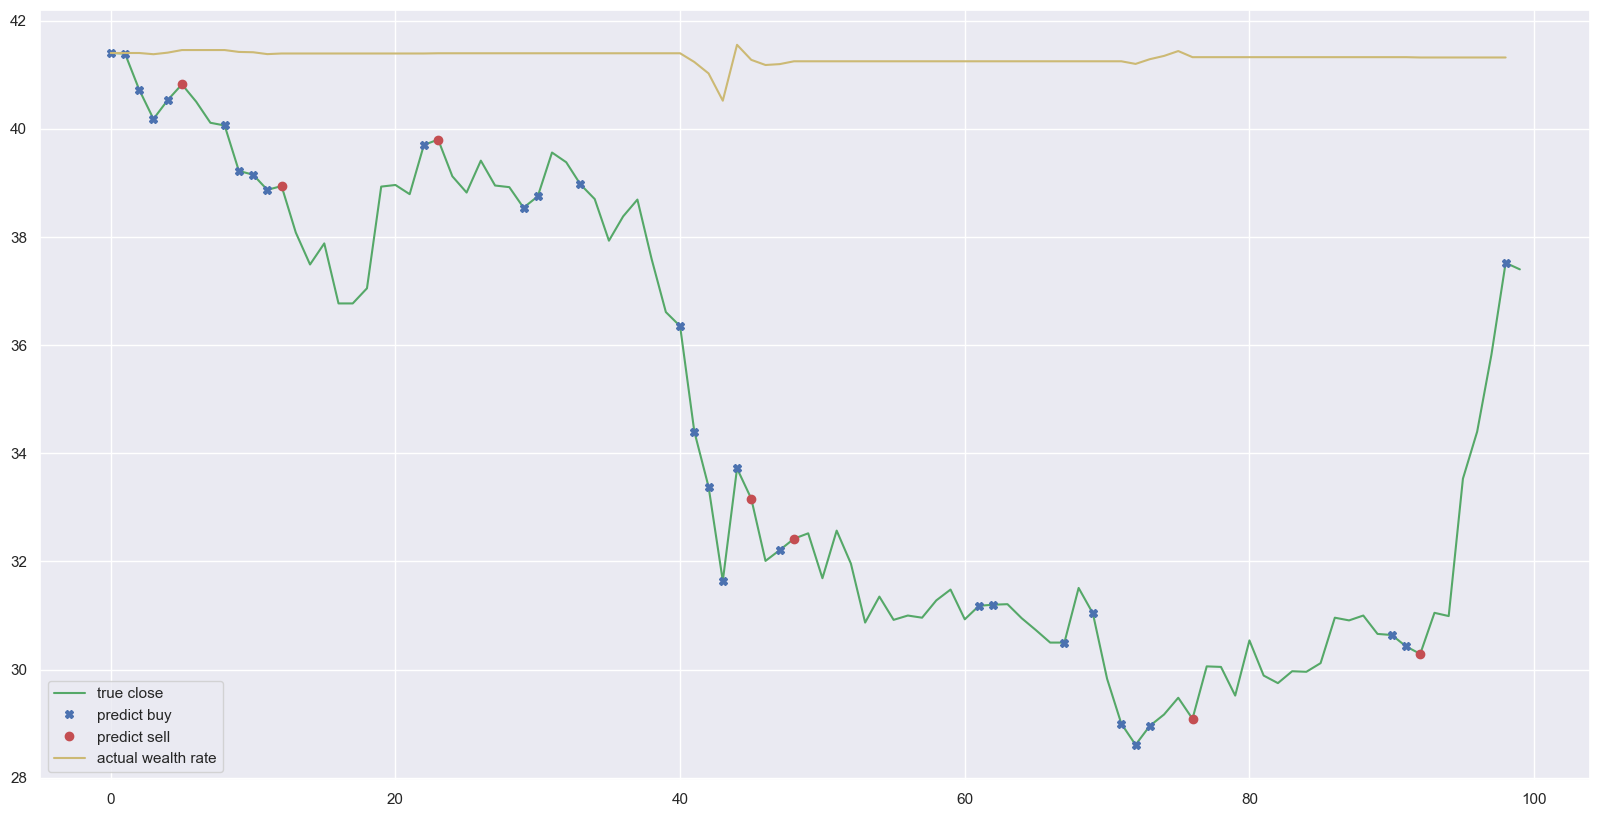

Benchmark rate is  -0.0966183574879227
[array([[-2.0625217 ,  0.10529734,  2.8211433 ,  3.27948821, -0.28321832],
       [-3.09364109, -3.25163938,  0.55484105,  2.8189798 , -0.5234017 ],
       [ 1.87082423, -0.41955118,  5.51200609,  2.03271045,  1.63800335],
       [ 2.509637  , -2.22562552,  1.6786077 ,  1.86651898, -0.36543279],
       [-0.84473435,  1.6259726 ,  0.56342926, -3.28921396, -0.63801371],
       [-1.00073513, -2.14392858, -4.45640016,  2.72685339, -1.53919685],
       [-1.84715159, -3.8581758 ,  1.20726918, -5.12556319,  1.02965756],
       [-2.63905471, -0.74647814, -0.45992364,  0.48906993,  0.15994758],
       [ 1.52591433,  1.50682252,  0.19349241,  1.31359505, -0.7315904 ],
       [-2.37581971,  0.67397632, -2.69799798,  3.3925685 , -5.36803711],
       [-2.31589648, -0.9123757 ,  1.8995231 , -0.68613   , -1.6035617 ],
       [-2.41659356, -1.83613481,  3.1349519 , -4.03094086,  0.57303149],
       [-0.21854087,  1.08660394,  0.29456745, -1.97116598, -1.48756841]

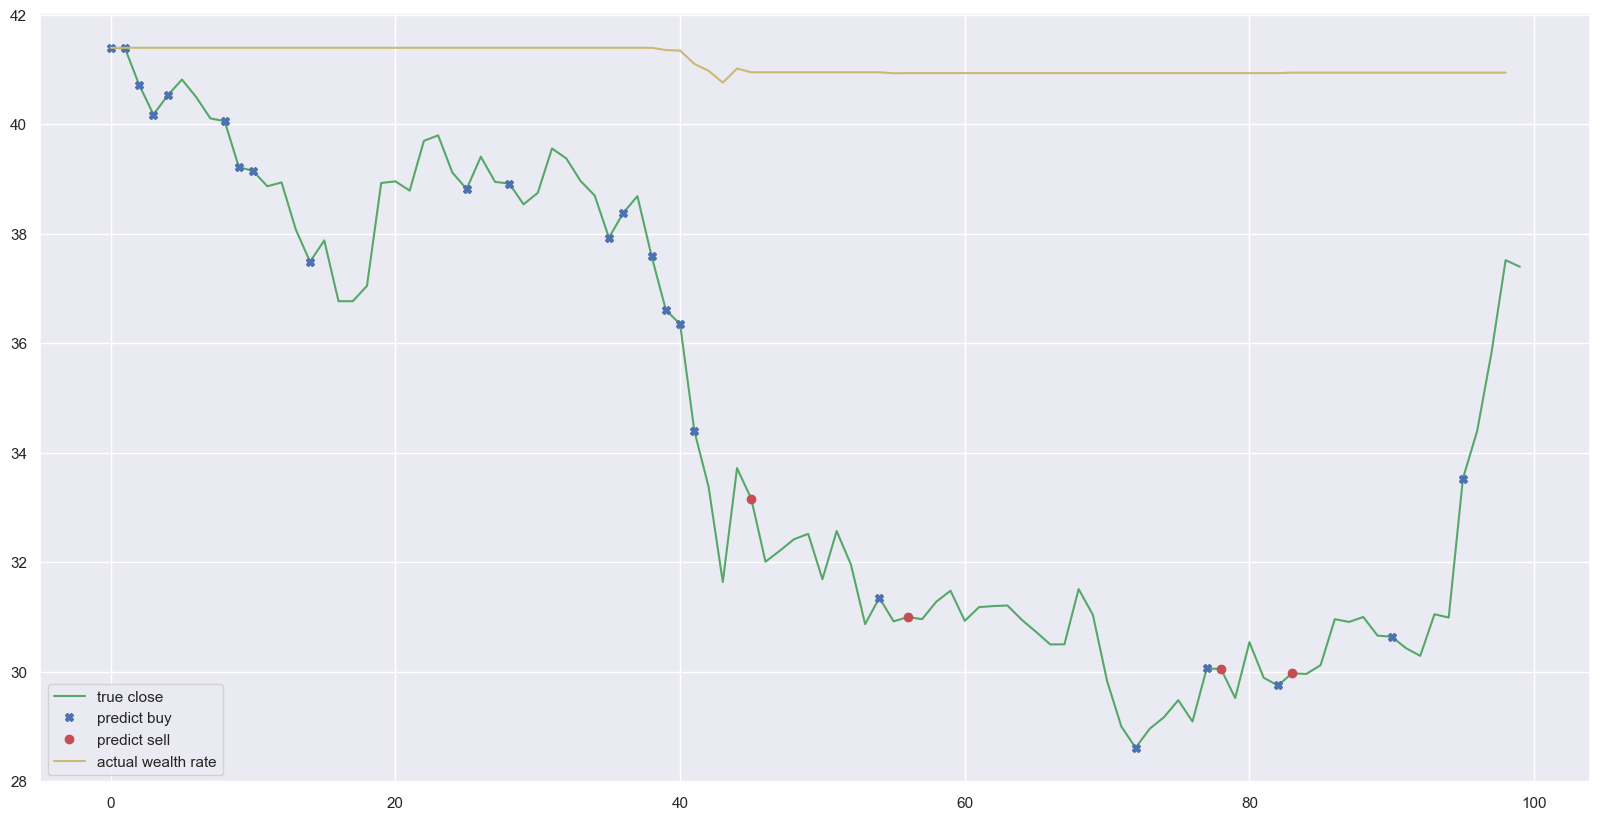

Benchmark rate is  -0.0966183574879227
[array([[-0.23234938,  0.57628614, -3.16875261, -2.32664841,  0.56147808],
       [-3.51640812, -0.01728881,  0.19117475, -0.45026486,  0.31026855],
       [ 0.71410345,  4.46796865,  5.98897488,  0.31964784, -1.08429107],
       [ 2.15452318, -0.23839915,  1.15221674, -3.40862618, -2.13172249],
       [ 1.6452672 , -2.39719884, -0.1116429 ,  2.49507667,  0.22374397],
       [-0.28368203, -1.02272595,  0.42412463, -0.34221478,  3.07201554],
       [-1.24960711, -5.0576242 , -3.44651288, -1.09157911, -2.25810164],
       [ 0.55418518,  2.88630218, -1.53313296,  0.54081226, -2.08913639],
       [-0.33580474, -3.66469417, -0.9688905 , -1.99894551, -2.38973379],
       [ 1.60315049, -2.81010392,  0.80209871, -1.22521094, -2.57482652],
       [ 1.25764214, -2.81125637, -0.55410173, -2.0713701 , -0.82747093],
       [-2.75769977, -3.2352237 ,  0.63420425,  3.24491809, -1.10524155],
       [-3.03637318, -1.72275866,  3.22747341, -3.29265734,  2.8276646 ]

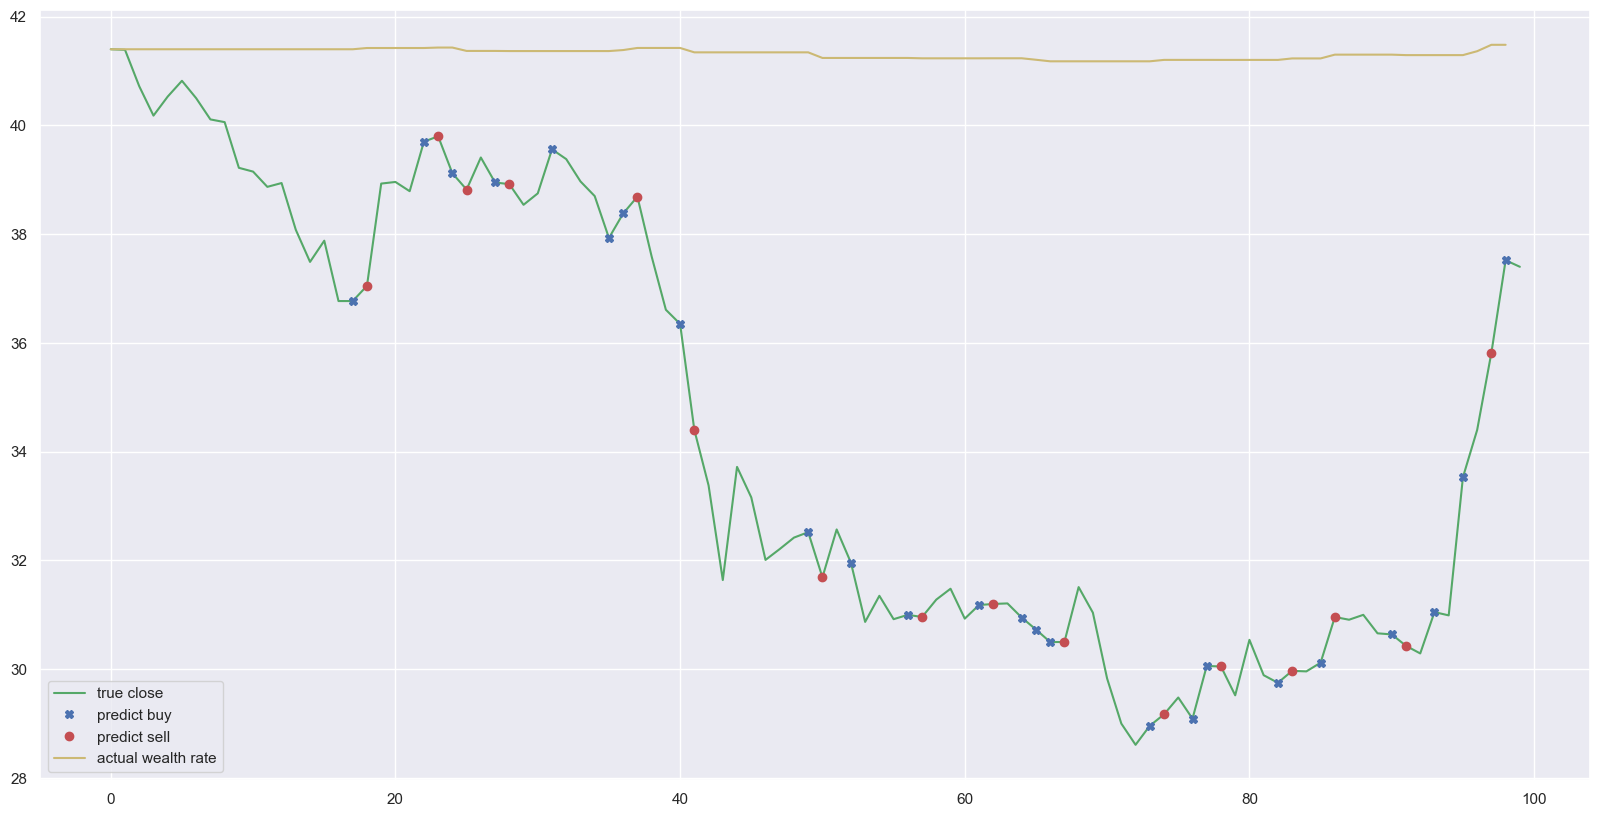

Benchmark rate is  -0.0966183574879227
[array([[-0.39781796, -2.3149257 , -1.52619121, -1.40418531,  1.48913935],
       [-0.97160014, -4.45833392, -1.62341531, -3.98049988, -1.4599347 ],
       [ 2.92581094,  2.64755598, -0.70438805,  2.75066602, -2.62256767],
       [ 4.17019972,  1.63047607,  1.87071119, -0.66807584,  0.41330499],
       [-0.01165549,  2.97400865,  1.4643204 ,  1.86731077, -0.41970518],
       [ 0.85493277, -0.5151795 , -1.19703339,  4.43539324,  2.79854242],
       [-1.44542634,  0.82402353,  2.32319283,  2.98992132,  0.83106724],
       [-1.01831512, -2.65006398, -1.33430421, -1.09658282, -1.55845694],
       [ 3.26114314,  1.86653882, -2.78247418,  0.78981478, -3.37402879],
       [ 0.94642884, -0.71609736, -3.5312278 ,  2.04551521,  3.26995471],
       [ 2.32658043,  3.90728726, -4.2256682 ,  2.17486744,  3.29213259],
       [ 0.41976684, -1.59430785, -1.06774655, -3.76092555,  0.96690328],
       [-3.25869835,  3.07292151, -2.29992338,  1.35699221,  1.99706304]

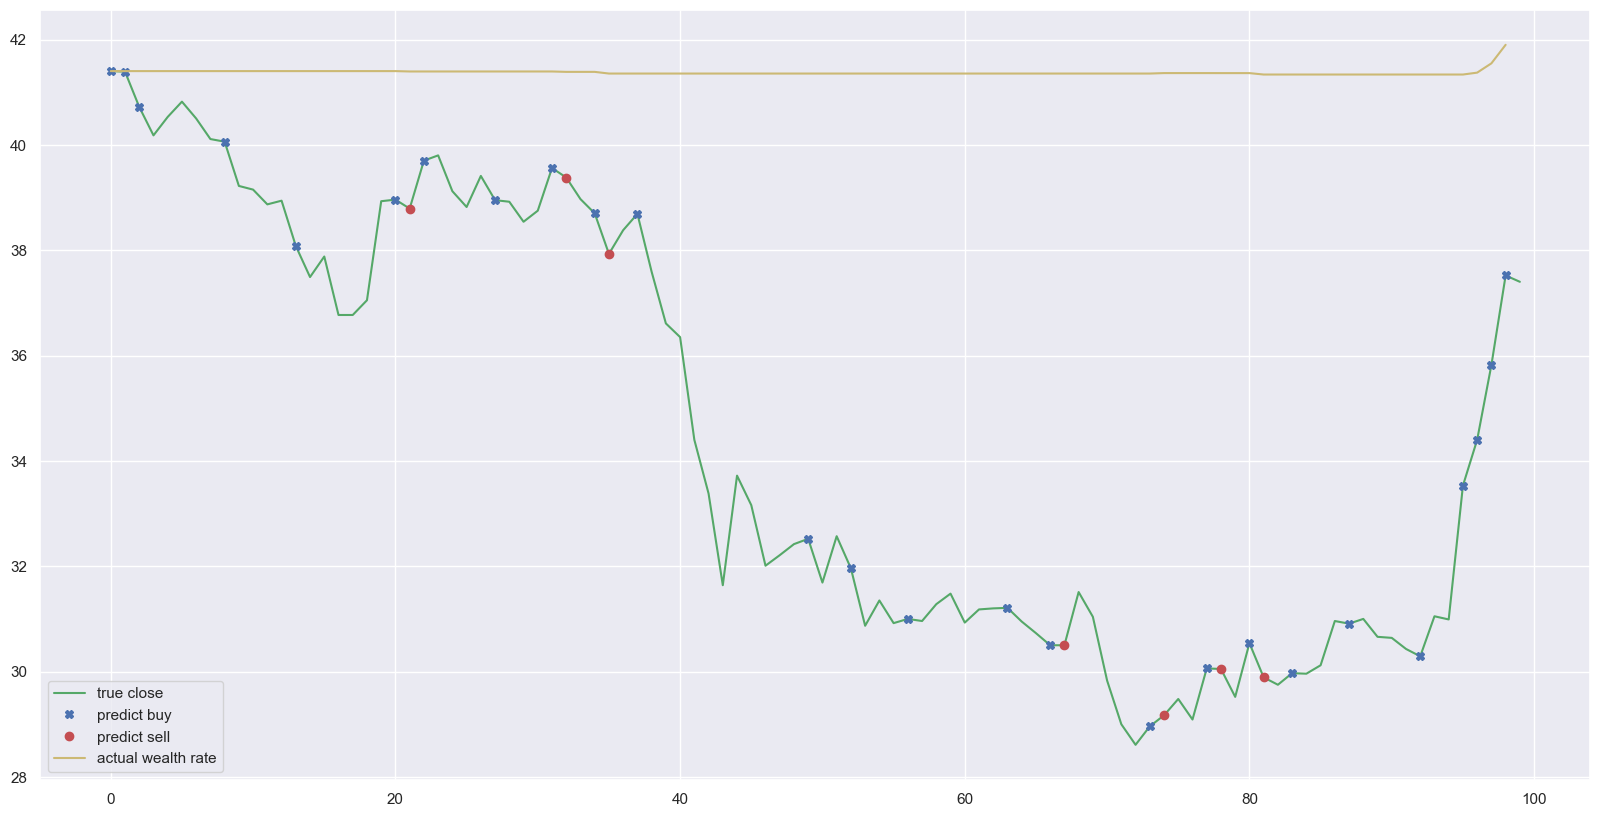

Benchmark rate is  -0.0966183574879227
[array([[-1.52230454e+00, -3.40320160e+00, -5.54546853e+00,
         1.26924130e+00,  1.94279510e+00],
       [-1.48723875e+00,  6.58718283e-01, -1.09330877e+00,
        -8.06585348e-01,  9.35526904e-01],
       [-4.62975154e+00,  8.22454204e-01,  1.30690534e+00,
         3.29923791e+00,  1.57580553e-01],
       [-4.41265970e-01, -4.79671458e-01,  3.13036787e-01,
         1.51519299e+00,  1.96741787e+00],
       [ 1.13567436e+00,  8.12206018e-01, -1.01657796e+00,
        -4.45435504e+00,  9.97912623e-01],
       [ 1.50452497e+00,  4.44752763e-01, -4.80821526e-01,
         2.52832541e-01, -7.29890248e-01],
       [ 1.20843619e-02, -4.61218265e-01, -2.58129239e-02,
        -4.17608208e-02, -1.10208736e+00],
       [ 2.08355294e+00, -2.70495311e+00,  1.17190559e+00,
        -1.68036843e+00,  1.50525156e+00],
       [-2.18469761e+00,  7.91504036e-01, -3.59981423e+00,
        -1.52381573e+00, -4.65852061e-01],
       [ 1.65758571e+00, -3.54656610e+00, 

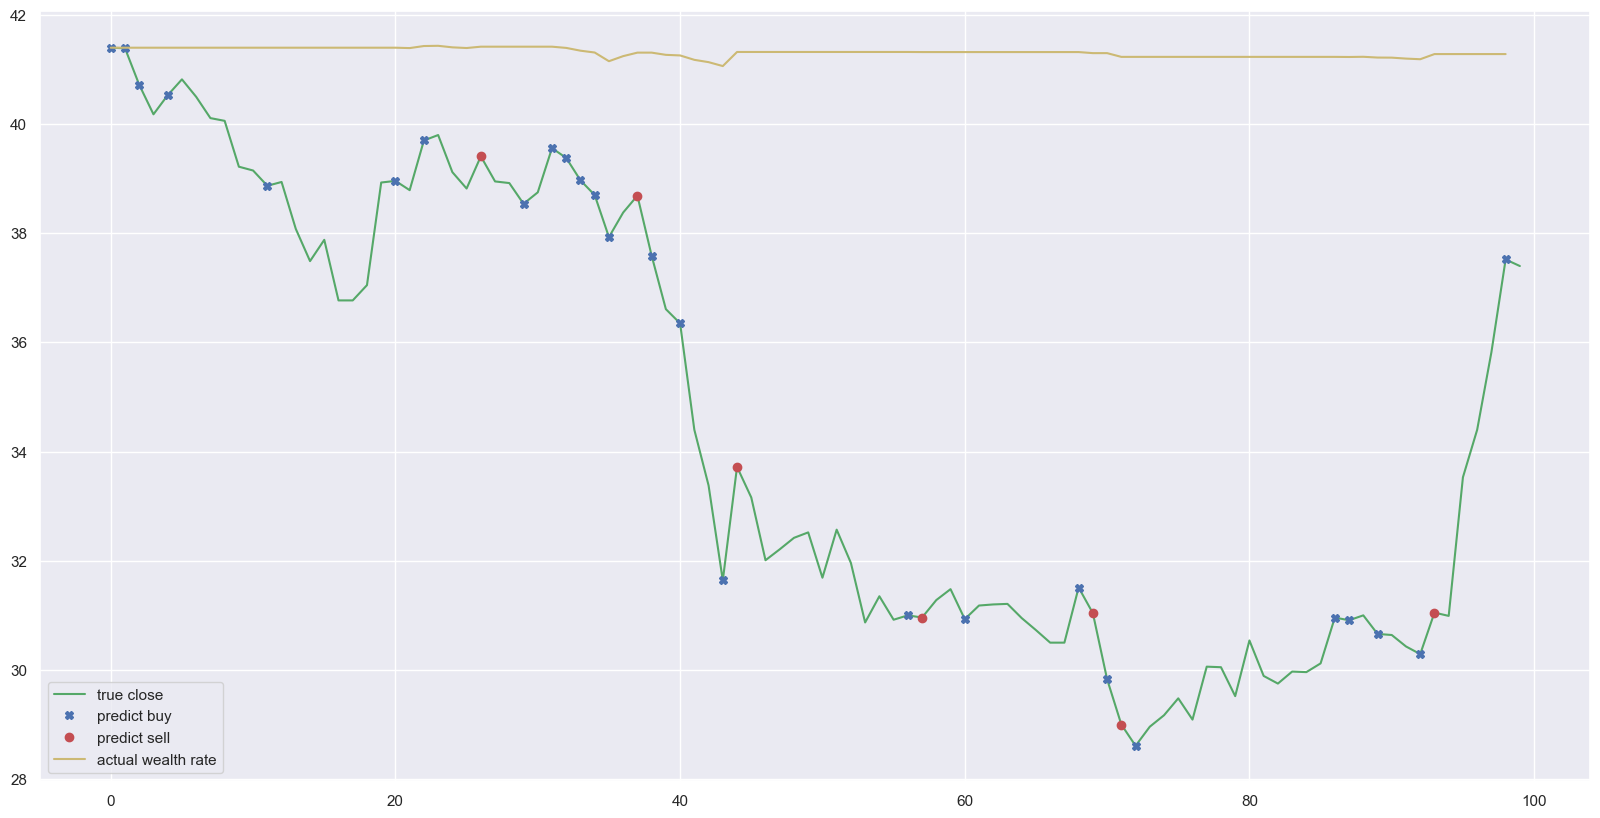

Benchmark rate is  -0.0966183574879227
[array([[-3.84668931, -5.58571886,  1.10734479,  3.24469905,  4.15129556],
       [-0.04787109,  1.84332556, -0.81071929,  2.28015792, -1.81005483],
       [ 1.49652344, -3.35135065,  2.18716987, -2.2739133 ,  0.09787484],
       [-1.54186489,  5.0087731 ,  0.73097143, -0.2638149 ,  1.20774592],
       [-2.29872377,  0.99935432, -1.37069872, -0.74581907, -1.7972644 ],
       [ 1.6021812 ,  3.21819721, -1.80466866, -0.86620703,  1.94934632],
       [-0.09642834,  0.48777122, -0.46663652,  0.19769242,  1.29718472],
       [-0.52136388,  3.24329351,  0.81643387, -0.19460917,  0.06223861],
       [-0.602619  ,  2.13561978,  1.34225965,  3.86446356,  2.38717514],
       [ 1.62327775, -1.27646215,  0.00849094, -2.02240909, -1.95251054],
       [ 1.7917571 ,  3.73198136,  0.25639853, -2.48053464, -0.24573734],
       [ 1.96974598,  1.92531519,  1.06629674, -1.27456609, -0.42921243],
       [-3.49346646, -0.421107  , -0.69920164,  0.07105907,  2.06257222]

In [14]:
whole_comparision_test('688733.SH',df1)

iter 10. reward: 0.061990
iter 20. reward: 0.188800
iter 30. reward: 0.359860
iter 40. reward: 0.676520
iter 50. reward: 0.920200
iter 60. reward: 1.306260
iter 70. reward: 1.799370
iter 80. reward: 2.300550
iter 90. reward: 2.630890
iter 100. reward: 3.328920
iter 110. reward: 4.013110
iter 120. reward: 5.032030
iter 130. reward: 5.482790
iter 140. reward: 6.888540
iter 150. reward: 7.938380
iter 160. reward: 8.934800
iter 170. reward: 9.575320
iter 180. reward: 10.405540
iter 190. reward: 10.951750
iter 200. reward: 11.448380
iter 210. reward: 12.471620
iter 220. reward: 12.656060
iter 230. reward: 13.016270
iter 240. reward: 12.891980
iter 250. reward: 13.275650
iter 260. reward: 13.115770
iter 270. reward: 13.471030
iter 280. reward: 13.317930
iter 290. reward: 13.267090
iter 300. reward: 13.330790
iter 310. reward: 13.423010
iter 320. reward: 13.874500
iter 330. reward: 13.611440
iter 340. reward: 13.567320
iter 350. reward: 13.501620
iter 360. reward: 13.559370
iter 370. reward: 

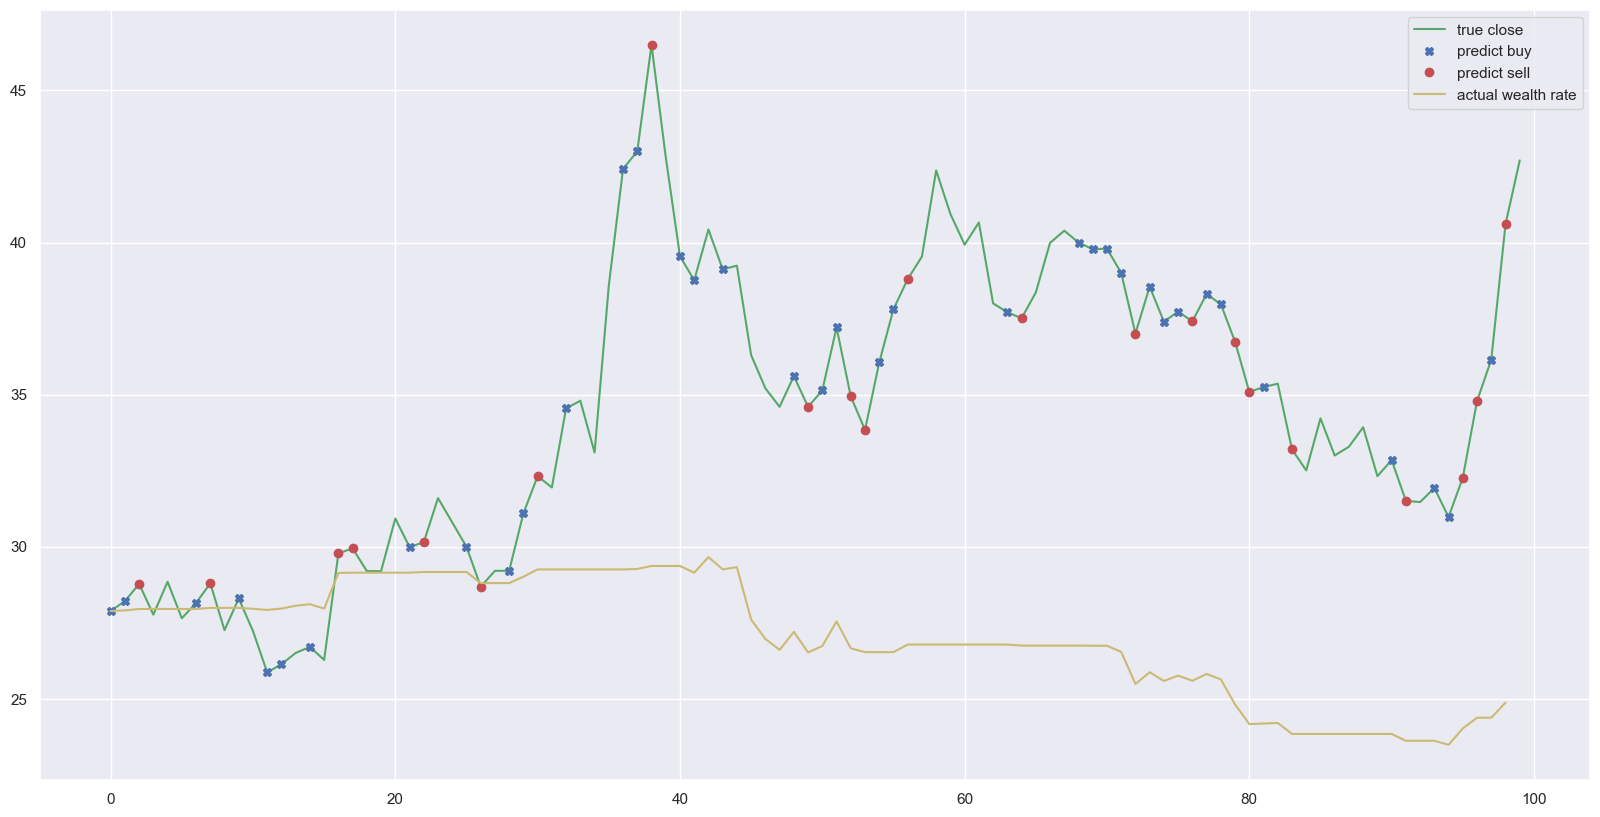

Benchmark rate is  0.5310147006095376
[array([[-3.99524303,  0.50738942,  2.56841943,  2.14149925, -3.10499673],
       [ 1.69095354,  1.51364199,  0.26486403,  2.30342401,  0.98822493],
       [-2.11211386, -4.47254053, -2.0508628 , -2.02696348,  1.80144907],
       [-2.68602708,  3.63190341, -0.72045318, -0.35643303, -2.51912944],
       [-0.99673502,  7.38273459,  1.89470634,  4.21659081,  1.67220628],
       [ 1.85483714,  5.14162416,  3.41870054, -0.38898537,  0.06730579],
       [-1.83813956, -4.17075577, -0.0847193 , -1.09738663, -4.6410733 ],
       [ 3.38695247,  4.61883177,  3.44387071,  2.34198471,  3.71893125],
       [ 1.04330431, -2.05306776,  1.72281945,  3.05544376,  1.35596191],
       [ 0.9374359 , -2.41852136,  1.71644921,  1.10544425, -1.1001492 ],
       [ 1.88855103, -1.1223043 ,  0.21655992, -4.60322108, -2.18366853],
       [ 1.07564164,  6.91755825, -2.91137045,  2.5387552 ,  0.43993772],
       [ 1.51593675,  1.16886898, -0.59256451, -0.45952625,  0.98653996],

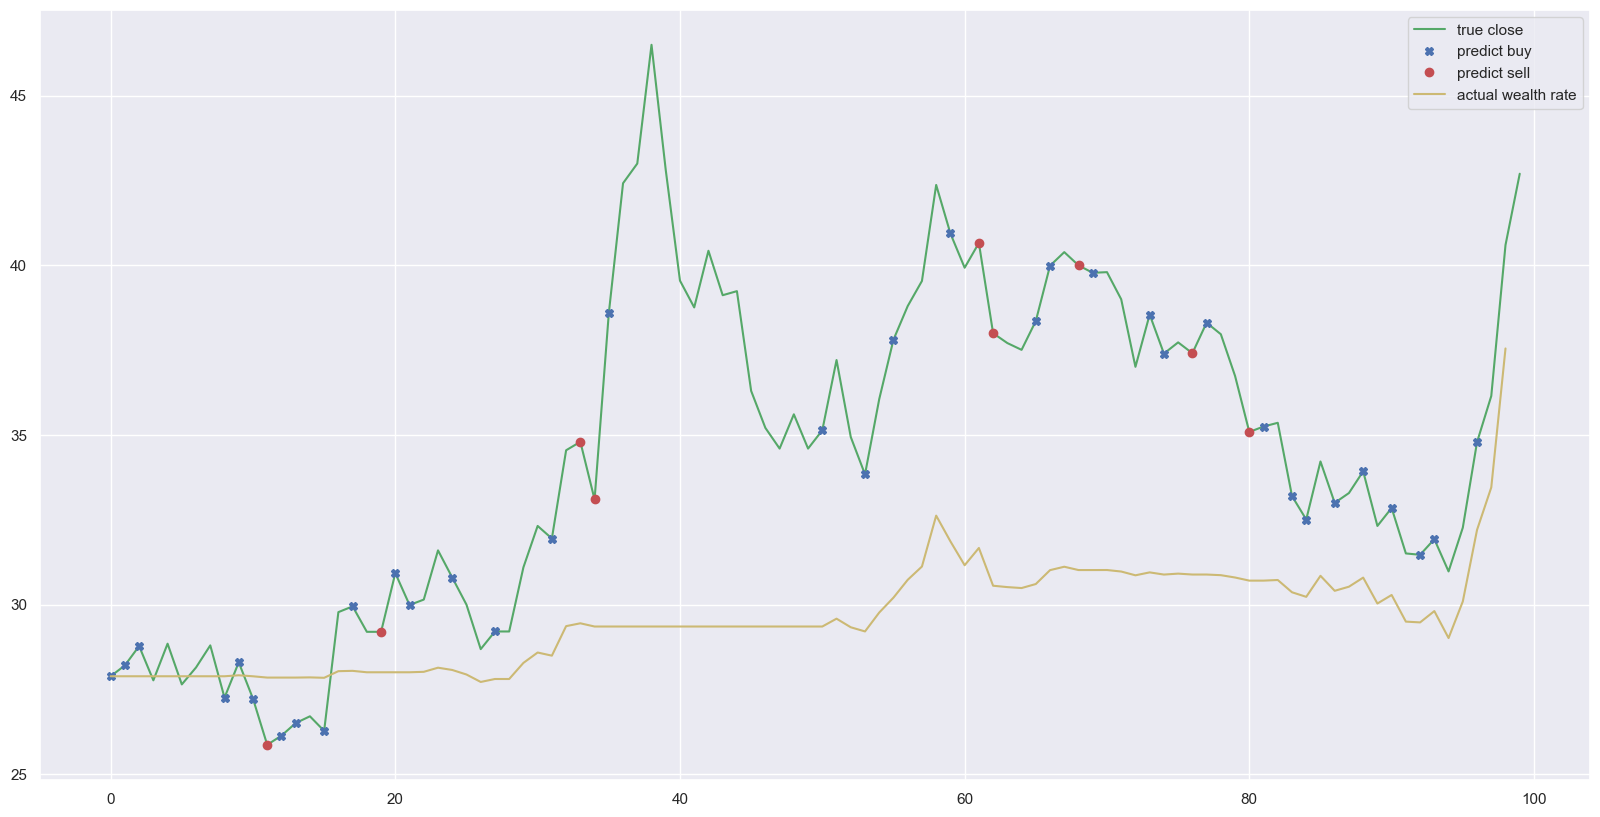

Benchmark rate is  0.5310147006095376
[array([[ 1.99578653,  0.2155296 , -0.46577072,  0.30593447, -1.42293473],
       [ 1.27999993,  1.67047159,  0.30369156, -1.78655507,  2.43550993],
       [-2.90153035,  2.26531828,  1.26921126,  3.78244491, -5.98258218],
       [-0.47190433, -2.2406283 ,  2.55118409,  3.14839609, -0.71563272],
       [ 1.25316765, -0.50223285, -0.93559701,  0.52295393,  3.42817288],
       [-1.70309819,  0.50817783,  1.51231612, -0.0455421 ,  1.90636126],
       [ 4.60425577, -0.53185423, -1.30924682,  2.98731284, -1.64830462],
       [-2.19333031, -2.24505659, -1.15317586, -1.16276106,  0.27139271],
       [-4.97788266, -1.14315906, -0.60682365, -0.20156413,  2.54108753],
       [-2.1044576 ,  0.35985036,  0.32111929,  0.91752189, -1.76550349],
       [ 0.22849594, -0.63153949, -3.27921223,  4.01694893,  1.78084736],
       [ 0.68840005, -0.34014401, -1.77428225,  0.70420129,  2.17087107],
       [ 2.37913716, -2.41680585,  1.18062397,  0.57196646,  0.03398919],

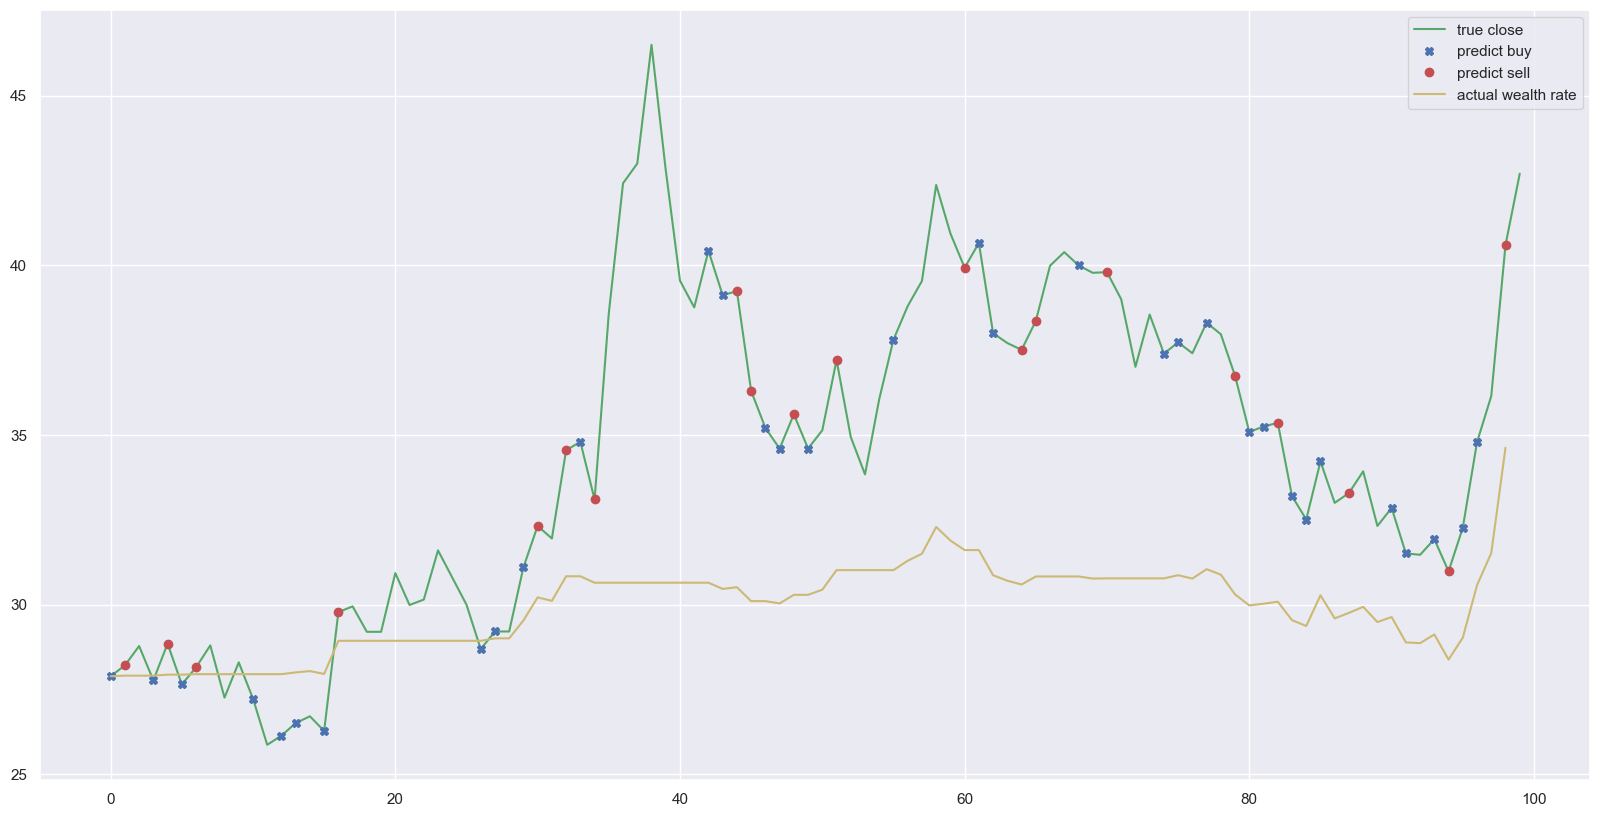

Benchmark rate is  0.5310147006095376
[array([[ 0.29111872, -2.23118554,  0.30599431,  2.93295466, -1.66790562],
       [ 6.59724594, -1.16984444,  2.95738364, -3.49076533, -7.76708167],
       [-5.93206643,  3.05257966, -1.12573361,  2.03523759,  0.53742246],
       [ 0.74421908,  1.8829106 , -2.58830793, -0.08868642,  2.65555775],
       [ 0.58421907,  0.25196706,  5.68921951,  0.08653296, -1.12143517],
       [ 2.18473984,  1.96064674, -3.17825852,  1.20946148, -2.87010876],
       [-3.25677001, -0.84005214,  2.01308732, -1.22566452,  1.0540186 ],
       [ 4.69484012,  1.6699397 , -0.65047082, -5.84921785, -3.30957647],
       [ 5.51534224, -0.72151254,  1.14356876, -0.92530875, -3.46783259],
       [-4.8855822 ,  0.29744749,  1.16106469, -1.57507453,  1.09736938],
       [ 0.21340357, -0.08141571, -1.81924518,  1.37817373, -0.04036603],
       [-0.1500005 , -0.08395483, -1.25743383,  2.12115883, -4.72397653],
       [ 0.27395136, -0.1841884 , -0.83312469,  1.25691947, -1.22397456],

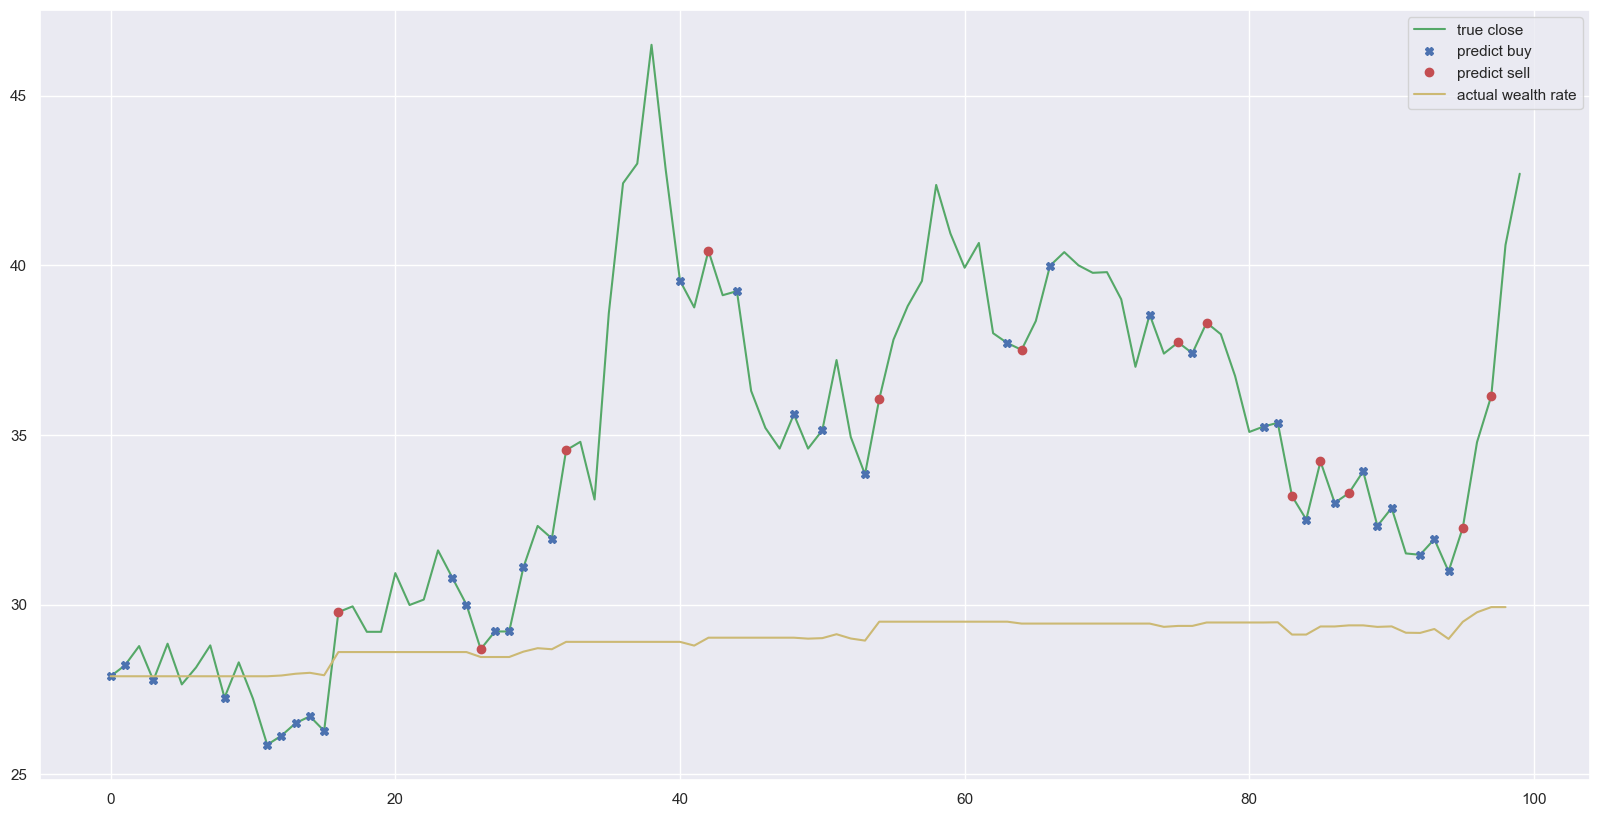

Benchmark rate is  0.5310147006095376
[array([[ 3.34925484, -0.60933144,  0.82794511, -0.3730261 , -0.70434922],
       [ 0.19618338,  3.46137381, -0.53737118,  0.92706369,  1.11181374],
       [-2.12778519,  3.72926459, -1.40069392,  0.05628115,  2.2977281 ],
       [ 0.53367948,  2.40044024,  0.66439214, -0.2155487 , -1.05062782],
       [ 1.95760263,  1.63183727, -1.94397421, -2.44852323, -3.23826512],
       [ 0.34971191, -1.18494337, -1.11211605, -2.6854521 , -0.34470694],
       [-0.69767613,  1.81517561,  0.64277253, -2.32087361, -0.5584088 ],
       [-1.68346608,  1.74957317, -1.31757625, -1.28686475, -0.27159056],
       [ 5.78326517,  1.48653362,  0.31785032,  5.10896909, -1.79348607],
       [ 3.92627599, -0.70690243, -4.14540528, -0.94724543,  1.25178129],
       [ 1.20208107,  1.50900761, -2.16554948,  3.09361239,  2.19071079],
       [-0.52299917,  1.15935716,  1.36633212,  2.35761091,  0.72899432],
       [ 2.74785047,  0.80094281,  0.43499997,  0.27848818,  1.28000288],

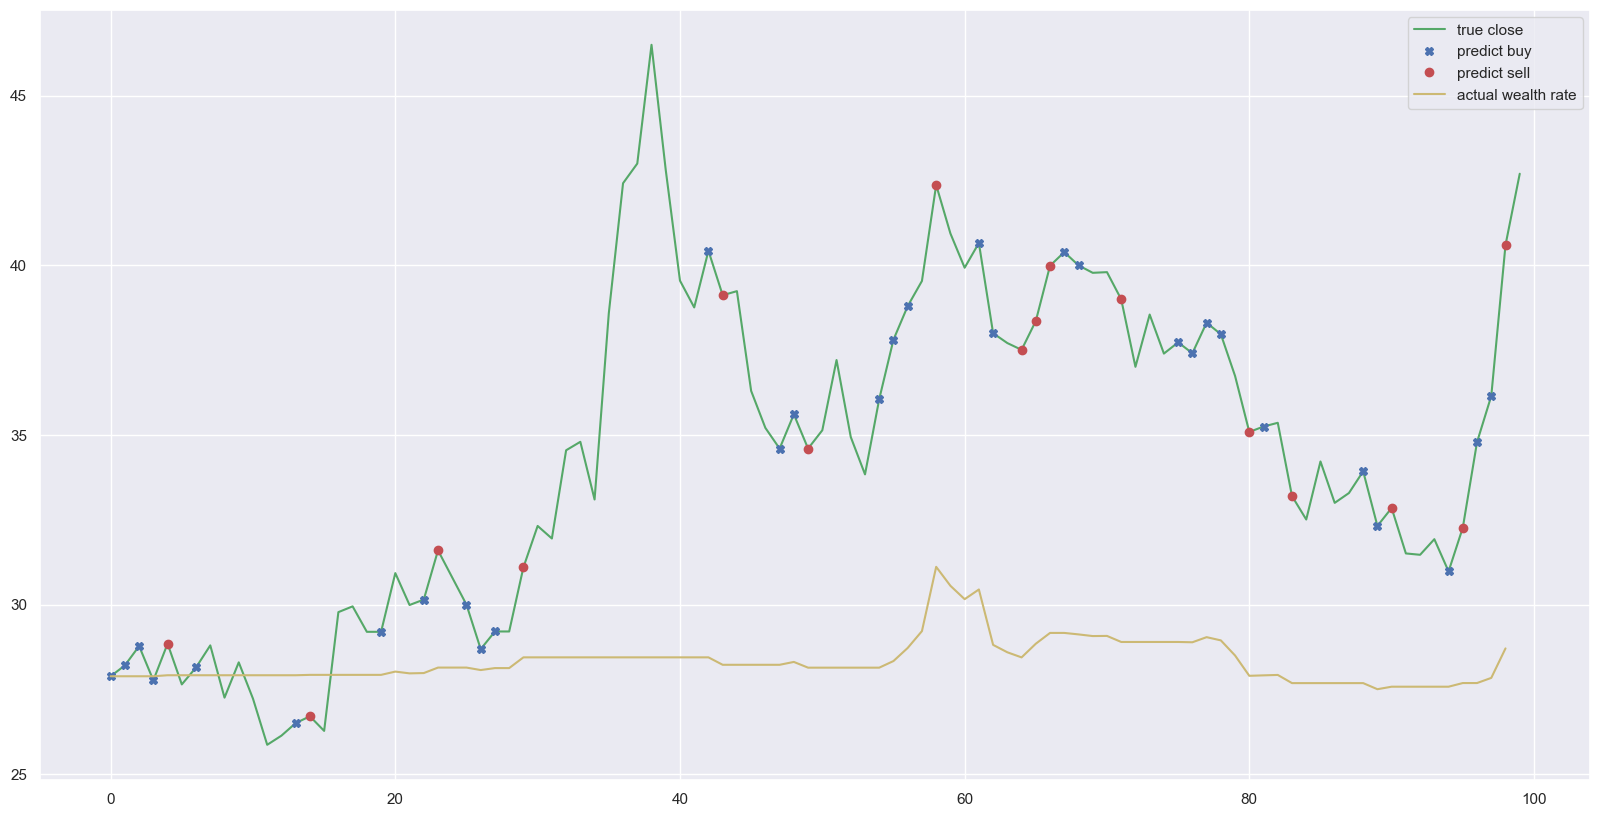

Benchmark rate is  0.5310147006095376
[array([[ 2.57147841,  1.42469759,  0.16003497, -1.76160404, -1.79755525],
       [ 4.57414124,  2.58984713, -4.18635256,  2.9281667 ,  0.25419173],
       [-0.31875012, -2.07794273, -1.24614265,  1.38432708, -1.99845556],
       [-0.66104103,  0.31869217,  1.12393863, -0.31250055,  0.98824454],
       [ 2.31276451,  1.24927442, -0.67121217,  0.78051221,  1.57256211],
       [ 1.16750259, -2.3824817 , -2.13341496, -1.35482691,  1.74690953],
       [-2.06405541, -0.92715456,  1.22001336, -0.55238102,  0.83539539],
       [ 4.45875556,  0.1101423 ,  0.43966676, -0.71397393, -1.70764672],
       [ 3.47936979, -6.5515383 ,  0.63571625, -0.31510942, -1.03356615],
       [-2.7858831 ,  1.30420319,  1.17065541, -1.58524013,  4.16423975],
       [-4.99952184,  3.58303174,  1.41155107, -0.45344704,  0.82214561],
       [-2.04790134, -1.97050678,  1.49020471, -0.63787566,  1.40769663],
       [ 5.90301207,  3.08857827, -1.33387274, -0.5125706 , -1.55612935],

In [15]:
whole_comparision_test('688362.SH',df1)